In [1]:
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.functions import round as spark_round
from pyspark.sql.types import NumericType, IntegerType, DoubleType, FloatType, LongType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, OneVsRest
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
import pyspark.pandas as ps

from xgboost.spark import SparkXGBClassifier , SparkXGBRegressor

from functools import reduce
from operator import add
import builtins
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix


plt.style.use("ggplot")
sns.set_theme()
sns.set_palette("Blues_d")

C:\Users\firem\anaconda3\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


<h3 dir="rtl" align="right">
טעינה של סביבת העבודה
</h3>

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LoadCSV") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.master", "local[*]") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "28") \
    .config("spark.default.parallelism", "28") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.locality.wait", "3s") \
    .config("spark.sql.autoBroadcastJoinThreshold", "100MB") \
    .config("spark.sql.files.maxPartitionBytes", "256MB") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()
spark

<h3 dir="rtl" align="right">
טעינה של ה dataset
</h3>

In [5]:
 df = spark.read.csv(
    path="dataset4.txt",
    sep=",",
    header=True,
    quote="",
    inferSchema=True,
    )
df.toPandas().head()

ID   Age  Gender Department Work_Mode  Current_Experience  Companies_Count  \
0   1  28.0    Male      Legal    Office                 0.0              0.0   
1   2  50.0    Male    Support    Remote                35.0              0.0   
2   3  36.0  Female    Finance    Office                 2.0              5.0   
3   4  34.0    Male    Finance    Hybrid                11.0              7.0   
4   5  29.0    Male      Legal    Hybrid                 5.0              0.0   

   Education_Years  Total_Experience Seniority  Monthly_Hours  \
0             17.0               4.0    Junior          169.0   
1             15.0              35.0   Manager          191.0   
2             15.0               8.0       Mid          171.0   
3             16.0              12.0       Mid          171.0   
4             17.0               6.0       Mid          159.0   

   Job_Satisfaction  Performance_Review   Salary  
0               4.0                 7.0  11500.0  
1               5.0                10.0  31700.0  
2               4.0                 6.0  17800.0  
3               3.0                 8.0  18800.0  
4               5.0                 9.0  20500.0

<h3 dir="rtl" align="right">
ניתוח ראשוני של העמודות – ערכים חסרים וערכים ייחודיים
</h3>

In [7]:
def check_df(df, columns=None):
    cols = columns if columns else df.columns
    if isinstance(cols, str):
        cols = [cols]
    
    df_cached = df.cache()
    total_rows = df_cached.count()
    
    print(f"Dataset Shape: ({total_rows}, {len(cols)})")
    
    agg_exprs = [
        sum(when(reduce(lambda a, b: a | b, [col(c).isNull() for c in cols]), 1).otherwise(0)).alias("rows_with_null")
    ]
    
    for c in cols:
        agg_exprs.extend([
            count(c).alias(f"non_null_{c}"),
            sum(when(col(c).isNull(), 1).otherwise(0)).alias(f"null_{c}"),
            countDistinct(c).alias(f"unique_{c}")
        ])
    
    res = df_cached.agg(*agg_exprs).collect()[0].asDict()
    
    print(f"Total rows with at least one NULL: {res['rows_with_null']} ({res['rows_with_null']/total_rows*100:.2f}%)")
    print("-" * 100)
    
    dtypes_dict = dict(df_cached.dtypes)
    
    print(f"{'Column':<30} {'Dtype':<15} {'Non-Null':<12} {'Null':<12} {'Null %':<10} {'Unique':<10}")
    print("=" * 100)
    
    for c in cols:
        null_count = int(res[f"null_{c}"])
        null_percent = builtins.round(null_count / total_rows * 100, 2)
        print(f"{c:<30} {dtypes_dict[c]:<15} {int(res[f'non_null_{c}']):<12} "
              f"{null_count:<12} {null_percent:<10} {int(res[f'unique_{c}']):<10}")
    
    df_cached.unpersist()

In [8]:
check_df(df)

Dataset Shape: (10000, 14)
Total rows with at least one NULL: 2209 (22.09%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
ID                             int             10000        0            0.0        10000     
Age                            double          9722         278          2.78       56        
Gender                         string          9845         155          1.55       2         
Department                     string          9856         144          1.44       7         
Work_Mode                      string          9753         247          2.47       3         
Current_Experience             double          9816         184          1.84       60        
Companies_Count                double          9895         105          1.05       18        
Education_Years                double          9883         117

<h3 dir="rtl" align="right">
ניתוח ראשוני של העמודות – נתונים סטטיסטיים
</h3>

In [10]:
def show_describe(df, decimals=2, pandas=False, transpose=False):
    numeric_types = (IntegerType, LongType, FloatType, DoubleType)
    numeric_cols = [c for c in df.columns if isinstance(df.schema[c].dataType, numeric_types)]
    
    if not numeric_cols:
        print("No numeric columns found")
        return

    stats = df.select(numeric_cols).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max")
    
    for c in numeric_cols:
        stats = stats.withColumn(c, spark_round(col(c).cast("double"), decimals))

    result_pd = stats.toPandas()
    
    total_count = int(result_pd.loc[result_pd['summary'] == 'count', numeric_cols[0]].values[0])

    stack_expr = f"stack({len(numeric_cols)}, " + \
                 ", ".join([f"'{c}', CAST({c} AS STRING)" for c in numeric_cols]) + \
                 ") as (col_name, value)"
    
    mode_data = df.select(expr(stack_expr)) \
        .filter(col("value").isNotNull()) \
        .groupBy("col_name", "value") \
        .count() \
        .withColumn("rn", row_number().over(Window.partitionBy("col_name").orderBy(desc("count")))) \
        .filter(col("rn") == 1) \
        .collect()

    mode_dict = {}
    freq_dict = {}
    
    for row in mode_data:
        c = row['col_name']
        val = row['value']
        count_val = row['count']
        
        try:
            num_val = float(val)
            mode_dict[c] = builtins.round(num_val, decimals) if num_val % 1 != 0 else int(num_val)
        except:
            mode_dict[c] = val
            
        freq_dict[c] = builtins.round((count_val / total_count) * 100, decimals)

    if pandas:
        mode_row = pd.DataFrame([mode_dict]).assign(summary='mode')
        freq_row = pd.DataFrame([freq_dict]).assign(summary='mode_freq%')
        result_pd = pd.concat([result_pd, mode_row, freq_row], ignore_index=True)
        
        if transpose:
            result_pd = result_pd.set_index('summary').T
        return result_pd
    else:
        stats.show(truncate=False)
        print(f"\nmode: {mode_dict}")
        print(f"mode_freq%: {freq_dict}")

In [11]:
show_describe(df, decimals=2, pandas=True, transpose=True)

summary               count      mean    stddev      min      25%      50%  \
ID                  10000.0   5000.50   2886.90      1.0   2499.0   4999.0   
Age                  9722.0     36.47      9.49    -27.0     29.0     36.0   
Current_Experience   9816.0      7.30      8.49    -44.0      1.0      4.0   
Companies_Count      9895.0      3.53      2.37    -12.0      2.0      4.0   
Education_Years      9883.0     15.76      1.98      2.0     15.0     16.0   
Total_Experience     9857.0     11.75      9.37    -51.0      5.0     10.0   
Monthly_Hours        9799.0    174.55     17.03     61.0    163.0    173.0   
Job_Satisfaction     9695.0      3.37      1.20      1.0      3.0      3.0   
Performance_Review   9773.0      7.54      1.19      6.0      7.0      7.0   
Salary               9895.0  20159.81  10031.27 -47700.0  12400.0  18500.0   

summary                 75%      max     mode  mode_freq%  
ID                   7499.0  10000.0      8.0        0.01  
Age                    42.0     97.0     28.0        5.76  
Current_Experience     10.0     64.0      0.0       15.76  
Companies_Count         6.0     19.0      4.0       13.04  
Education_Years        17.0     28.0     15.0       21.17  
Total_Experience       17.0     75.0     11.0        6.58  
Monthly_Hours         185.0    284.0    171.0        2.76  
Job_Satisfaction        4.0      5.0      3.0       27.09  
Performance_Review      8.0     10.0      7.0       26.80  
Salary              26400.0  86700.0  11900.0        0.90

<h3 dir="rtl" align="right">
עמודות קטגוריאליות מסוג מחרוזת (STR) – בחינת הערכים
</h3>

In [13]:
cat_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
distinct_values = {c: [row[0] for row in df.select(c).distinct().collect()] for c in cat_cols}
distinct_values

{'Gender': ['Female', 'Male', None],
 'Department': ['Legal',
  'Marketing',
  'Support',
  'Finance',
  'HR',
  'Sales',
  'R&D',
  None],
 'Work_Mode': ['Remote', 'Hybrid', 'Office', None],
 'Seniority': ['Mid', 'Senior', 'Manager', 'Junior', None]}

<h3 dir="rtl" align="right">
בחינת פיזור הערכים בכל עמודה
</h3>

In [15]:
def graph_stats(df, exclude_cols=None, n_cols=3, cat_threshold=30, sample_limit=50000):
    cols = [c for c in df.columns 
            if (exclude_cols is None or c not in exclude_cols) 
            and 'id' not in c.lower()]
    
    if not cols:
        print("No columns found to plot.")
        return

    total_rows = df.count()
    print(f"Generating graphs for {len(cols)} columns (Total rows: {total_rows})...")

    n_rows = math.ceil(len(cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

    for i, col_name in enumerate(cols):
        ax = axes[i]
        dtype = df.schema[col_name].dataType
        is_numeric = isinstance(dtype, (IntegerType, LongType, FloatType, DoubleType))

        unique_count = df.select(col_name).distinct().limit(cat_threshold + 1).count()

        if not is_numeric or unique_count <= cat_threshold:
            counts_pd = df.groupBy(col_name).count() \
                          .orderBy(F.desc("count")) \
                          .limit(cat_threshold) \
                          .toPandas()
            
            if not counts_pd.empty:
                sns.barplot(data=counts_pd, x=col_name, y='count', ax=ax, hue=col_name, palette="Blues_d", legend=False)
                ax.set_title(f"{col_name}\n(Categorical/Discrete - Top {len(counts_pd)})")
                if len(counts_pd) > 5:
                    ax.tick_params(axis='x', rotation=45)
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        
        else:
            data_sample = df.select(col_name).dropna().limit(sample_limit).toPandas()[col_name]
            
            if not data_sample.empty:
                sns.histplot(data_sample, kde=True, ax=ax, color='#A8D5E2', bins='auto')
                ax.set_title(f"{col_name}\n(Continuous Distribution)")
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center')

        ax.set_ylabel('Count')

    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

Generating graphs for 13 columns (Total rows: 10000)...


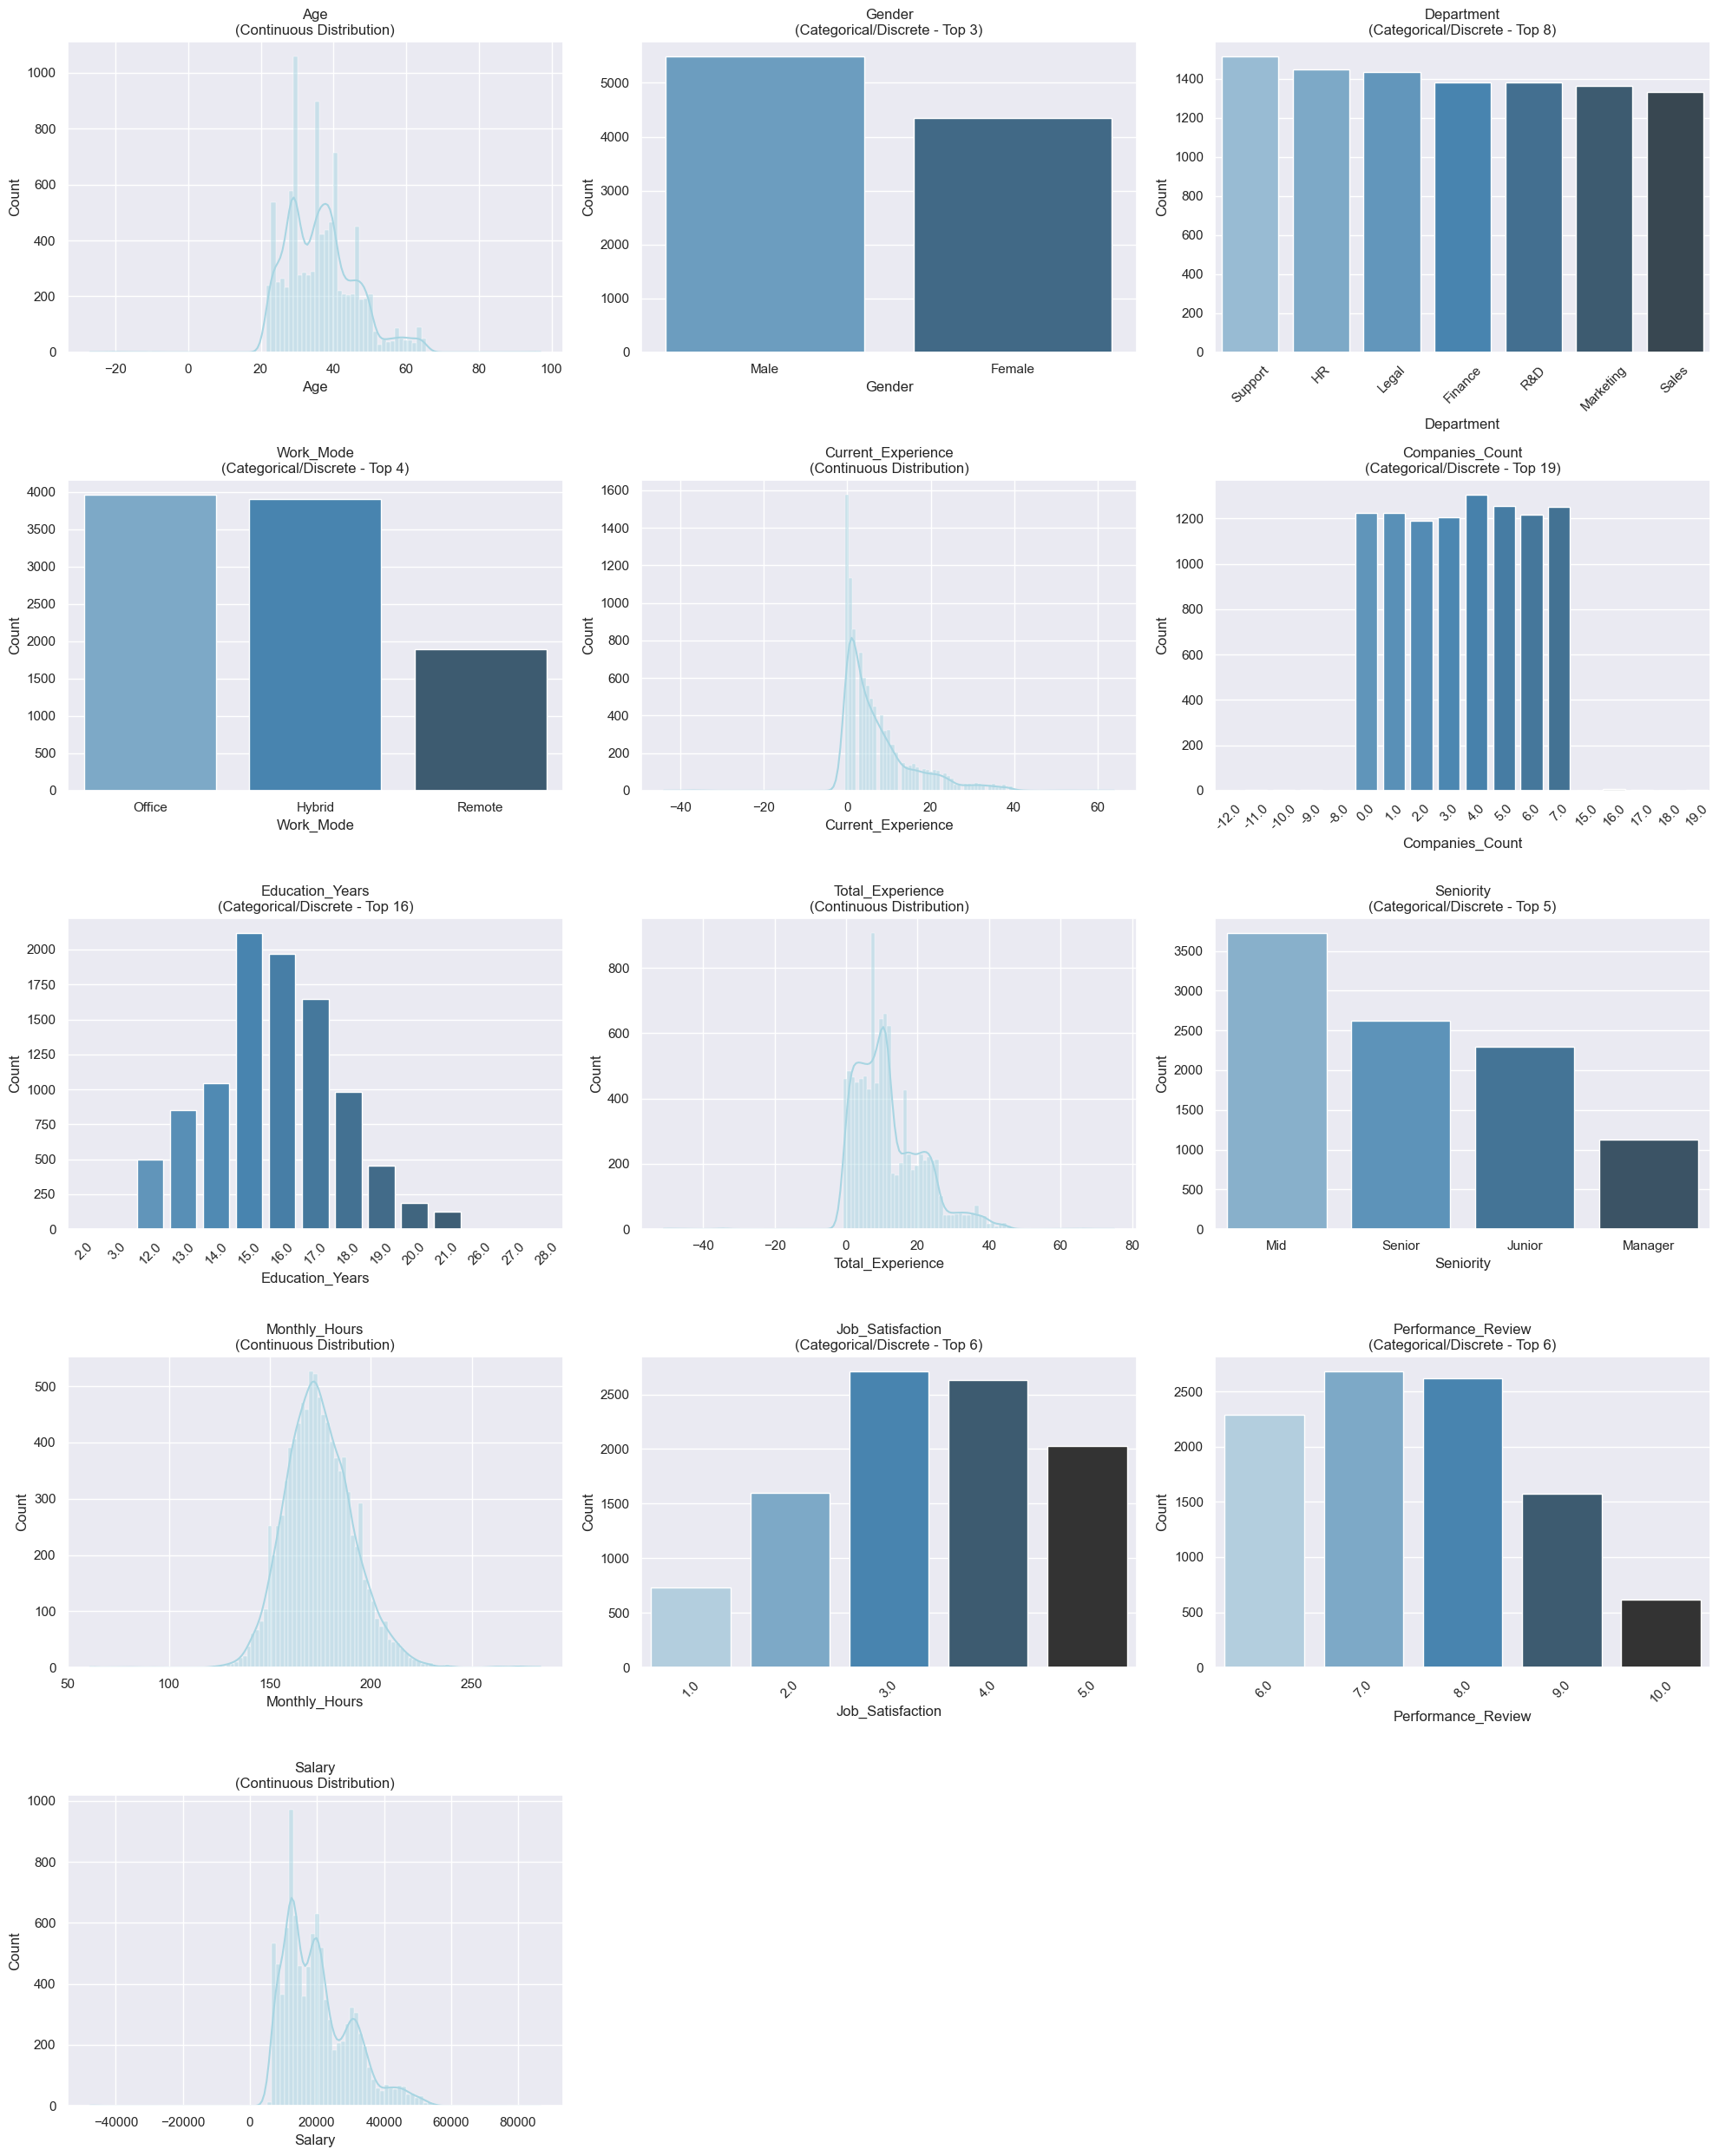

In [16]:
graph_stats(df)

In [17]:
dfc = df

<h3 dir="rtl" align="right">
ניקוי נתונים – מחיקת ערכים קטנים מ 0 בכל שדה נומרי
</h3>

In [19]:
numeric_cols = [c for c in df.columns if isinstance(df.schema[c].dataType, NumericType) and c not in ['ID']]

In [20]:
for c in numeric_cols:
    dfc = dfc.withColumn(c, F.when(F.col(c) >= 0, F.col(c)).otherwise(F.lit(None)))

<h3 dir="rtl" align="right">
ניקוי נתונים – מגבלת גיל העובד 
</h3>

In [22]:
dfc = dfc.withColumns({
    "Age": F.when((F.col("Age") < 18) | (F.col("Age") > 70), F.lit(None))
               .otherwise(F.col("Age"))})

<h3 dir="rtl" align="right">
ניקוי נתונים – הגבלת מספר שנות הלימוד בהתאם לגיל 
</h3>

In [24]:
dfc = dfc.withColumn("Education_Years", 
                     F.when(F.col("Age") >= (F.col("Education_Years") + 6), F.col("Education_Years"))
                      .otherwise(F.lit(None)))

<h3 dir="rtl" align="right">
ניקוי נתונים – הגבלת מספר שנות הניסיון הכולל בהתאם לגיל 
</h3>

In [26]:
dfc = dfc.withColumn("Total_Experience", 
                     F.when(F.col("Total_Experience") > (F.col("Age") - 18), F.lit(None))
                      .otherwise(F.col("Total_Experience")))

<h3 dir="rtl" align="right">
ניקוי נתונים – הגבלת הוותק בתפקיד הנוכחי בהתאם לשנות הניסיון הכולל
</h3>

In [28]:
dfc = dfc.withColumn("Current_Experience", 
                     F.when(F.col("Current_Experience") > F.col("Total_Experience"), F.lit(None))
                      .otherwise(F.col("Current_Experience")))

<h3 dir="rtl" align="right">
ניקוי נתונים – הגבלת כמות החברות בהתאם לשנות הניסיון הכולל
</h3>

In [30]:
dfc = dfc.withColumn("Companies_Count", 
                     F.when(F.col("Companies_Count") > F.col("Total_Experience"), F.lit(None))
                      .otherwise(F.col("Companies_Count")))

<h3 dir="rtl" align="right">
ניקוי נתונים – הסרת ערכי קיצון החורגים מ 3 סטיות תקן מהממוצע
</h3>

In [32]:
selected_cols = ['Current_Experience', 'Companies_Count', 'Education_Years', 'Total_Experience', 'Monthly_Hours', 'Salary']

In [33]:
stats = dfc.select(
    *[F.mean(c).alias(c + '_mean') for c in numeric_cols],
    *[F.stddev(c).alias(c + '_std') for c in numeric_cols]
).first()

for c in selected_cols:
    mean_val = stats[c + '_mean']
    std_val = stats[c + '_std']
    
    if std_val is None: std_val = 0
    
    lower_bound = mean_val - (3 * std_val)
    upper_bound = mean_val + (3 * std_val)
    
    dfc = dfc.withColumn(c, F.when((F.col(c) >= lower_bound) & (F.col(c) <= upper_bound), F.col(c))
                            .otherwise(F.lit(None)))

<h3 dir="rtl" align="right">
בחינה חוזרת של הנתונים שנותרו לאחר הניקוי
</h3>

In [35]:
check_df(dfc)

Dataset Shape: (10000, 14)
Total rows with at least one NULL: 4362 (43.62%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
ID                             int             10000        0            0.0        10000     
Age                            double          9709         291          2.91       44        
Gender                         string          9845         155          1.55       2         
Department                     string          9856         144          1.44       7         
Work_Mode                      string          9753         247          2.47       3         
Current_Experience             double          9563         437          4.37       32        
Companies_Count                double          8269         1731         17.31      8         
Education_Years                double          9422         578

In [36]:
null_count = reduce(add, [F.when(F.col(c).isNull(), 1).otherwise(0) for c in dfc.columns])
dfc.filter(null_count >= 1).count()

4362

In [37]:
show_describe(dfc, decimals=2, pandas=True, transpose=True)

summary               count      mean   stddev     min      25%      50%  \
ID                  10000.0   5000.50  2886.90     1.0   2499.0   4999.0   
Age                  9709.0     36.49     9.28    22.0     29.0     36.0   
Current_Experience   9563.0      6.62     7.03     0.0      1.0      4.0   
Companies_Count      8269.0      3.24     2.28     0.0      1.0      3.0   
Education_Years      9422.0     15.71     1.92    12.0     15.0     16.0   
Total_Experience     9028.0     10.34     7.59     0.0      4.0      9.0   
Monthly_Hours        9747.0    174.30    16.09   124.0    163.0    173.0   
Job_Satisfaction     9695.0      3.37     1.20     1.0      3.0      3.0   
Performance_Review   9773.0      7.54     1.19     6.0      7.0      7.0   
Salary               9817.0  19967.67  9525.23  6300.0  12400.0  18500.0   

summary                 75%      max     mode  mode_freq%  
ID                   7499.0  10000.0      8.0        0.01  
Age                    42.0     65.0     28.0        5.76  
Current_Experience     10.0     31.0      0.0       15.76  
Companies_Count         5.0      7.0      0.0       12.24  
Education_Years        17.0     21.0     15.0       20.50  
Total_Experience       15.0     35.0     10.0        6.42  
Monthly_Hours         185.0    225.0    171.0        2.76  
Job_Satisfaction        4.0      5.0      3.0       27.09  
Performance_Review      8.0     10.0      7.0       26.80  
Salary              26100.0  49800.0  11900.0        0.90

Generating graphs for 13 columns (Total rows: 10000)...


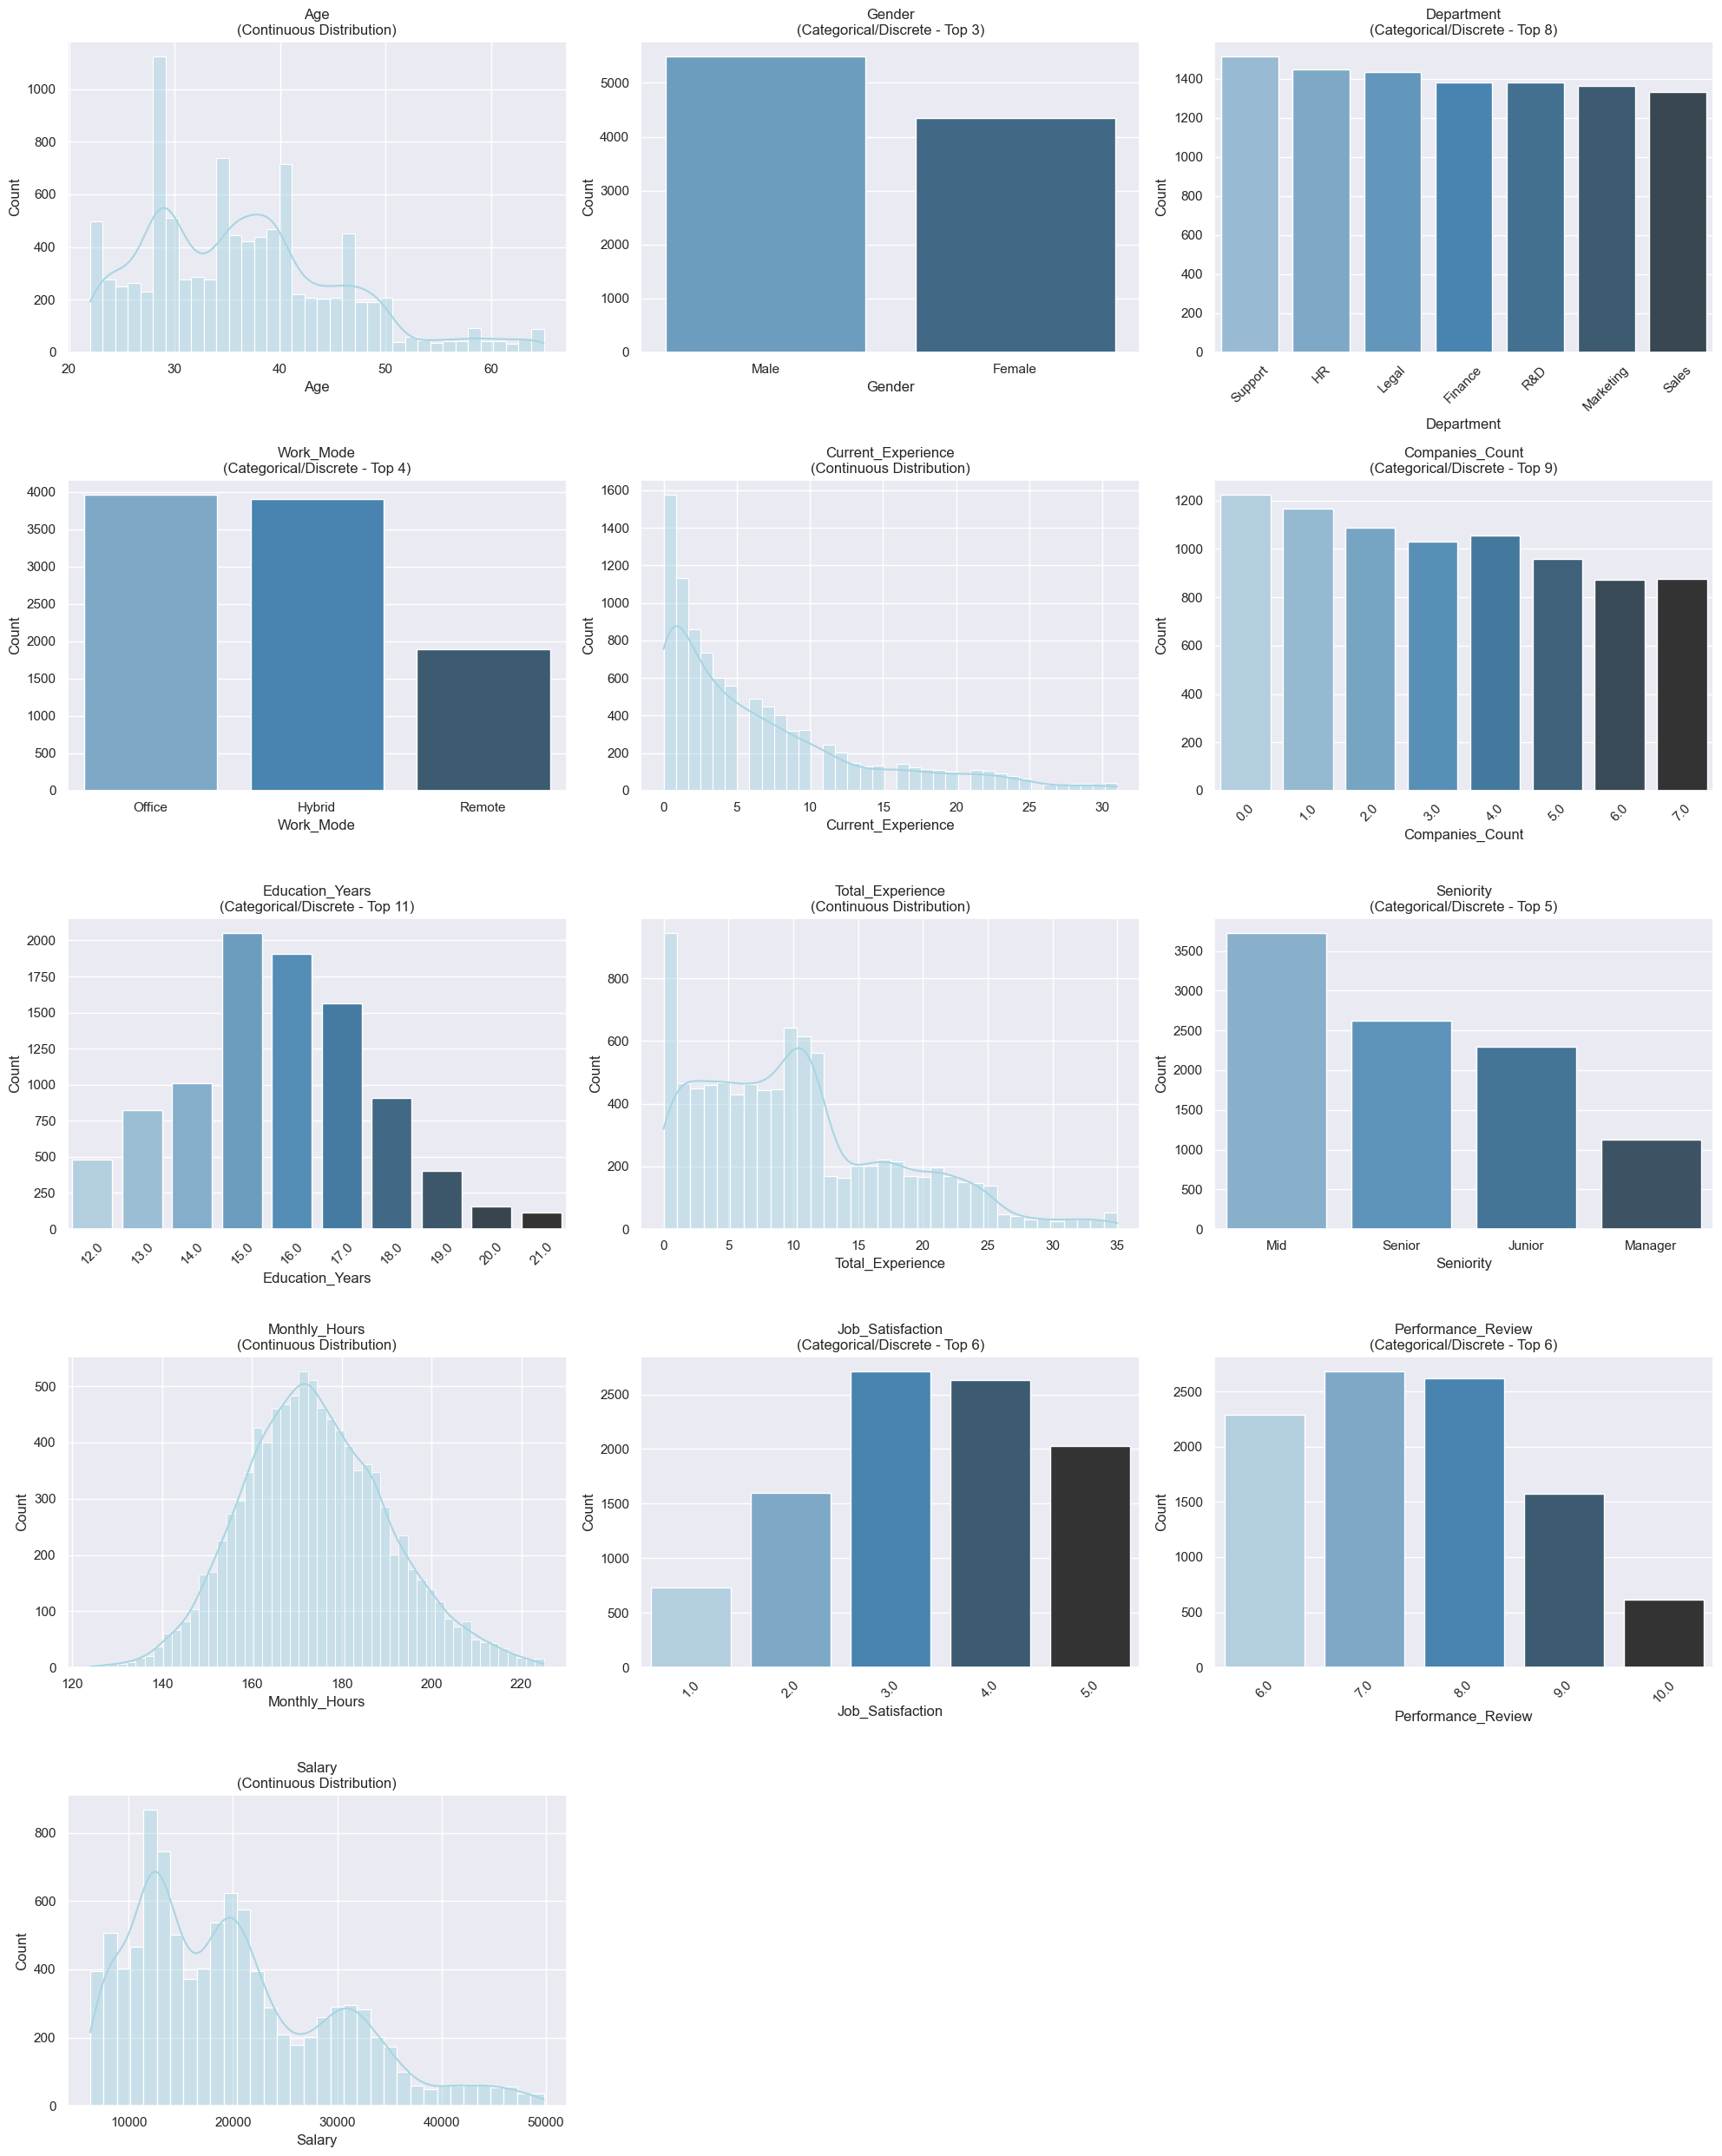

In [38]:
graph_stats(dfc)

<h3 dir="rtl" align="right">
בחינת ערכים קטגוריאליים
</h3>

In [40]:
cols_to_check = ["Gender", "Department", "Work_Mode", "Seniority", "Job_Satisfaction", "Performance_Review"]
for col_name in cols_to_check:
    if col_name in dfc.columns:
        print(f"\n--- Column: {col_name} ---")
        total = dfc.count()
        dfc.groupBy(col_name)\
           .count()\
           .withColumn("percentage", F.round((F.col("count") / total) * 100, 2))\
           .orderBy("count", ascending=False)\
           .show(truncate=False)
    else:
        print(f"\n[!] Column '{col_name}' not found in DataFrame.")


--- Column: Gender ---
+------+-----+----------+
|Gender|count|percentage|
+------+-----+----------+
|Male  |5492 |54.92     |
|Female|4353 |43.53     |
|NULL  |155  |1.55      |
+------+-----+----------+


--- Column: Department ---
+----------+-----+----------+
|Department|count|percentage|
+----------+-----+----------+
|Support   |1515 |15.15     |
|HR        |1447 |14.47     |
|Legal     |1433 |14.33     |
|Finance   |1383 |13.83     |
|R&D       |1383 |13.83     |
|Marketing |1364 |13.64     |
|Sales     |1331 |13.31     |
|NULL      |144  |1.44      |
+----------+-----+----------+


--- Column: Work_Mode ---
+---------+-----+----------+
|Work_Mode|count|percentage|
+---------+-----+----------+
|Office   |3959 |39.59     |
|Hybrid   |3903 |39.03     |
|Remote   |1891 |18.91     |
|NULL     |247  |2.47      |
+---------+-----+----------+


--- Column: Seniority ---
+---------+-----+----------+
|Seniority|count|percentage|
+---------+-----+----------+
|Mid      |3724 |37.24     |
|

<h3 dir="rtl" align="right">
קידוד משתנים קטגוריאליים לערכים נומריים (Label Encoding)
</h3>

In [42]:
dfnum = dfc.withColumns({
    "Gender": F.when(F.col("Gender") == "Male", 1)
               .when(F.col("Gender") == "Female", 2)
               .otherwise(None),

    "Seniority": F.when(F.col("Seniority") == "Junior", 1)
                  .when(F.col("Seniority") == "Mid", 2)
                  .when(F.col("Seniority") == "Senior", 3)
                  .when(F.col("Seniority") == "Manager", 4)
                  .otherwise(None),

    "Work_Mode": F.when(F.col("Work_Mode") == "Remote", 1)
                  .when(F.col("Work_Mode") == "Hybrid", 2)
                  .when(F.col("Work_Mode") == "Office", 3)
                  .otherwise(None),

    "Department": F.when(F.col("Department") == "Marketing", 1)
                   .when(F.col("Department") == "Legal", 2)
                   .when(F.col("Department") == "Sales", 3)
                   .when(F.col("Department") == "R&D", 4)
                   .when(F.col("Department") == "Finance", 5)
                   .when(F.col("Department") == "Support", 6)
                   .when(F.col("Department") == "HR", 7)
                   .otherwise(None)
})

In [43]:
dfnum.toPandas().head()

ID   Age  Gender  Department  Work_Mode  Current_Experience  \
0   1  28.0     1.0         2.0        3.0                 0.0   
1   2  50.0     1.0         6.0        1.0                 NaN   
2   3  36.0     2.0         5.0        3.0                 2.0   
3   4  34.0     1.0         5.0        2.0                11.0   
4   5  29.0     1.0         2.0        2.0                 5.0   

   Companies_Count  Education_Years  Total_Experience  Seniority  \
0              0.0             17.0               4.0        1.0   
1              0.0             15.0               NaN        4.0   
2              5.0             15.0               8.0        2.0   
3              7.0             16.0              12.0        2.0   
4              0.0             17.0               6.0        2.0   

   Monthly_Hours  Job_Satisfaction  Performance_Review   Salary  
0          169.0               4.0                 7.0  11500.0  
1          191.0               5.0                10.0  31700.0  
2          171.0               4.0                 6.0  17800.0  
3          171.0               3.0                 8.0  18800.0  
4          159.0               5.0                 9.0  20500.0

In [44]:
check_df(dfnum)

Dataset Shape: (10000, 14)
Total rows with at least one NULL: 4362 (43.62%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
ID                             int             10000        0            0.0        10000     
Age                            double          9709         291          2.91       44        
Gender                         int             9845         155          1.55       2         
Department                     int             9856         144          1.44       7         
Work_Mode                      int             9753         247          2.47       3         
Current_Experience             double          9563         437          4.37       32        
Companies_Count                double          8269         1731         17.31      8         
Education_Years                double          9422         578

<h3 dir="rtl" align="right">
בדיקה ויזואלית של קורלציות בין כל זוג עמודות
</h3>

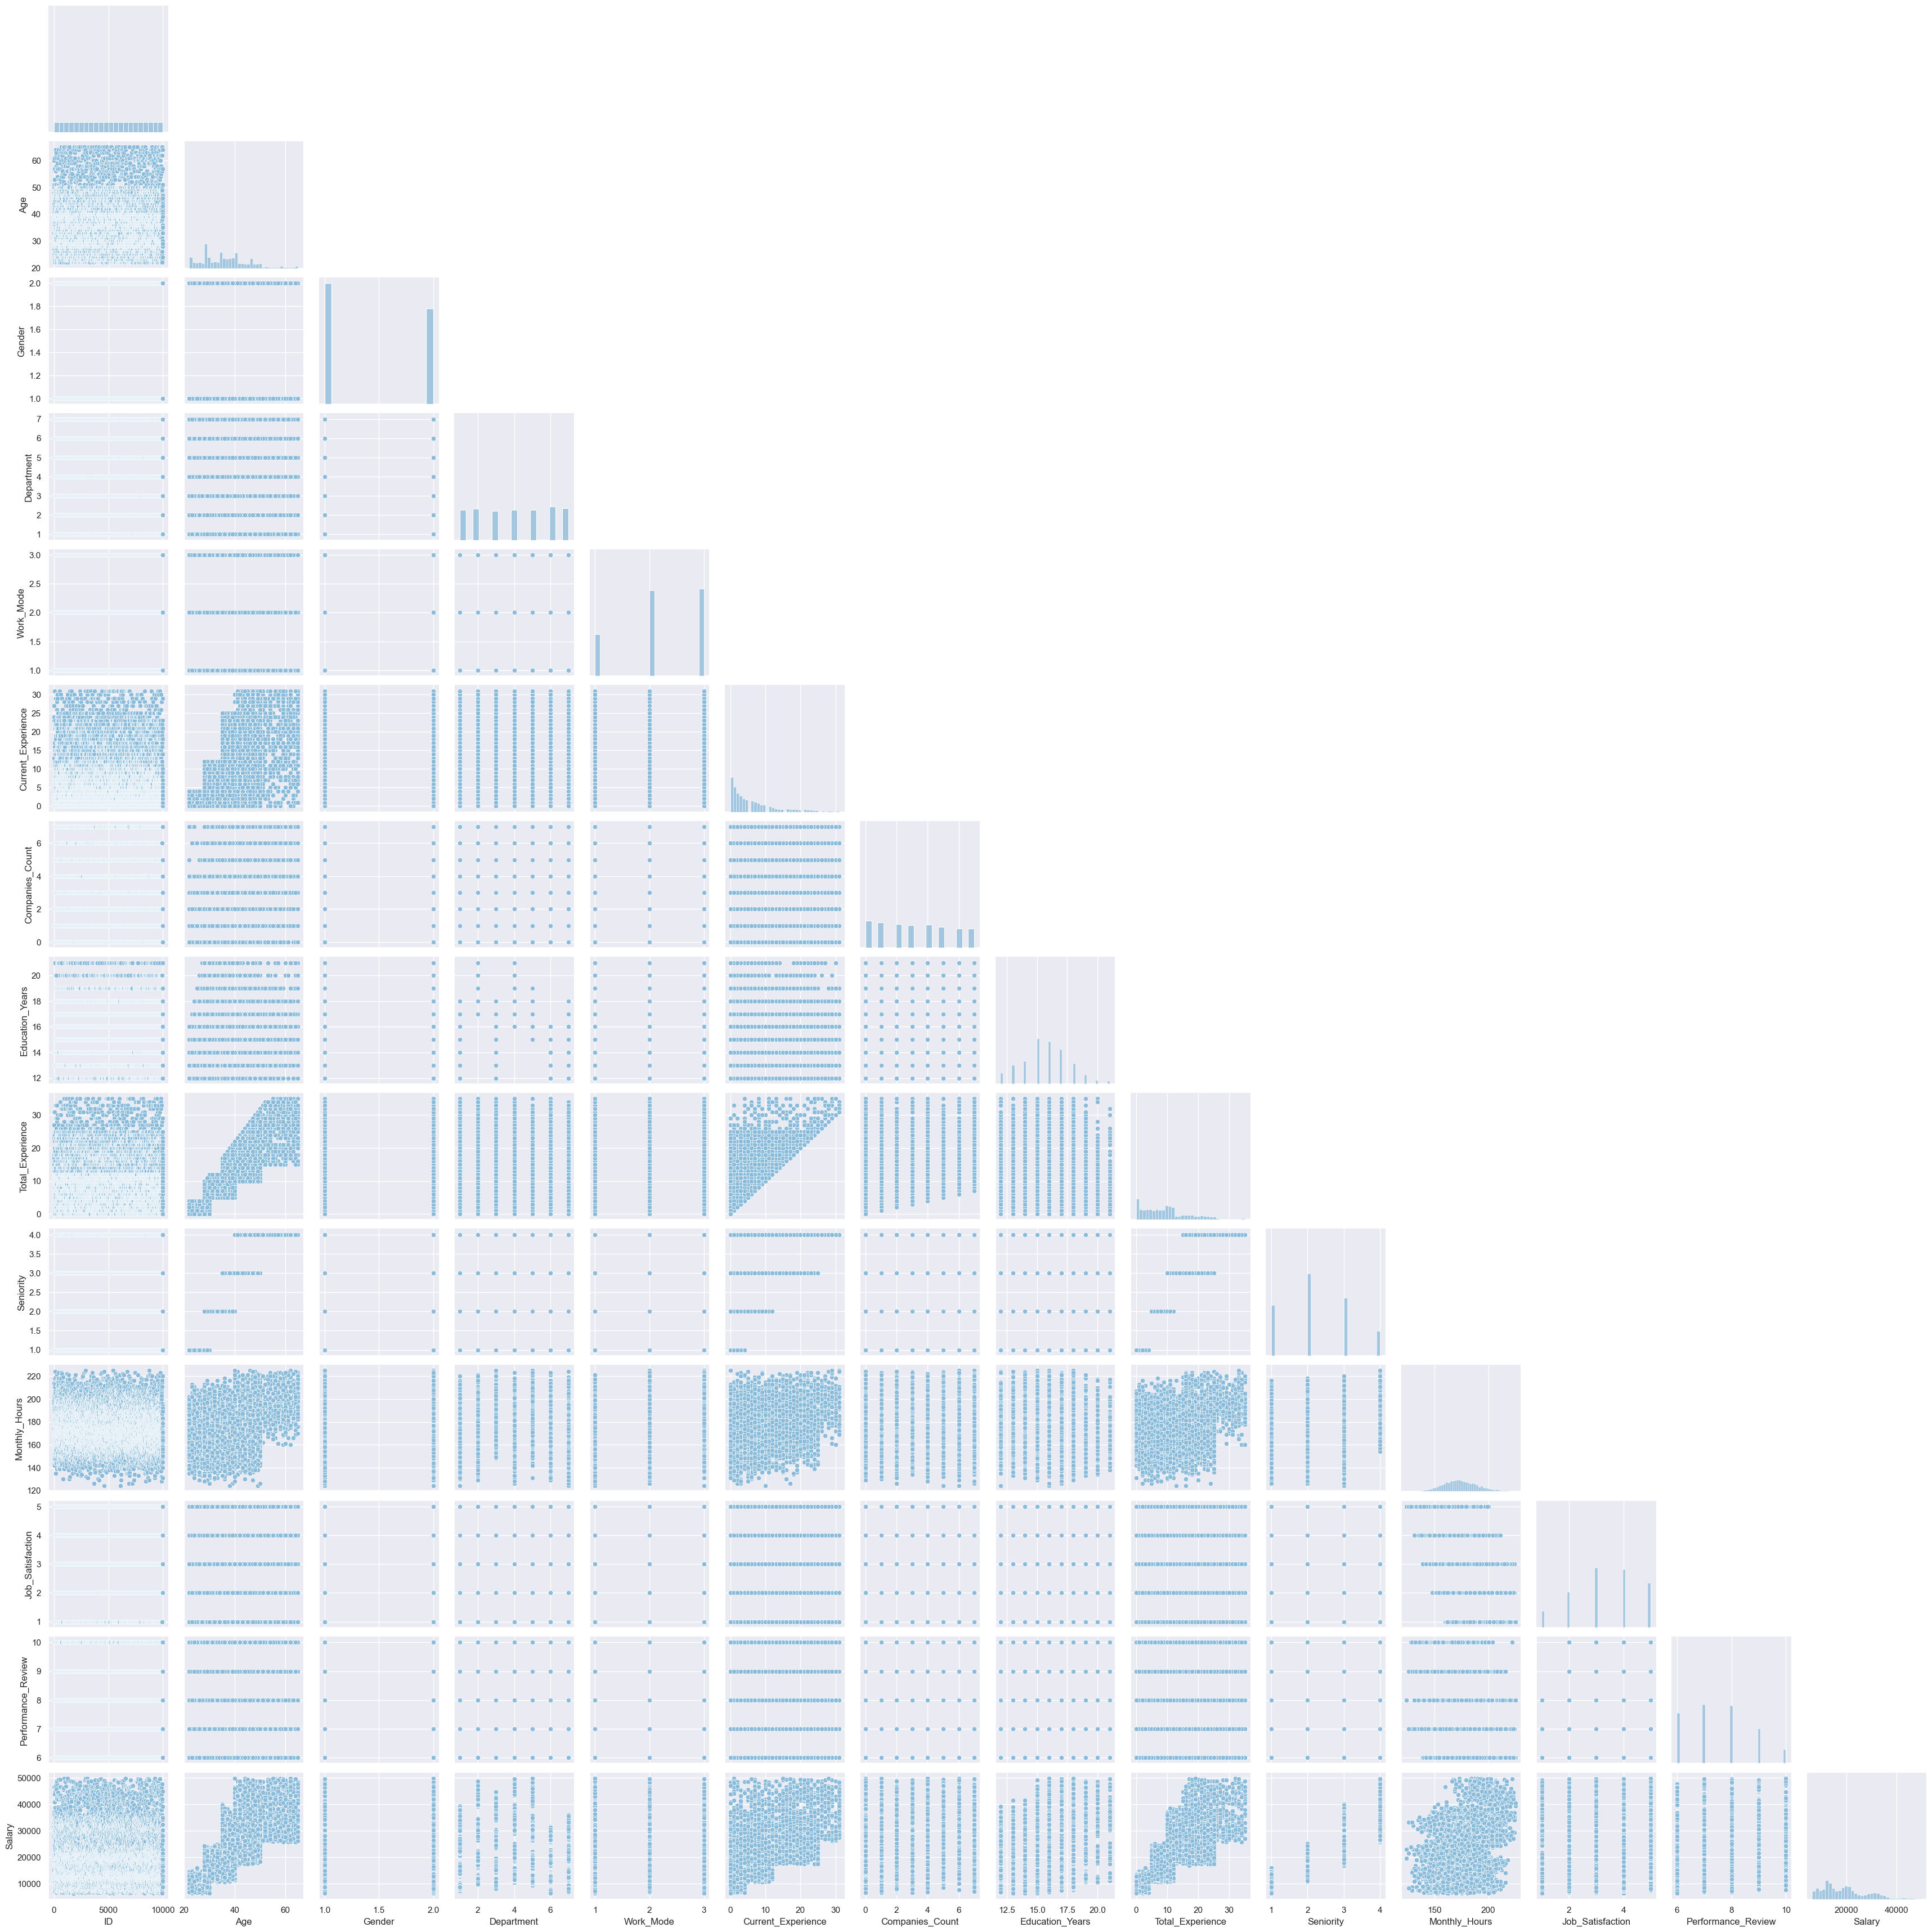

In [46]:
sns.pairplot(dfnum.toPandas(), corner=True)

In [47]:
data = dfnum.dropna()
data.toPandas().head()

ID   Age  Gender  Department  Work_Mode  Current_Experience  \
0   1  28.0       1           2          3                 0.0   
1   3  36.0       2           5          3                 2.0   
2   4  34.0       1           5          2                11.0   
3   5  29.0       1           2          2                 5.0   
4  10  60.0       1           7          3                23.0   

   Companies_Count  Education_Years  Total_Experience  Seniority  \
0              0.0             17.0               4.0          1   
1              5.0             15.0               8.0          2   
2              7.0             16.0              12.0          2   
3              0.0             17.0               6.0          2   
4              6.0             14.0              23.0          4   

   Monthly_Hours  Job_Satisfaction  Performance_Review   Salary  
0          169.0               4.0                 7.0  11500.0  
1          171.0               4.0                 6.0  17800.0  
2          171.0               3.0                 8.0  18800.0  
3          159.0               5.0                 9.0  20500.0  
4          204.0               1.0                 6.0  27900.0

In [48]:
check_df(data)

Dataset Shape: (5638, 14)
Total rows with at least one NULL: 0 (0.00%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
ID                             int             5638         0            0.0        5638      
Age                            double          5638         0            0.0        44        
Gender                         int             5638         0            0.0        2         
Department                     int             5638         0            0.0        7         
Work_Mode                      int             5638         0            0.0        3         
Current_Experience             double          5638         0            0.0        32        
Companies_Count                double          5638         0            0.0        8         
Education_Years                double          5638         0       

In [49]:
show_describe(dfnum, decimals=2, pandas=True, transpose=True)

summary               count      mean   stddev     min      25%      50%  \
ID                  10000.0   5000.50  2886.90     1.0   2499.0   4999.0   
Age                  9709.0     36.49     9.28    22.0     29.0     36.0   
Gender               9845.0      1.44     0.50     1.0      1.0      1.0   
Department           9856.0      4.05     2.01     1.0      2.0      4.0   
Work_Mode            9753.0      2.21     0.74     1.0      2.0      2.0   
Current_Experience   9563.0      6.62     7.03     0.0      1.0      4.0   
Companies_Count      8269.0      3.24     2.28     0.0      1.0      3.0   
Education_Years      9422.0     15.71     1.92    12.0     15.0     16.0   
Total_Experience     9028.0     10.34     7.59     0.0      4.0      9.0   
Seniority            9765.0      2.26     0.95     1.0      2.0      2.0   
Monthly_Hours        9747.0    174.30    16.09   124.0    163.0    173.0   
Job_Satisfaction     9695.0      3.37     1.20     1.0      3.0      3.0   
Performance_Review   9773.0      7.54     1.19     6.0      7.0      7.0   
Salary               9817.0  19967.67  9525.23  6300.0  12400.0  18500.0   

summary                 75%      max     mode  mode_freq%  
ID                   7499.0  10000.0      8.0        0.01  
Age                    42.0     65.0     28.0        5.76  
Gender                  2.0      2.0      1.0       54.92  
Department              6.0      7.0      6.0       15.15  
Work_Mode               3.0      3.0      3.0       39.59  
Current_Experience     10.0     31.0      0.0       15.76  
Companies_Count         5.0      7.0      0.0       12.24  
Education_Years        17.0     21.0     15.0       20.50  
Total_Experience       15.0     35.0     10.0        6.42  
Seniority               3.0      4.0      2.0       37.24  
Monthly_Hours         185.0    225.0    171.0        2.76  
Job_Satisfaction        4.0      5.0      3.0       27.09  
Performance_Review      8.0     10.0      7.0       26.80  
Salary              26100.0  49800.0  11900.0        0.90

<h3 dir="rtl" align="right">
בדיקה סטטיסטית של קורלציות בין העמודות
</h3>

In [51]:
def correlation_matrix(df, exclude_cols=None, figsize=(9, 7), sample_frac=0.1):

    if exclude_cols:
        cols = [c for c in df.columns if c not in exclude_cols]
        df = df.select(cols)
    
    df_pandas = df.sample(fraction=sample_frac).toPandas()
    
    df_pandas = df_pandas.select_dtypes(include='number')
    
    corr_matrix = df_pandas.corr().round(2)
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix.abs(), annot=corr_matrix, vmin=0, vmax=1, fmt='.2f')
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

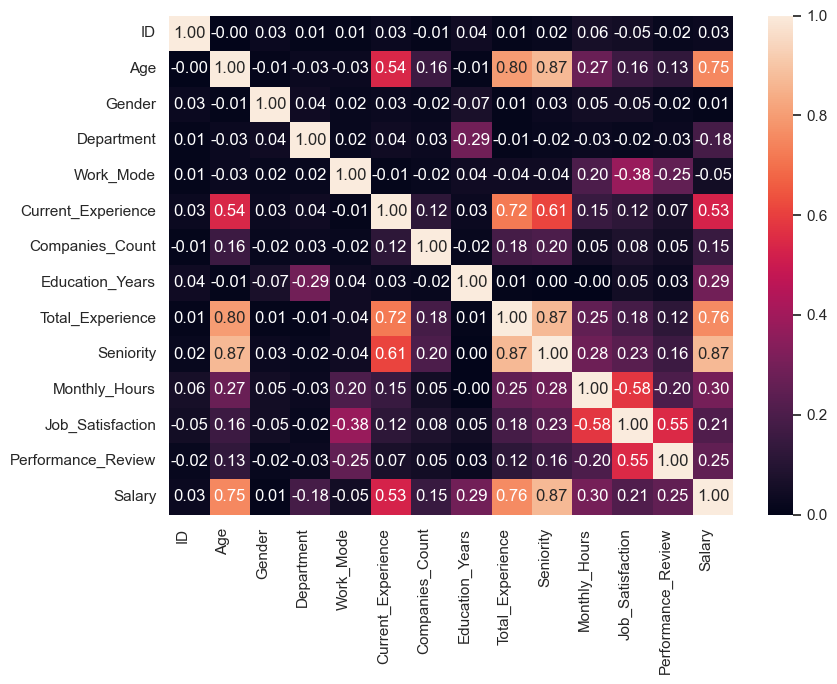

ID   Age  Gender  Department  Work_Mode  \
ID                  1.00 -0.00    0.03        0.01       0.01   
Age                -0.00  1.00   -0.01       -0.03      -0.03   
Gender              0.03 -0.01    1.00        0.04       0.02   
Department          0.01 -0.03    0.04        1.00       0.02   
Work_Mode           0.01 -0.03    0.02        0.02       1.00   
Current_Experience  0.03  0.54    0.03        0.04      -0.01   
Companies_Count    -0.01  0.16   -0.02        0.03      -0.02   
Education_Years     0.04 -0.01   -0.07       -0.29       0.04   
Total_Experience    0.01  0.80    0.01       -0.01      -0.04   
Seniority           0.02  0.87    0.03       -0.02      -0.04   
Monthly_Hours       0.06  0.27    0.05       -0.03       0.20   
Job_Satisfaction   -0.05  0.16   -0.05       -0.02      -0.38   
Performance_Review -0.02  0.13   -0.02       -0.03      -0.25   
Salary              0.03  0.75    0.01       -0.18      -0.05   

                    Current_Experience  Companies_Count  Education_Years  \
ID                                0.03            -0.01             0.04   
Age                               0.54             0.16            -0.01   
Gender                            0.03            -0.02            -0.07   
Department                        0.04             0.03            -0.29   
Work_Mode                        -0.01            -0.02             0.04   
Current_Experience                1.00             0.12             0.03   
Companies_Count                   0.12             1.00            -0.02   
Education_Years                   0.03            -0.02             1.00   
Total_Experience                  0.72             0.18             0.01   
Seniority                         0.61             0.20             0.00   
Monthly_Hours                     0.15             0.05            -0.00   
Job_Satisfaction                  0.12             0.08             0.05   
Performance_Review                0.07             0.05             0.03   
Salary                            0.53             0.15             0.29   

                    Total_Experience  Seniority  Monthly_Hours  \
ID                              0.01       0.02           0.06   
Age                             0.80       0.87           0.27   
Gender                          0.01       0.03           0.05   
Department                     -0.01      -0.02          -0.03   
Work_Mode                      -0.04      -0.04           0.20   
Current_Experience              0.72       0.61           0.15   
Companies_Count                 0.18       0.20           0.05   
Education_Years                 0.01       0.00          -0.00   
Total_Experience                1.00       0.87           0.25   
Seniority                       0.87       1.00           0.28   
Monthly_Hours                   0.25       0.28           1.00   
Job_Satisfaction                0.18       0.23          -0.58   
Performance_Review              0.12       0.16          -0.20   
Salary                          0.76       0.87           0.30   

                    Job_Satisfaction  Performance_Review  Salary  
ID                             -0.05               -0.02    0.03  
Age                             0.16                0.13    0.75  
Gender                         -0.05               -0.02    0.01  
Department                     -0.02               -0.03   -0.18  
Work_Mode                      -0.38               -0.25   -0.05  
Current_Experience              0.12                0.07    0.53  
Companies_Count                 0.08                0.05    0.15  
Education_Years                 0.05                0.03    0.29  
Total_Experience                0.18                0.12    0.76  
Seniority                       0.23                0.16    0.87  
Monthly_Hours                  -0.58               -0.20    0.30  
Job_Satisfaction                1.00                0.55    0.21  
Performance_Review              0.55       

In [52]:
correlation_matrix(data, figsize=(9, 7))

<h3 dir="rtl" align="right">
השלמת ערכים חסרים לפי שכיח בהסתמך על קורלציות
</h3>

In [54]:
def fill_with_mode(df, group_cols_hierarchy, target_col):
    print(f"--- Starting Pyramid for {target_col} ---")
    
    relevant_cols = list(set([c for sublist in group_cols_hierarchy for c in sublist] + [target_col]))
    df_non_null = df.filter(F.col(target_col).isNotNull()).select(relevant_cols).cache()

    try:
        global_mode_row = df_non_null.groupBy(target_col).count().orderBy(F.desc("count")).limit(1).collect()
        global_mode_val = global_mode_row[0][target_col] if global_mode_row else None
        
        working_df = df
        
        for i, group_cols in enumerate(group_cols_hierarchy, 1):
            null_count = working_df.filter(F.col(target_col).isNull()).count()
            print(f"  Level {i}: Current NULL count: {null_count}")
            
            if null_count == 0:
                print(f"  {target_col} is already full. Skipping remaining levels.")
                break
                
            print(f"  Level {i}: Processing group {group_cols}")
            mode_col_name = f"tmp_m{i}"
            
            group_mode_df = df_non_null.groupBy(group_cols + [target_col]).count() \
                .withColumn("rn", F.row_number().over(Window.partitionBy(group_cols).orderBy(F.desc("count")))) \
                .filter(F.col("rn") == 1) \
                .select(group_cols + [F.col(target_col).alias(mode_col_name)])
            
            working_df = working_df.join(F.broadcast(group_mode_df), on=group_cols, how="left")
            working_df = working_df.withColumn(target_col, F.coalesce(F.col(target_col), F.col(mode_col_name)))
            working_df = working_df.drop(mode_col_name)

        final_null_before_global = working_df.filter(F.col(target_col).isNull()).count()
        
        if final_null_before_global > 0 and global_mode_val is not None:
            print(f"  Final Level: Filling remaining {final_null_before_global} NULLs with global mode: {global_mode_val}")
            working_df = working_df.withColumn(target_col, F.coalesce(F.col(target_col), F.lit(global_mode_val)))
        
        print(f"--- Finished {target_col}: 0 NULLs remaining ---")
        
        working_df = working_df.localCheckpoint()
        return working_df

    finally:
        df_non_null.unpersist()

<h3 dir="rtl" align="right">
גיל
</h3>

In [56]:
dfnum = fill_with_mode(dfnum, [
    ["Seniority", "Education_Years", "Current_Experience", "Total_Experience"],
    ["Seniority", "Education_Years", "Current_Experience"],
    ["Seniority", "Education_Years"],
    ["Seniority"],
    ["Education_Years"],
    ["Current_Experience"],
    ["Total_Experience"]
], "Age")

--- Starting Pyramid for Age ---
  Level 1: Current NULL count: 291
  Level 1: Processing group ['Seniority', 'Education_Years', 'Current_Experience', 'Total_Experience']
  Level 2: Current NULL count: 291
  Level 2: Processing group ['Seniority', 'Education_Years', 'Current_Experience']
  Level 3: Current NULL count: 291
  Level 3: Processing group ['Seniority', 'Education_Years']
  Level 4: Current NULL count: 291
  Level 4: Processing group ['Seniority']
  Level 5: Current NULL count: 6
  Level 5: Processing group ['Education_Years']
  Level 6: Current NULL count: 6
  Level 6: Processing group ['Current_Experience']
  Level 7: Current NULL count: 0
  Age is already full. Skipping remaining levels.
--- Finished Age: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
מגדר
</h3>

In [58]:
dfnum = fill_with_mode(dfnum, [
    ["Department", "Performance_Review", "Total_Experience", "Education_Years"],
    ["Department", "Performance_Review", "Total_Experience"],
    ["Department", "Performance_Review"],
    ["Department"],
    ["Performance_Review"],
    ["Total_Experience"],
    ["Education_Years"]
], "Gender")

--- Starting Pyramid for Gender ---
  Level 1: Current NULL count: 155
  Level 1: Processing group ['Department', 'Performance_Review', 'Total_Experience', 'Education_Years']
  Level 2: Current NULL count: 47
  Level 2: Processing group ['Department', 'Performance_Review', 'Total_Experience']
  Level 3: Current NULL count: 22
  Level 3: Processing group ['Department', 'Performance_Review']
  Level 4: Current NULL count: 5
  Level 4: Processing group ['Department']
  Level 5: Current NULL count: 3
  Level 5: Processing group ['Performance_Review']
  Level 6: Current NULL count: 0
  Gender is already full. Skipping remaining levels.
--- Finished Gender: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
מודל עבודה
</h3>

In [60]:
dfnum = fill_with_mode(dfnum, [
    ["Education_Years", "Seniority", "Job_Satisfaction", "Department"],
    ["Education_Years", "Seniority", "Department"],
    ["Education_Years", "Department"],
    ["Education_Years"],
    ["Seniority"],
    ["Job_Satisfaction"],
    ["Department"]    
], "Work_Mode")

--- Starting Pyramid for Work_Mode ---
  Level 1: Current NULL count: 247
  Level 1: Processing group ['Education_Years', 'Seniority', 'Job_Satisfaction', 'Department']
  Level 2: Current NULL count: 24
  Level 2: Processing group ['Education_Years', 'Seniority', 'Department']
  Level 3: Current NULL count: 18
  Level 3: Processing group ['Education_Years', 'Department']
  Level 4: Current NULL count: 15
  Level 4: Processing group ['Education_Years']
  Level 5: Current NULL count: 11
  Level 5: Processing group ['Seniority']
  Level 6: Current NULL count: 0
  Work_Mode is already full. Skipping remaining levels.
--- Finished Work_Mode: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
וותק בחברה הנוכחית 
</h3>

In [62]:
dfnum = fill_with_mode(dfnum, [
    ["Total_Experience", "Seniority", "Age", "Monthly_Hours"],
    ["Total_Experience", "Seniority", "Age"],
    ["Total_Experience", "Age"],
    ["Total_Experience", "Seniority"],
    ["Total_Experience"],
    ["Seniority"],
    ["Age"],
], "Current_Experience")

--- Starting Pyramid for Current_Experience ---
  Level 1: Current NULL count: 437
  Level 1: Processing group ['Total_Experience', 'Seniority', 'Age', 'Monthly_Hours']
  Level 2: Current NULL count: 376
  Level 2: Processing group ['Total_Experience', 'Seniority', 'Age']
  Level 3: Current NULL count: 235
  Level 3: Processing group ['Total_Experience', 'Age']
  Level 4: Current NULL count: 223
  Level 4: Processing group ['Total_Experience', 'Seniority']
  Level 5: Current NULL count: 201
  Level 5: Processing group ['Total_Experience']
  Level 6: Current NULL count: 201
  Level 6: Processing group ['Seniority']
  Level 7: Current NULL count: 6
  Level 7: Processing group ['Age']
--- Finished Current_Experience: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
מספר חברות בהן עבד
</h3>

In [64]:
dfnum = fill_with_mode(dfnum, [
    ["Seniority", "Total_Experience", "Current_Experience", "Salary"],
    ["Seniority", "Total_Experience", "Current_Experience"],
    ["Seniority", "Total_Experience"],
    ["Total_Experience", "Current_Experience"],
    ["Seniority"],
    ["Total_Experience"],
    ["Current_Experience"]
], "Companies_Count")

--- Starting Pyramid for Companies_Count ---
  Level 1: Current NULL count: 1731
  Level 1: Processing group ['Seniority', 'Total_Experience', 'Current_Experience', 'Salary']
  Level 2: Current NULL count: 830
  Level 2: Processing group ['Seniority', 'Total_Experience', 'Current_Experience']
  Level 3: Current NULL count: 61
  Level 3: Processing group ['Seniority', 'Total_Experience']
  Level 4: Current NULL count: 59
  Level 4: Processing group ['Total_Experience', 'Current_Experience']
  Level 5: Current NULL count: 13
  Level 5: Processing group ['Seniority']
  Level 6: Current NULL count: 2
  Level 6: Processing group ['Total_Experience']
  Level 7: Current NULL count: 2
  Level 7: Processing group ['Current_Experience']
--- Finished Companies_Count: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
וותק כללי
</h3>

In [66]:
dfnum = fill_with_mode(dfnum, [
    ["Seniority", "Age", "Current_Experience", "Salary"],
    ["Seniority", "Age", "Current_Experience"],
    ["Seniority", "Current_Experience"],
    ["Seniority", "Age"],
    ["Seniority"],
    ["Age"],
], "Total_Experience")

--- Starting Pyramid for Total_Experience ---
  Level 1: Current NULL count: 972
  Level 1: Processing group ['Seniority', 'Age', 'Current_Experience', 'Salary']
  Level 2: Current NULL count: 897
  Level 2: Processing group ['Seniority', 'Age', 'Current_Experience']
  Level 3: Current NULL count: 369
  Level 3: Processing group ['Seniority', 'Current_Experience']
  Level 4: Current NULL count: 24
  Level 4: Processing group ['Seniority', 'Age']
  Level 5: Current NULL count: 24
  Level 5: Processing group ['Seniority']
  Level 6: Current NULL count: 24
  Level 6: Processing group ['Age']
--- Finished Total_Experience: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
בכירות
</h3>

In [68]:
dfnum = fill_with_mode(dfnum, [
    ["Total_Experience", "Current_Experience", "Age", "Salary"],
    ["Total_Experience", "Current_Experience", "Age"],
    ["Total_Experience", "Current_Experience"],
    ["Total_Experience", "Age"],
    ["Total_Experience"]], "Seniority")

--- Starting Pyramid for Seniority ---
  Level 1: Current NULL count: 235
  Level 1: Processing group ['Total_Experience', 'Current_Experience', 'Age', 'Salary']
  Level 2: Current NULL count: 217
  Level 2: Processing group ['Total_Experience', 'Current_Experience', 'Age']
  Level 3: Current NULL count: 51
  Level 3: Processing group ['Total_Experience', 'Current_Experience']
  Level 4: Current NULL count: 12
  Level 4: Processing group ['Total_Experience', 'Age']
  Level 5: Current NULL count: 0
  Seniority is already full. Skipping remaining levels.
--- Finished Seniority: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
שעות עבודה חודשיות
</h3>

In [70]:
dfnum = fill_with_mode(dfnum, [
    ["Job_Satisfaction", "Performance_Review", "Seniority", "Age"],
    ["Job_Satisfaction", "Performance_Review", "Seniority"],
    ["Job_Satisfaction", "Performance_Review"],
    ["Job_Satisfaction"],
    ["Performance_Review"],    
], "Monthly_Hours")

--- Starting Pyramid for Monthly_Hours ---
  Level 1: Current NULL count: 253
  Level 1: Processing group ['Job_Satisfaction', 'Performance_Review', 'Seniority', 'Age']
  Level 2: Current NULL count: 25
  Level 2: Processing group ['Job_Satisfaction', 'Performance_Review', 'Seniority']
  Level 3: Current NULL count: 15
  Level 3: Processing group ['Job_Satisfaction', 'Performance_Review']
  Level 4: Current NULL count: 15
  Level 4: Processing group ['Job_Satisfaction']
  Level 5: Current NULL count: 9
  Level 5: Processing group ['Performance_Review']
--- Finished Monthly_Hours: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
שביעות רצון מהעבודה
</h3>

In [72]:
dfnum = fill_with_mode(dfnum, [
    ["Performance_Review", "Work_Mode", "Monthly_Hours"],
    ["Performance_Review", "Work_Mode"],
    ["Performance_Review"],
    ["Work_Mode"]
], "Job_Satisfaction")

--- Starting Pyramid for Job_Satisfaction ---
  Level 1: Current NULL count: 305
  Level 1: Processing group ['Performance_Review', 'Work_Mode', 'Monthly_Hours']
  Level 2: Current NULL count: 11
  Level 2: Processing group ['Performance_Review', 'Work_Mode']
  Level 3: Current NULL count: 8
  Level 3: Processing group ['Performance_Review']
  Level 4: Current NULL count: 8
  Level 4: Processing group ['Work_Mode']
--- Finished Job_Satisfaction: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
חוות דעת
</h3>

In [74]:
dfnum = fill_with_mode(dfnum, [
    ["Job_Satisfaction", "Work_Mode"],
    ["Job_Satisfaction"]], "Performance_Review")

--- Starting Pyramid for Performance_Review ---
  Level 1: Current NULL count: 227
  Level 1: Processing group ['Job_Satisfaction', 'Work_Mode']
  Level 2: Current NULL count: 0
  Performance_Review is already full. Skipping remaining levels.
--- Finished Performance_Review: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
בחינה חוזרת של הנתונים שנותרו לאחר השלמת ראשונה
</h3>

In [76]:
check_df(dfnum)

Dataset Shape: (10000, 14)
Total rows with at least one NULL: 891 (8.91%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
Job_Satisfaction               double          10000        0            0.0        5         
Work_Mode                      int             10000        0            0.0        3         
Performance_Review             double          10000        0            0.0        5         
Monthly_Hours                  double          10000        0            0.0        100       
Seniority                      int             10000        0            0.0        4         
Age                            double          10000        0            0.0        44        
Total_Experience               double          10000        0            0.0        36        
Current_Experience             double          10000        0    

In [77]:
show_describe(dfnum, decimals=2, pandas=True, transpose=True)

summary               count      mean   stddev     min      25%      50%  \
Job_Satisfaction    10000.0      3.38     1.19     1.0      3.0      3.0   
Work_Mode           10000.0      2.21     0.74     1.0      2.0      2.0   
Performance_Review  10000.0      7.54     1.19     6.0      7.0      7.0   
Monthly_Hours       10000.0    174.37    16.12   124.0    163.0    173.0   
Seniority           10000.0      2.26     0.95     1.0      2.0      2.0   
Age                 10000.0     36.41     9.30    22.0     29.0     36.0   
Total_Experience    10000.0     11.21     8.24     0.0      5.0     10.0   
Current_Experience  10000.0      7.14     7.73     0.0      1.0      5.0   
Salary               9817.0  19967.67  9525.23  6300.0  12400.0  18500.0   
Education_Years      9422.0     15.71     1.92    12.0     15.0     16.0   
Department           9856.0      4.05     2.01     1.0      2.0      4.0   
ID                  10000.0   5000.50  2886.90     1.0   2499.0   4999.0   
Gender              10000.0      1.44     0.50     1.0      1.0      1.0   
Companies_Count     10000.0      2.88     2.31     0.0      1.0      3.0   

summary                 75%      max     mode  mode_freq%  
Job_Satisfaction        4.0      5.0      3.0       28.08  
Work_Mode               3.0      3.0      3.0       40.53  
Performance_Review      8.0     10.0      7.0       27.47  
Monthly_Hours         185.0    225.0    173.0        2.87  
Seniority               3.0      4.0      2.0       38.10  
Age                    42.0     65.0     28.0        6.73  
Total_Experience       16.0     35.0     10.0        6.91  
Current_Experience     10.0     31.0      0.0       16.00  
Salary              26100.0  49800.0  11900.0        0.90  
Education_Years        17.0     21.0     15.0       20.50  
Department              6.0      7.0      6.0       15.15  
ID                   7499.0  10000.0      8.0        0.01  
Gender                  2.0      2.0      1.0       55.91  
Companies_Count         5.0      7.0      0.0       20.70

Generating graphs for 13 columns (Total rows: 10000)...


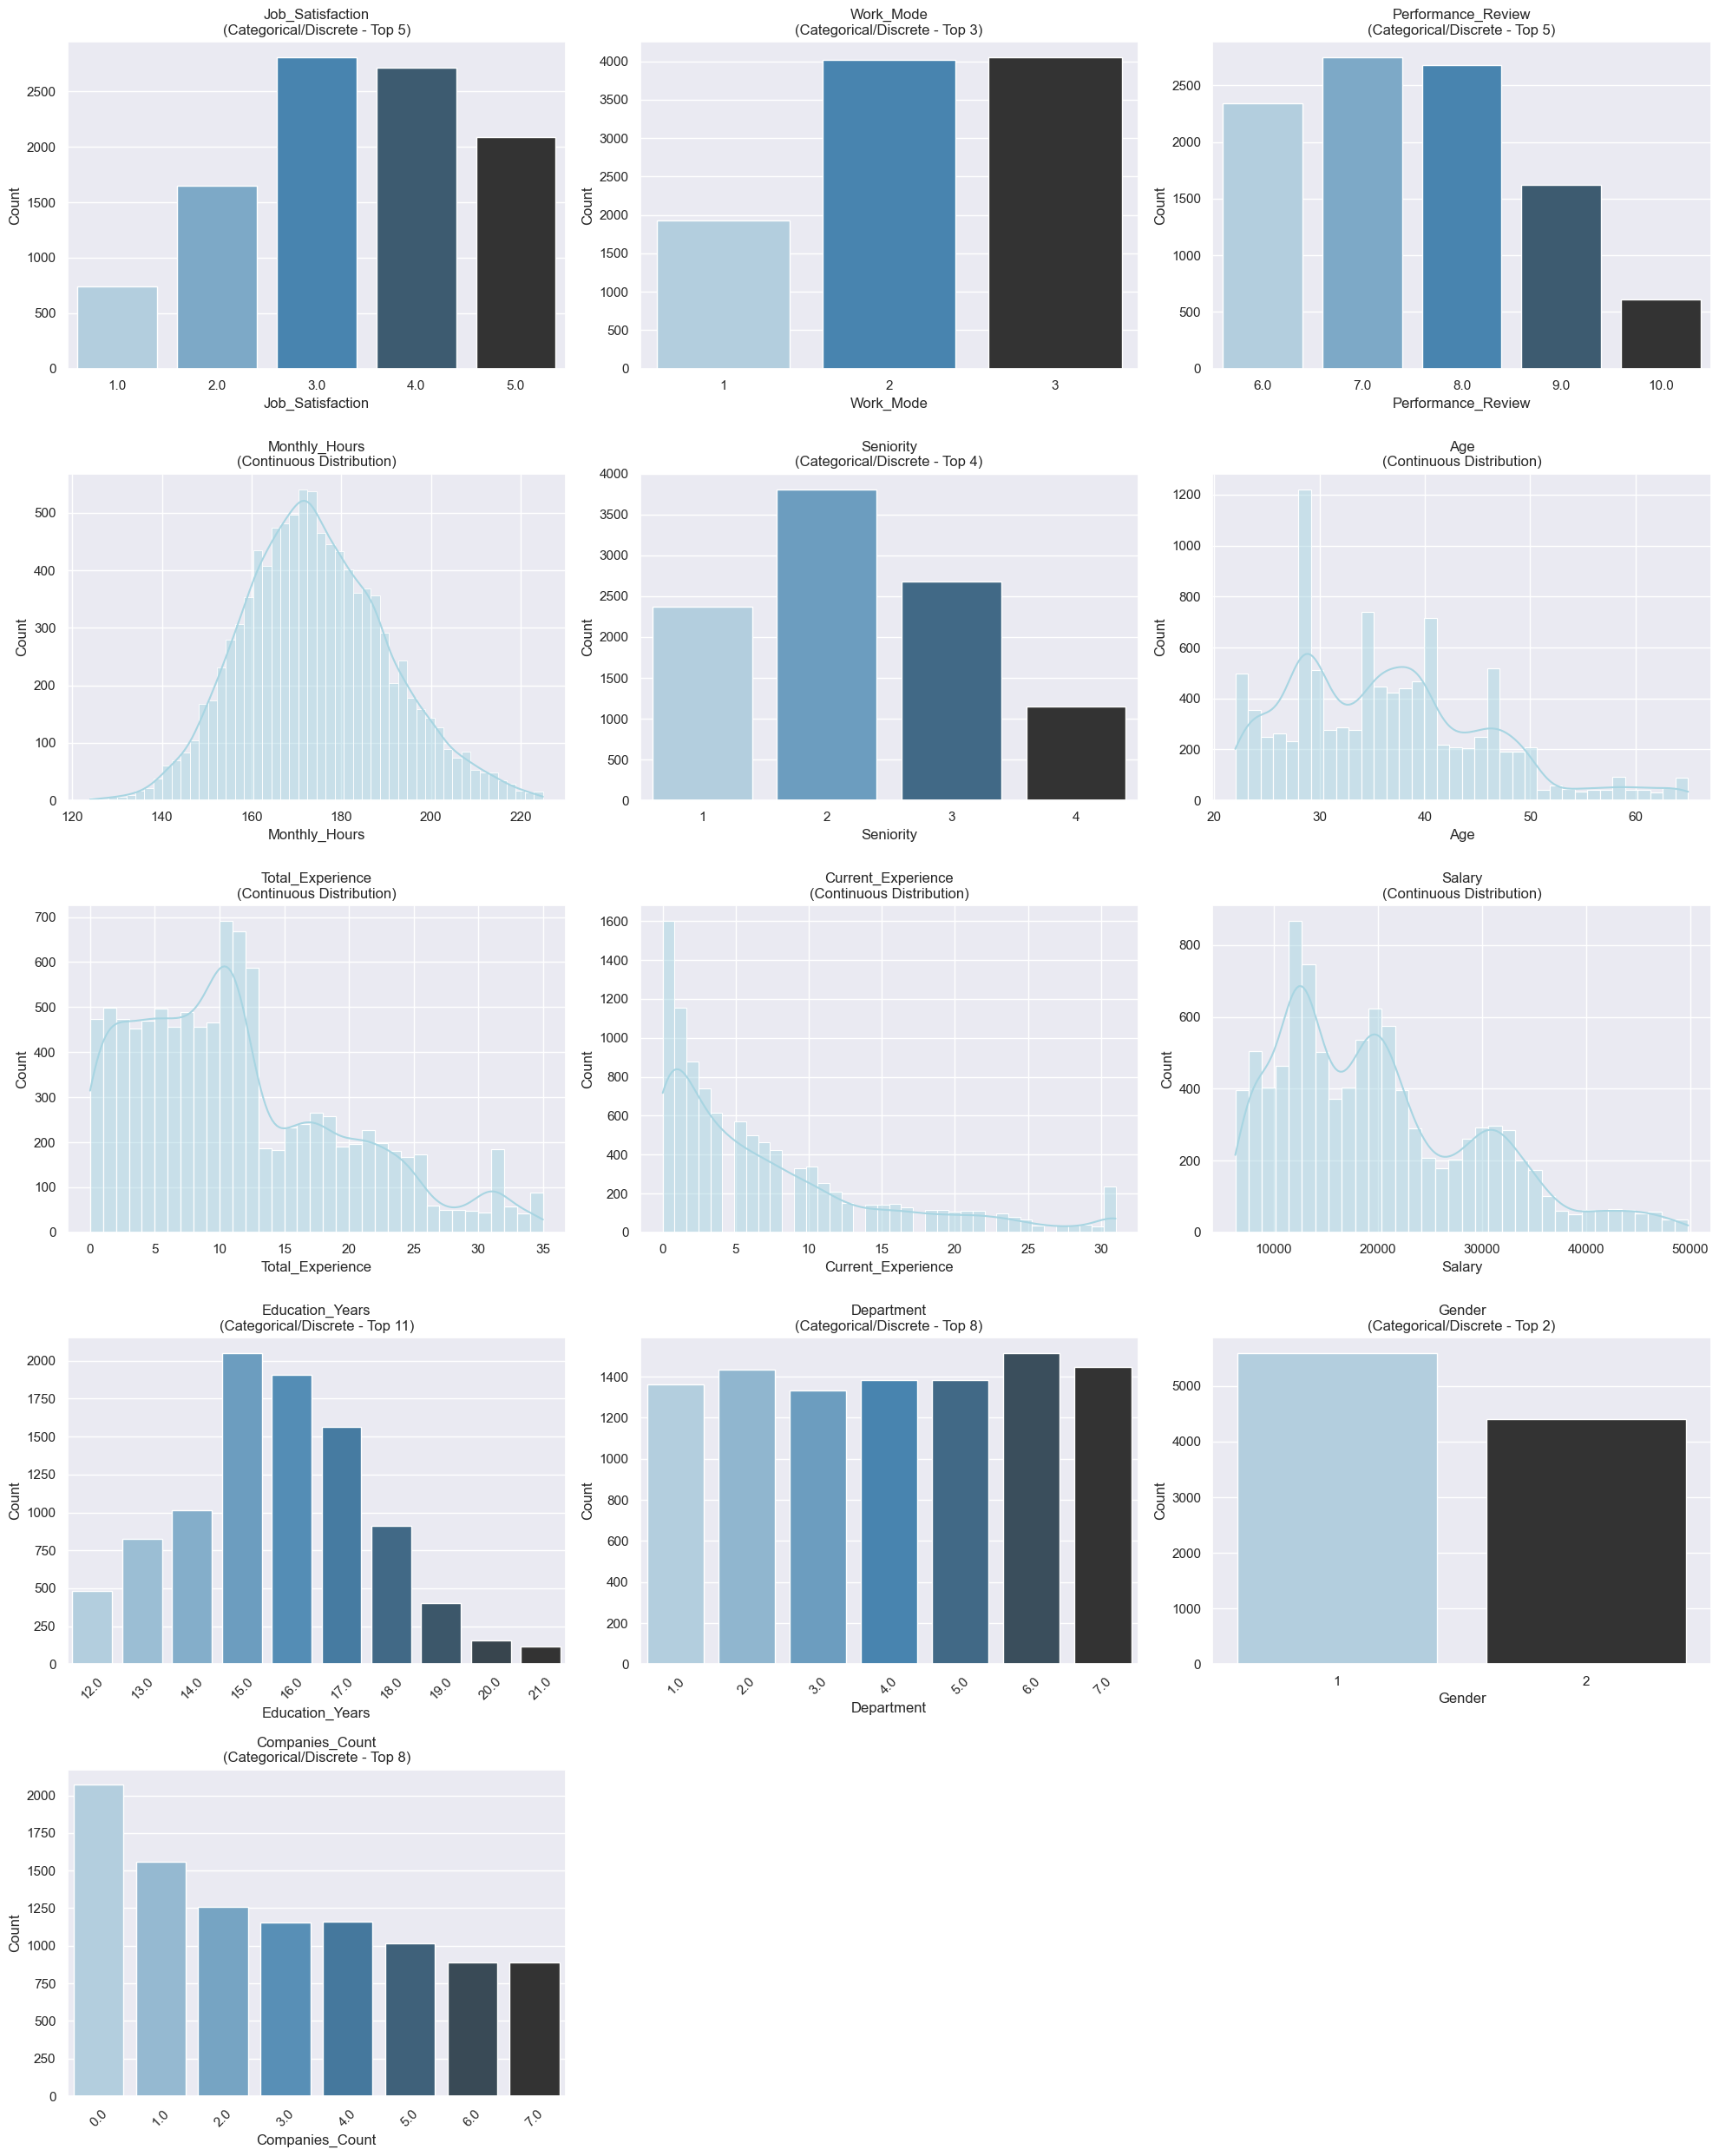

In [78]:
graph_stats(dfnum)

<h3 dir="rtl" align="right">
השלמת ערכים ברשומות בהן חסרה יותר מעמודה אחת
</h3>

In [80]:
(dfnum
    .withColumn("null_count", reduce(add, [when(col(c).isNull(), 1).otherwise(0) for c in dfnum.columns]))
    .filter(col("null_count") >= 2)
    .agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in dfnum.columns])
    .collect()[0]
    .asDict()) 

{'Job_Satisfaction': 0,
 'Work_Mode': 0,
 'Performance_Review': 0,
 'Monthly_Hours': 0,
 'Seniority': 0,
 'Age': 0,
 'Total_Experience': 0,
 'Current_Experience': 0,
 'Salary': 8,
 'Education_Years': 13,
 'Department': 7,
 'ID': 0,
 'Gender': 0,
 'Companies_Count': 0}

In [81]:
null_count = reduce(add, [F.when(F.col(c).isNull(), 1).otherwise(0) for c in dfnum.columns])
dfnum.filter(null_count >= 2).count()

14

In [82]:
dfnum = (dfnum
    .withColumn("nulls", reduce(add, [when(col(c).isNull(), 1).otherwise(0) for c in dfnum.columns]))
    .join(dfnum.groupBy("Department").agg(mode("Education_Years").alias("edu_mode")), on="Department", how="left")
    .withColumn("Education_Years", when(col("nulls") >= 2, coalesce(col("Education_Years"), col("edu_mode"))).otherwise(col("Education_Years")))
    .drop("edu_mode", "nulls"))

(dfnum
    .withColumn("null_count", reduce(add, [when(col(c).isNull(), 1).otherwise(0) for c in dfnum.columns]))
    .filter(col("null_count") >= 2)
    .agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in dfnum.columns])
    .collect()[0]
    .asDict())

{'Department': 7,
 'Job_Satisfaction': 0,
 'Work_Mode': 0,
 'Performance_Review': 0,
 'Monthly_Hours': 0,
 'Seniority': 0,
 'Age': 0,
 'Total_Experience': 0,
 'Current_Experience': 0,
 'Salary': 1,
 'Education_Years': 6,
 'ID': 0,
 'Gender': 0,
 'Companies_Count': 0}

In [83]:
dfnum = (dfnum
    .withColumn("nulls", reduce(add, [when(col(c).isNull(), 1).otherwise(0) for c in dfnum.columns]))
    .join(dfnum.groupBy("Gender").agg(mode("Department").alias("dept_mode")), on="Gender", how="left")
    .withColumn("Department", when(col("nulls") >= 2, coalesce(col("Department"), col("dept_mode"))).otherwise(col("Department")))
    .drop("dept_mode", "nulls"))

(dfnum
    .withColumn("null_count", reduce(add, [when(col(c).isNull(), 1).otherwise(0) for c in dfnum.columns]))
    .filter(col("null_count") >= 2)
    .agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in dfnum.columns])
    .collect()[0]
    .asDict())

{'Gender': None,
 'Department': None,
 'Job_Satisfaction': None,
 'Work_Mode': None,
 'Performance_Review': None,
 'Monthly_Hours': None,
 'Seniority': None,
 'Age': None,
 'Total_Experience': None,
 'Current_Experience': None,
 'Salary': None,
 'Education_Years': None,
 'ID': None,
 'Companies_Count': None}

<h3 dir="rtl" align="right">
בחינה חוזרת של הנתונים שנותרו לאחר השלמת שנייה
</h3>

In [85]:
check_df(dfnum)

Dataset Shape: (10000, 14)
Total rows with at least one NULL: 891 (8.91%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
Gender                         int             10000        0            0.0        2         
Department                     int             9863         137          1.37       7         
Job_Satisfaction               double          10000        0            0.0        5         
Work_Mode                      int             10000        0            0.0        3         
Performance_Review             double          10000        0            0.0        5         
Monthly_Hours                  double          10000        0            0.0        100       
Seniority                      int             10000        0            0.0        4         
Age                            double          10000        0    

In [86]:
show_describe(dfnum, decimals=2, pandas=True, transpose=True)

summary               count      mean   stddev     min      25%      50%  \
Gender              10000.0      1.44     0.50     1.0      1.0      1.0   
Department           9863.0      4.05     2.01     1.0      2.0      4.0   
Job_Satisfaction    10000.0      3.38     1.19     1.0      3.0      3.0   
Work_Mode           10000.0      2.21     0.74     1.0      2.0      2.0   
Performance_Review  10000.0      7.54     1.19     6.0      7.0      7.0   
Monthly_Hours       10000.0    174.37    16.12   124.0    163.0    173.0   
Seniority           10000.0      2.26     0.95     1.0      2.0      2.0   
Age                 10000.0     36.41     9.30    22.0     29.0     36.0   
Total_Experience    10000.0     11.21     8.24     0.0      5.0     10.0   
Current_Experience  10000.0      7.14     7.73     0.0      1.0      5.0   
Salary               9817.0  19967.67  9525.23  6300.0  12400.0  18500.0   
Education_Years      9429.0     15.71     1.92    12.0     15.0     16.0   
ID                  10000.0   5000.50  2886.90     1.0   2499.0   4999.0   
Companies_Count     10000.0      2.88     2.31     0.0      1.0      3.0   

summary                 75%      max     mode  mode_freq%  
Gender                  2.0      2.0      1.0       55.91  
Department              6.0      7.0      6.0       15.22  
Job_Satisfaction        4.0      5.0      3.0       28.08  
Work_Mode               3.0      3.0      3.0       40.53  
Performance_Review      8.0     10.0      7.0       27.47  
Monthly_Hours         185.0    225.0    173.0        2.87  
Seniority               3.0      4.0      2.0       38.10  
Age                    42.0     65.0     28.0        6.73  
Total_Experience       16.0     35.0     10.0        6.91  
Current_Experience     10.0     31.0      0.0       16.00  
Salary              26100.0  49800.0  11900.0        0.90  
Education_Years        17.0     21.0     15.0       20.51  
ID                   7499.0  10000.0     14.0        0.01  
Companies_Count         5.0      7.0      0.0       20.70

Generating graphs for 13 columns (Total rows: 10000)...


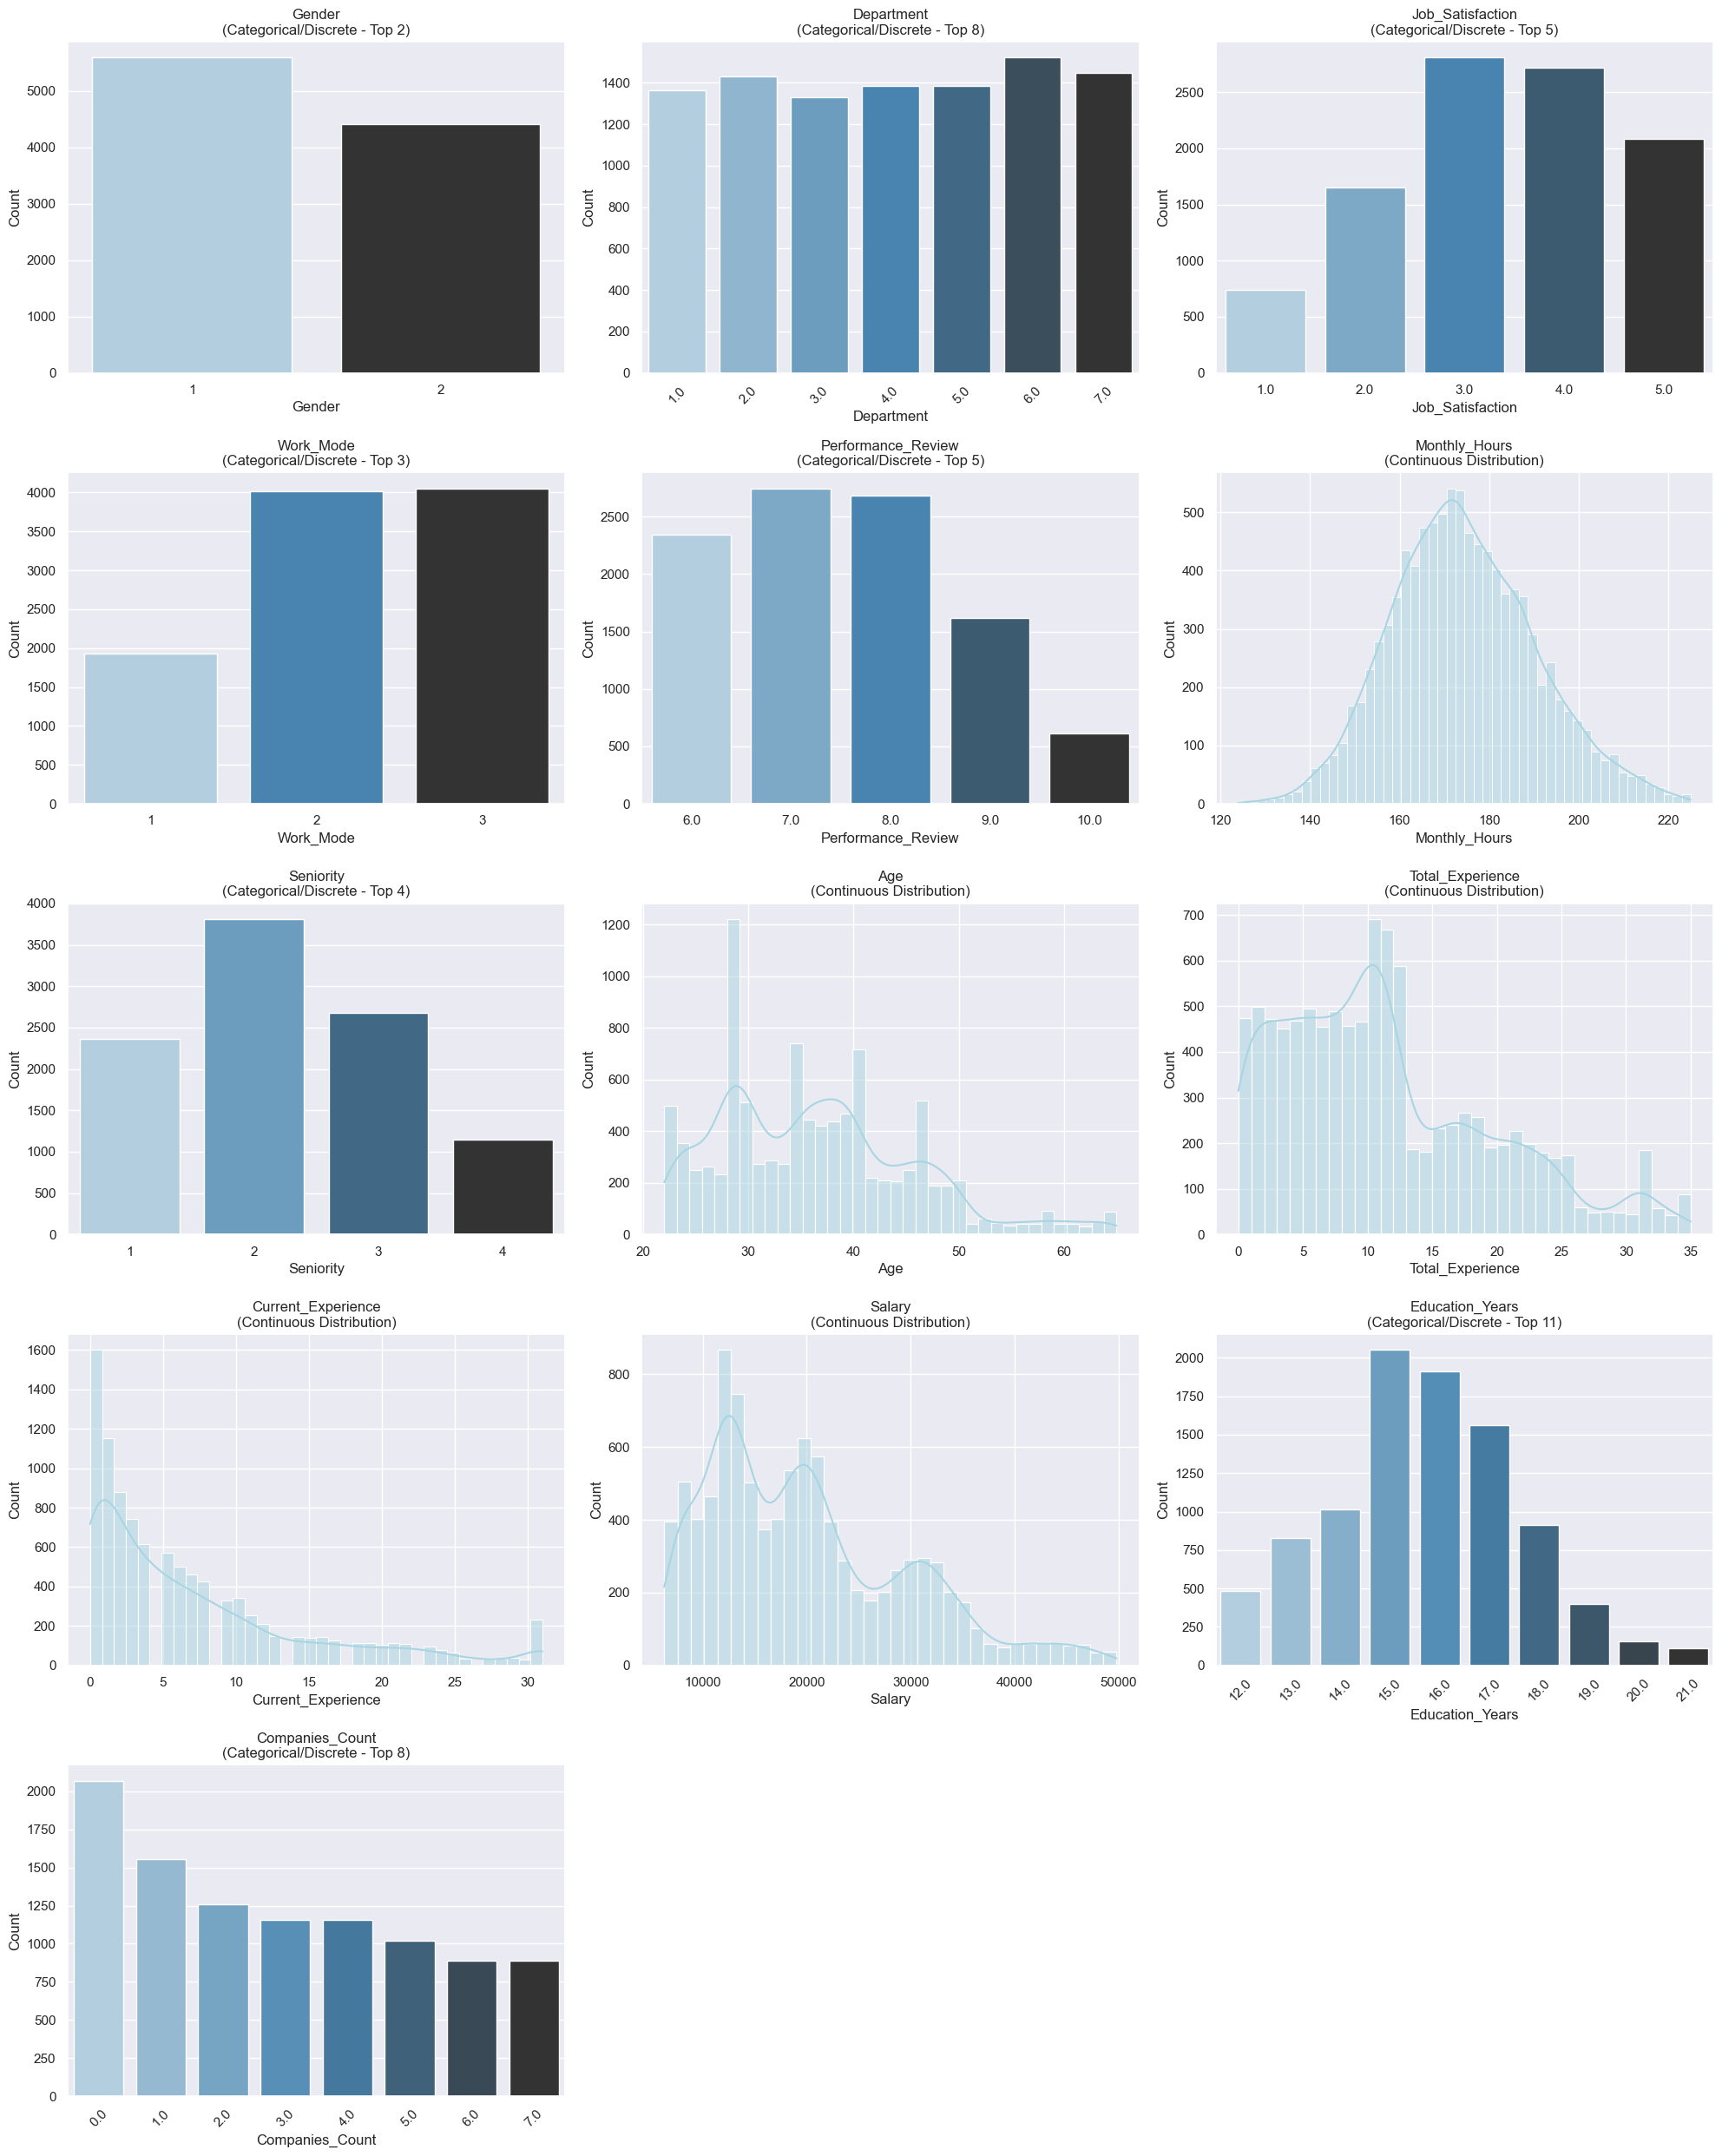

In [87]:
graph_stats(dfnum)

<h3 dir="rtl" align="right">
הכנת הנתונים להרצת המודלים
</h3>

In [89]:
df_clean = dfnum.dropna()
print(f"data clean: {df_clean.count():,}")

train_df, val_df = df_clean.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_df.count():,}")
print(f"Validation: {val_df.count():,}")

test_df = dfnum.subtract(df_clean)
print(f"Test (NULL Data): {test_df.count():,}")

data clean: 9,109
Train: 7,364
Validation: 1,745
Test (NULL Data): 891


In [90]:
salary_test_df = test_df.filter(col("Salary").isNull())
print(f"Salary Test (NULL Data): {salary_test_df.count():,}")

Salary Test (NULL Data): 183


<h3 dir="rtl" align="right">
הרצת מודלי רגרסיה להשלמת ערכי שכר חסרים
</h3>

In [92]:
def evaluate_regression_models(train_data, test_data, features_col="features", label_col="Salary"):
    models = [
        ("Linear Regression", LinearRegression(featuresCol=features_col, labelCol=label_col)),
        ("Decision Tree", DecisionTreeRegressor(featuresCol=features_col, labelCol=label_col, seed=42)),
        ("Random Forest", RandomForestRegressor(featuresCol=features_col, labelCol=label_col, seed=42)),
        ("Gradient Boosting", GBTRegressor(featuresCol=features_col, labelCol=label_col, seed=42))]
    
    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
    
    evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae") 
    
    results = []
    print(f"--- Evaluating models for target: {label_col} ---")
    
    for model_name, model in models:
        print(f"Training {model_name}...")
        fitted_model = model.fit(train_data)
        predictions = fitted_model.transform(test_data)
        
        r2 = evaluator_r2.evaluate(predictions)
        rmse = evaluator_rmse.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions) 
        
        results.append({"Model": model_name, "R2": r2, "RMSE": rmse, "MAE": mae})
        
    return pd.DataFrame(results).sort_values(by="R2", ascending=False)

In [93]:
input_cols_salary = [
    "Age", "Gender", "Department", "Work_Mode", "Current_Experience", 
    "Companies_Count", "Education_Years", "Total_Experience", 
    "Seniority", "Monthly_Hours", "Job_Satisfaction", "Performance_Review"
]
print(f"Using columns: {input_cols_salary}")
assembler_salary = VectorAssembler(inputCols=input_cols_salary, outputCol="features")
train_vec_salary = assembler_salary.transform(train_df)
val_vec_salary = assembler_salary.transform(val_df)
test_vec_salary = assembler_salary.transform(salary_test_df)
print("Data preparation for Salary complete.")

Using columns: ['Age', 'Gender', 'Department', 'Work_Mode', 'Current_Experience', 'Companies_Count', 'Education_Years', 'Total_Experience', 'Seniority', 'Monthly_Hours', 'Job_Satisfaction', 'Performance_Review']
Data preparation for Salary complete.


In [94]:
print("Comparison results for Salary:")
salary_results = evaluate_regression_models(train_vec_salary, val_vec_salary, label_col="Salary")
print(salary_results)

Comparison results for Salary:
--- Evaluating models for target: Salary ---
Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
               Model        R2         RMSE          MAE
3  Gradient Boosting  0.986139  1109.065469   641.356324
1      Decision Tree  0.966760  1717.460940  1122.301628
2      Random Forest  0.941887  2270.880568  1567.210097
0  Linear Regression  0.889611  3129.829979  2449.469371


In [95]:
print("--- Predicting Salary on test set ---")
gbt = GBTRegressor(featuresCol="features", labelCol="Salary", seed=42)
final_model_salary = gbt.fit(train_vec_salary)
predictions_salary = final_model_salary.transform(test_vec_salary)

--- Predicting Salary on test set ---


<h3 dir="rtl" align="right">
הרצת מודלי קלסיפיקציה להשלמת ערכי מחלקה ושנות לימוד חסרים
</h3>

In [97]:
def evaluate_classification_models(train_data, test_data, features_col="features", label_col="Department"):
    num_classes = train_data.select(label_col).distinct().count()
    
    models = [
        ("Logistic Regression", LogisticRegression(featuresCol=features_col, labelCol=label_col, maxIter=100)),
        ("Decision Tree", DecisionTreeClassifier(featuresCol=features_col, labelCol=label_col, seed=42)),
        ("Random Forest", RandomForestClassifier(featuresCol=features_col, labelCol=label_col, seed=42, numTrees=50))]
    
    print(f"--- Number of classes: {num_classes} ---\n")
    
    for model_name, model in models:
        print(f"--- MODEL: {model_name} ---")
        
        try:
            fitted_model = model.fit(train_data)
            predictions = fitted_model.transform(test_data)
            
            pred_labels = predictions.select(label_col, "prediction").toPandas()
            y_true = pred_labels[label_col].values
            y_pred = pred_labels["prediction"].values
            
            print(classification_report(y_true, y_pred, zero_division=0))
            
            print("Confusion Matrix:")
            cm = confusion_matrix(y_true, y_pred)
            print(cm)
            
        except Exception as e:
            print(f"FAILED: {str(e)[:200]}")
        
        print()

<h3 dir="rtl" align="right">
מחלקה
</h3>

In [99]:
department_test_df = test_df.filter(col("Department").isNull())
print(f"Department Test (NULL Data): {department_test_df.count():,}")

Department Test (NULL Data): 137


In [100]:
input_cols_dept = [
    "Age", "Gender", "Work_Mode", "Current_Experience", 
    "Companies_Count", "Education_Years", "Total_Experience", 
    "Seniority", "Monthly_Hours", "Job_Satisfaction", "Performance_Review",
    "Salary" 
]
print(f"Using columns: {input_cols_dept}")

assembler_dept = VectorAssembler(inputCols=input_cols_dept, outputCol="features")

train_vec_dept = assembler_dept.transform(train_df)
val_vec_dept = assembler_dept.transform(val_df)
test_vec_dept = assembler_dept.transform(department_test_df)

print("Data preparation for Department complete.")

Using columns: ['Age', 'Gender', 'Work_Mode', 'Current_Experience', 'Companies_Count', 'Education_Years', 'Total_Experience', 'Seniority', 'Monthly_Hours', 'Job_Satisfaction', 'Performance_Review', 'Salary']
Data preparation for Department complete.


In [101]:
print("Comparison results for Department:")

department_results = evaluate_classification_models(train_vec_dept, val_vec_dept, label_col="Department")

print(department_results)

Comparison results for Department:
--- Number of classes: 7 ---

--- MODEL: Logistic Regression ---
              precision    recall  f1-score   support

           1       0.57      0.58      0.57       224
           2       0.67      0.74      0.71       239
           3       0.65      0.63      0.64       230
           4       0.74      0.68      0.71       235
           5       0.65      0.64      0.64       252
           6       0.71      0.76      0.74       296
           7       0.56      0.52      0.54       269

    accuracy                           0.65      1745
   macro avg       0.65      0.65      0.65      1745
weighted avg       0.65      0.65      0.65      1745

Confusion Matrix:
[[129   5  30   1   4  13  42]
 [  4 178   3  38  16   0   0]
 [ 38   5 144   4  30   4   5]
 [  0  37   0 160  38   0   0]
 [  3  39  35  14 161   0   0]
 [  7   0   2   0   0 226  61]
 [ 46   0   9   0   0  74 140]]

--- MODEL: Decision Tree ---
              precision    recall  f1

In [102]:
print("--- Predicting on test set with trained model ---")
lr = LogisticRegression(featuresCol="features", labelCol="Department", maxIter=100)
final_model_dept = lr.fit(train_vec_dept)
predictions_dept = final_model_dept.transform(test_vec_dept)

--- Predicting on test set with trained model ---


<h3 dir="rtl" align="right">
שנות לימוד</h3>

In [104]:
education_years_test_df = test_df.filter(col("Education_Years").isNull())
print(f"Education Years Test (NULL Data): {education_years_test_df.count():,}")

Education Years Test (NULL Data): 571


In [105]:
input_cols_edu = [
    "Age", "Gender", "Work_Mode", "Current_Experience", 
    "Companies_Count", "Department", "Total_Experience", 
    "Seniority", "Monthly_Hours", "Job_Satisfaction", "Performance_Review",
    "Salary" 
]
print(f"Using columns: {input_cols_edu}")

assembler_edu = VectorAssembler(inputCols=input_cols_edu, outputCol="features")

train_vec_edu = assembler_edu.transform(train_df)
val_vec_edu = assembler_edu.transform(val_df)
test_vec_edu = assembler_edu.transform(education_years_test_df)
print("Data preparation for Education_Years complete.")

Using columns: ['Age', 'Gender', 'Work_Mode', 'Current_Experience', 'Companies_Count', 'Department', 'Total_Experience', 'Seniority', 'Monthly_Hours', 'Job_Satisfaction', 'Performance_Review', 'Salary']
Data preparation for Education_Years complete.


In [106]:
print("Comparison results for Education_Years:")

education_results = evaluate_classification_models(train_vec_edu, val_vec_edu, label_col="Education_Years")

print(education_results)

Comparison results for Education_Years:
--- Number of classes: 10 ---

--- MODEL: Logistic Regression ---
              precision    recall  f1-score   support

        12.0       0.36      0.06      0.10        90
        13.0       0.33      0.34      0.33       151
        14.0       0.32      0.06      0.11       201
        15.0       0.34      0.61      0.44       389
        16.0       0.41      0.45      0.43       359
        17.0       0.33      0.54      0.41       269
        18.0       0.00      0.00      0.00       154
        19.0       0.12      0.03      0.05        67
        20.0       0.00      0.00      0.00        40
        21.0       0.00      0.00      0.00        25

    accuracy                           0.35      1745
   macro avg       0.22      0.21      0.19      1745
weighted avg       0.30      0.35      0.30      1745

Confusion Matrix:
[[  5  29   8  42   4   2   0   0   0   0]
 [  2  51  12  73   6   5   0   2   0   0]
 [  5  49  13 119   6   9   0  

<h3 dir="rtl" align="right">
השלמת נתוני שנות לימוד לפי ערך שכיח (מודל קלסיפיקציה לא הצליח)
</h3>

In [108]:
dfnum = fill_with_mode(dfnum, [
    ["Department", "Job_Satisfaction", "Performance_Review", "Salary"],
    ["Department", "Job_Satisfaction", "Performance_Review"],
    ["Department", "Job_Satisfaction"],
    ["Department", "Job_Satisfaction"],
    ["Total_Experience"]], "Education_Years")

--- Starting Pyramid for Education_Years ---
  Level 1: Current NULL count: 571
  Level 1: Processing group ['Department', 'Job_Satisfaction', 'Performance_Review', 'Salary']
  Level 2: Current NULL count: 218
  Level 2: Processing group ['Department', 'Job_Satisfaction', 'Performance_Review']
  Level 3: Current NULL count: 0
  Education_Years is already full. Skipping remaining levels.
--- Finished Education_Years: 0 NULLs remaining ---


<h3 dir="rtl" align="right">
השלמת כלל הערכים
</h3>

In [110]:
df_full_num = dfnum.join(
    predictions_salary.select("ID", col("prediction").alias("pred_Salary")), on="ID", how="left"
).join(
    predictions_dept.select("ID", col("prediction").alias("pred_Department")), on="ID", how="left"
).withColumn(
    "Salary", coalesce(col("Salary"), col("pred_Salary"))
).withColumn(
    "Department", coalesce(col("Department"), col("pred_Department"))
).drop("pred_Salary", "pred_Department")

check_df(df_full_num, ["Salary", "Department"])

Dataset Shape: (10000, 2)
Total rows with at least one NULL: 0 (0.00%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
Salary                         double          10000        0            0.0        587       
Department                     double          10000        0            0.0        7         


<h3 dir="rtl" align="right">
טיפול משלים לערכי שכר (עיגול ל 100 הקרוב)
</h3>

In [112]:
df_full_num = df_full_num.withColumn("Salary", (F.round(F.col("Salary") / 100) * 100).cast("integer"))

check_df(df_full_num, ["Salary"])

Dataset Shape: (10000, 1)
Total rows with at least one NULL: 0 (0.00%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
Salary                         int             10000        0            0.0        446       


<h3 dir="rtl" align="right">
בחינה חוזרת של הנתונים לאחר השלמת כלל הערכים
</h3>

In [114]:
df_full_num.toPandas().head()

ID  Department  Job_Satisfaction  Performance_Review  Salary  Gender  \
0    56         3.0               1.0                 7.0   36500       2   
1   484         3.0               2.0                 6.0   16000       1   
2   564         3.0               4.0                 7.0    9400       2   
3  1173         3.0               3.0                 7.0   36400       2   
4  1238         3.0               3.0                 7.0   15000       2   

   Work_Mode  Monthly_Hours  Seniority   Age  Total_Experience  \
0          3          206.0          4  53.0              16.0   
1          2          163.0          2  34.0               8.0   
2          3          170.0          1  30.0               3.0   
3          2          222.0          4  49.0              29.0   
4          3          177.0          2  39.0               6.0   

   Current_Experience  Education_Years  Companies_Count  
0                15.0             15.0              3.0  
1                 6.0             18.0              3.0  
2                 3.0             15.0              2.0  
3                29.0             14.0              4.0  
4                 2.0             12.0              4.0

In [115]:
dffullnum = df_full_num
dtypes_dict = dict(dffullnum.dtypes)
for c in dffullnum.columns:
    if dtypes_dict[c] == 'double':
        dffullnum = dffullnum.withColumn(c, col(c).cast(IntegerType()))

check_df(dffullnum)

Dataset Shape: (10000, 14)
Total rows with at least one NULL: 0 (0.00%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
ID                             int             10000        0            0.0        10000     
Department                     int             10000        0            0.0        7         
Job_Satisfaction               int             10000        0            0.0        5         
Performance_Review             int             10000        0            0.0        5         
Salary                         int             10000        0            0.0        446       
Gender                         int             10000        0            0.0        2         
Work_Mode                      int             10000        0            0.0        3         
Monthly_Hours                  int             10000        0      

In [116]:
show_describe(dffullnum, decimals=2, pandas=True, transpose=True)

summary               count      mean   stddev     min      25%      50%  \
ID                  10000.0   5000.50  2886.90     1.0   2499.0   4999.0   
Department          10000.0      4.05     2.01     1.0      2.0      4.0   
Job_Satisfaction    10000.0      3.38     1.19     1.0      3.0      3.0   
Performance_Review  10000.0      7.54     1.19     6.0      7.0      7.0   
Salary              10000.0  20161.22  9793.44  6300.0  12400.0  18500.0   
Gender              10000.0      1.44     0.50     1.0      1.0      1.0   
Work_Mode           10000.0      2.21     0.74     1.0      2.0      2.0   
Monthly_Hours       10000.0    174.37    16.12   124.0    163.0    173.0   
Seniority           10000.0      2.26     0.95     1.0      2.0      2.0   
Age                 10000.0     36.41     9.30    22.0     29.0     36.0   
Total_Experience    10000.0     11.21     8.24     0.0      5.0     10.0   
Current_Experience  10000.0      7.14     7.73     0.0      1.0      5.0   
Education_Years     10000.0     15.72     1.90    12.0     15.0     16.0   
Companies_Count     10000.0      2.88     2.31     0.0      1.0      3.0   

summary                 75%      max     mode  mode_freq%  
ID                   7499.0  10000.0   4793.0        0.01  
Department              6.0      7.0      6.0       15.41  
Job_Satisfaction        4.0      5.0      3.0       28.08  
Performance_Review      8.0     10.0      7.0       27.47  
Salary              26400.0  51500.0  11900.0        0.90  
Gender                  2.0      2.0      1.0       55.91  
Work_Mode               3.0      3.0      3.0       40.53  
Monthly_Hours         185.0    225.0    173.0        2.87  
Seniority               3.0      4.0      2.0       38.10  
Age                    42.0     65.0     28.0        6.73  
Total_Experience       16.0     35.0     10.0        6.91  
Current_Experience     10.0     31.0      0.0       16.00  
Education_Years        17.0     21.0     15.0       22.01  
Companies_Count         5.0      7.0      0.0       20.70

Generating graphs for 13 columns (Total rows: 10000)...


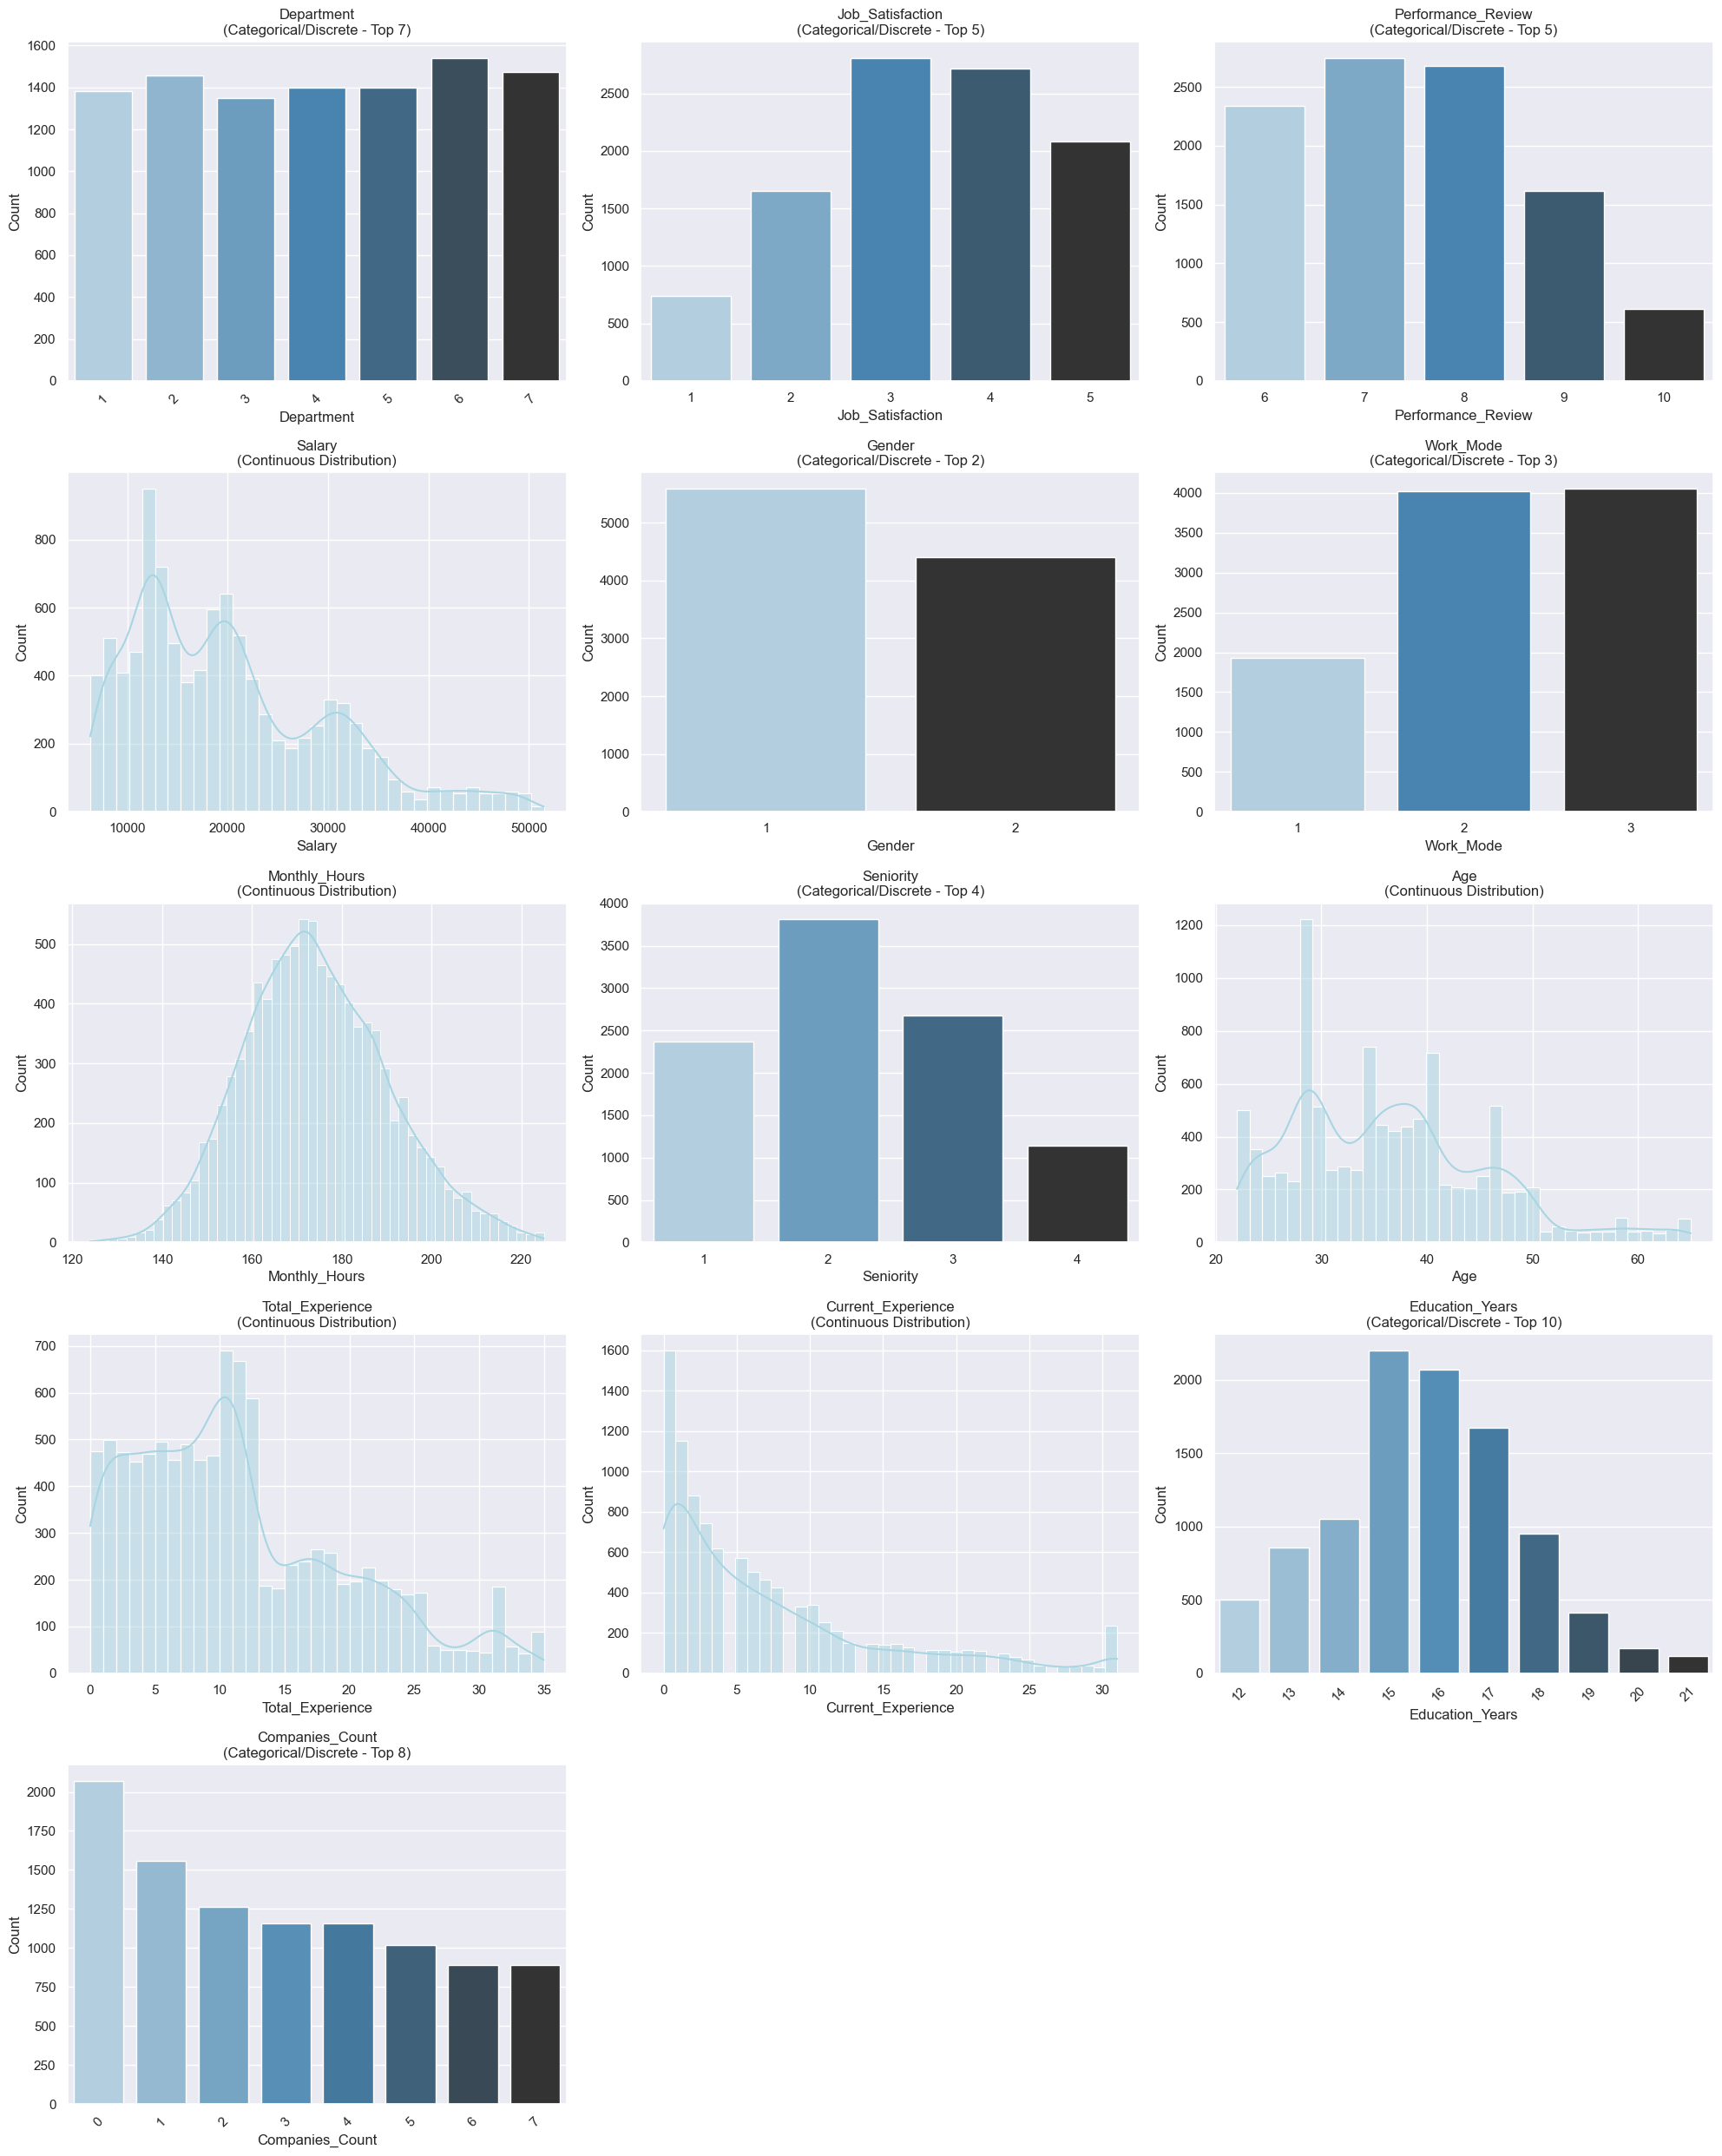

In [117]:
graph_stats(dffullnum)

In [118]:
dffullnum.toPandas().head()

ID  Department  Job_Satisfaction  Performance_Review  Salary  Gender  \
0    56           3                 1                   7   36500       2   
1   484           3                 2                   6   16000       1   
2   564           3                 4                   7    9400       2   
3  1173           3                 3                   7   36400       2   
4  1238           3                 3                   7   15000       2   

   Work_Mode  Monthly_Hours  Seniority  Age  Total_Experience  \
0          3            206          4   53                16   
1          2            163          2   34                 8   
2          3            170          1   30                 3   
3          2            222          4   49                29   
4          3            177          2   39                 6   

   Current_Experience  Education_Years  Companies_Count  
0                  15               15                3  
1                   6               18                3  
2                   3               15                2  
3                  29               14                4  
4                   2               12                4

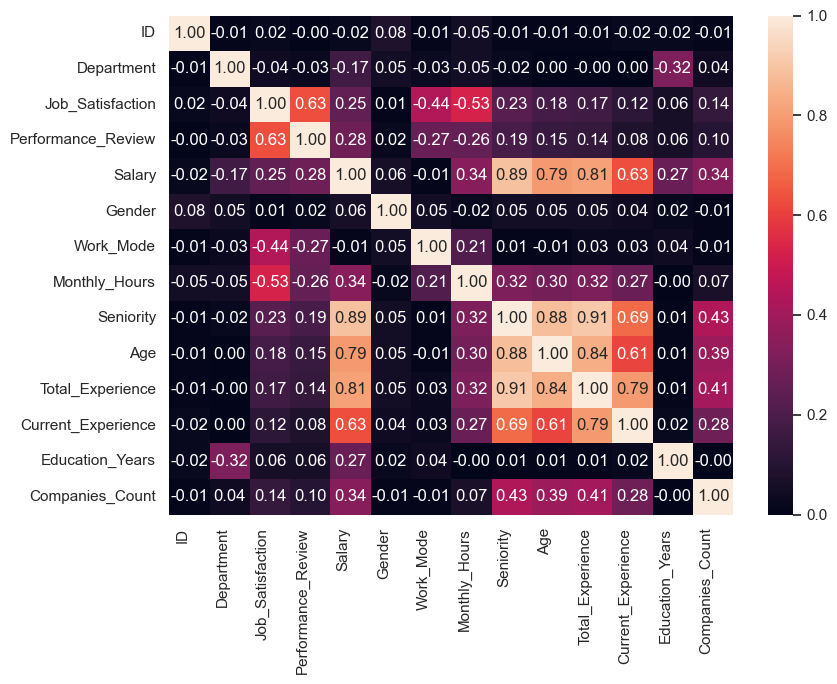

ID  Department  Job_Satisfaction  Performance_Review  \
ID                  1.00       -0.01              0.02               -0.00   
Department         -0.01        1.00             -0.04               -0.03   
Job_Satisfaction    0.02       -0.04              1.00                0.63   
Performance_Review -0.00       -0.03              0.63                1.00   
Salary             -0.02       -0.17              0.25                0.28   
Gender              0.08        0.05              0.01                0.02   
Work_Mode          -0.01       -0.03             -0.44               -0.27   
Monthly_Hours      -0.05       -0.05             -0.53               -0.26   
Seniority          -0.01       -0.02              0.23                0.19   
Age                -0.01        0.00              0.18                0.15   
Total_Experience   -0.01       -0.00              0.17                0.14   
Current_Experience -0.02        0.00              0.12                0.08   
Education_Years    -0.02       -0.32              0.06                0.06   
Companies_Count    -0.01        0.04              0.14                0.10   

                    Salary  Gender  Work_Mode  Monthly_Hours  Seniority   Age  \
ID                   -0.02    0.08      -0.01          -0.05      -0.01 -0.01   
Department           -0.17    0.05      -0.03          -0.05      -0.02  0.00   
Job_Satisfaction      0.25    0.01      -0.44          -0.53       0.23  0.18   
Performance_Review    0.28    0.02      -0.27          -0.26       0.19  0.15   
Salary                1.00    0.06      -0.01           0.34       0.89  0.79   
Gender                0.06    1.00       0.05          -0.02       0.05  0.05   
Work_Mode            -0.01    0.05       1.00           0.21       0.01 -0.01   
Monthly_Hours         0.34   -0.02       0.21           1.00       0.32  0.30   
Seniority             0.89    0.05       0.01           0.32       1.00  0.88   
Age                   0.79    0.05      -0.01           0.30       0.88  1.00   
Total_Experience      0.81    0.05       0.03           0.32       0.91  0.84   
Current_Experience    0.63    0.04       0.03           0.27       0.69  0.61   
Education_Years       0.27    0.02       0.04          -0.00       0.01  0.01   
Companies_Count       0.34   -0.01      -0.01           0.07       0.43  0.39   

                    Total_Experience  Current_Experience  Education_Years  \
ID                             -0.01               -0.02            -0.02   
Department                     -0.00                0.00            -0.32   
Job_Satisfaction                0.17                0.12             0.06   
Performance_Review              0.14                0.08             0.06   
Salary                          0.81                0.63             0.27   
Gender                          0.05                0.04             0.02   
Work_Mode                       0.03                0.03             0.04   
Monthly_Hours                   0.32                0.27            -0.00   
Seniority                       0.91                0.69             0.01   
Age                             0.84                0.61             0.01   
Total_Experience                1.00                0.79             0.01   
Current_Experience              0.79                1.00             0.02   
Education_Years                 0.01                0.02             1.00   
Companies_Count                 0.41                0.28            -0.00   

                    Companies_Count  
ID                            -0.01  
Department                     0.04  
Job_Satisfaction               0.14  
Performance_Review             0.10  
Salary                         0.34  
Gender                        -0.01  
Work_Mode                     -0.01  
Monthly_Hours                  0.07  
Seniority                      0.43  
Age                            0.39  
Total_Experience               0.41  
Current_Experience     

In [119]:
correlation_matrix(dffullnum, figsize=(9, 7))

<h3 dir="rtl" align="right">
הרצת מודל KMeans
</h3>

In [121]:
features_cols = [
    "Age", "Gender", "Department", "Work_Mode", "Current_Experience",
    "Companies_Count", "Education_Years", "Total_Experience",
    "Seniority", "Monthly_Hours", "Job_Satisfaction", "Performance_Review", "Salary"
]

assembler = VectorAssembler(inputCols=features_cols, outputCol="features_unscaled")

scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features")

pipeline = Pipeline(stages=[assembler, scaler])

model_prep = pipeline.fit(dffullnum)
df_scaled = model_prep.transform(dffullnum)

In [122]:
def kmeans_elbow(df, k_range=range(2, 11), sample_frac=1.0, figsize=(10, 6)):

    df_sample = df.sample(fraction=sample_frac, seed=42).cache()
        
    cost = []
    for k in k_range:
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_sample)
        
        wssse = model.summary.trainingCost
        cost.append(wssse)
        print(f"K={k} Cost={wssse}")
    
    df_sample.unpersist()
    
    df_cost = pd.DataFrame({'k': list(k_range), 'cost': cost})
    
    df_cost['slope'] = df_cost['cost'].diff() / df_cost['k'].diff()
    df_cost['percent'] = df_cost['cost'].pct_change() * 100
    df_cost = df_cost.round(3)
    
    plt.figure(figsize=figsize)
    plt.plot(df_cost['k'], df_cost['cost'], marker='o', linestyle='--', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Cost (WSSSE)', fontsize=12)
    plt.title('Elbow Method - Finding Optimal k', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df_cost

K=2 Cost=9533.27069850901
K=3 Cost=7915.675774666958
K=4 Cost=7068.707225274584
K=5 Cost=6527.127774298732
K=6 Cost=6177.45529160449
K=7 Cost=5889.850393634705
K=8 Cost=5593.519499877081
K=9 Cost=5433.370723949501
K=10 Cost=5234.342780676751


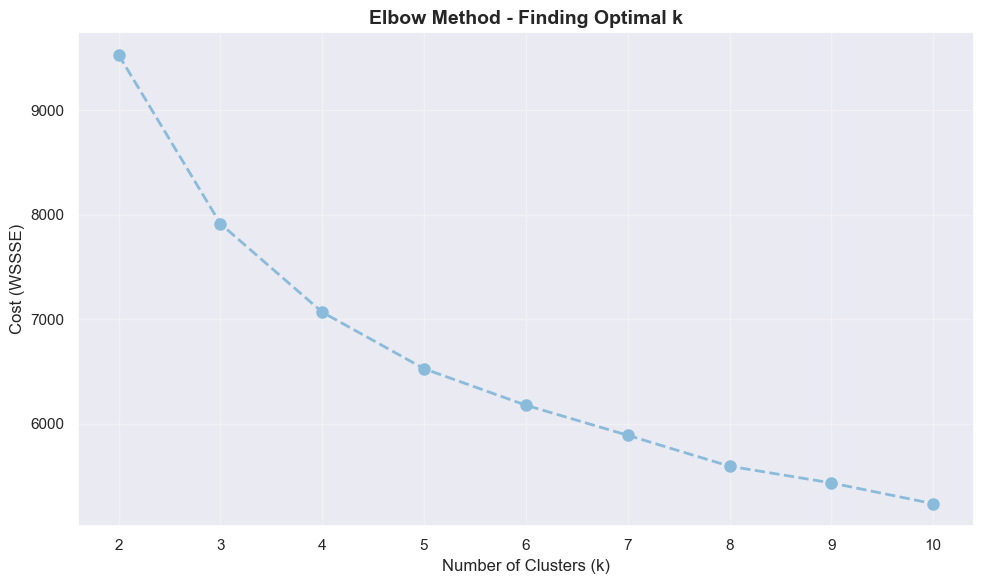

k      cost     slope  percent
0   2  9533.271       NaN      NaN
1   3  7915.676 -1617.595  -16.968
2   4  7068.707  -846.969  -10.700
3   5  6527.128  -541.579   -7.662
4   6  6177.455  -349.672   -5.357
5   7  5889.850  -287.605   -4.656
6   8  5593.519  -296.331   -5.031
7   9  5433.371  -160.149   -2.863
8  10  5234.343  -199.028   -3.663

In [123]:
kmeans_elbow(df_scaled, k_range=range(2, 11))

<h3 dir="rtl" align="right">
KMeans K=3
</h3>

In [125]:
chosen_k = 3

kmeans = KMeans().setK(chosen_k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_scaled)
best_predictions = model.transform(df_scaled)
df_3k_num = df_scaled.join(best_predictions.select("features", "prediction"), on="features")
df_3k_num.toPandas().head()

features    ID  Department  \
0  [0.18604651162790697, 1.0, 0.3333333333333333,...  7167           3   
1  [0.6511627906976745, 1.0, 0.5, 0.0, 0.19354838...  3877           4   
2  [0.46511627906976744, 0.0, 0.5, 1.0, 0.4516129...  4493           4   
3  [0.13953488372093023, 0.0, 1.0, 0.0, 0.0322580...  1784           7   
4  [0.3023255813953488, 1.0, 0.16666666666666666,...   707           2   

   Job_Satisfaction  Performance_Review  Salary  Gender  Work_Mode  \
0                 4                  10   10900       2          1   
1                 5                   8   34700       2          1   
2                 3                   7   47600       1          3   
3                 4                   6    7800       1          1   
4                 3                   6   17000       2          3   

   Monthly_Hours  Seniority  Age  Total_Experience  Current_Experience  \
0            184          1   30                 4                   1   
1            169          3   50                12                   6   
2            197          4   42                17                  14   
3            165          1   28                 1                   1   
4            179          2   35                 9                   5   

   Education_Years  Companies_Count  \
0               16                1   
1               17                5   
2               18                5   
3               15                0   
4               18                7   

                                   features_unscaled  prediction  
0  [30.0, 2.0, 3.0, 1.0, 1.0, 1.0, 16.0, 4.0, 1.0...           0  
1  [50.0, 2.0, 4.0, 1.0, 6.0, 5.0, 17.0, 12.0, 3....           2  
2  [42.0, 1.0, 4.0, 3.0, 14.0, 5.0, 18.0, 17.0, 4...           2  
3  [28.0, 1.0, 7.0, 1.0, 1.0, 0.0, 15.0, 1.0, 1.0...           1  
4  [35.0, 2.0, 2.0, 3.0, 5.0, 7.0, 18.0, 9.0, 2.0...           0

In [126]:
df_3k_num = df_3k_num.drop("features", "features_unscaled")
df_3k_num.toPandas().head()

ID  Department  Job_Satisfaction  Performance_Review  Salary  Gender  \
0  7167           3                 4                  10   10900       2   
1  3877           4                 5                   8   34700       2   
2  4493           4                 3                   7   47600       1   
3  1784           7                 4                   6    7800       1   
4   707           2                 3                   6   17000       2   

   Work_Mode  Monthly_Hours  Seniority  Age  Total_Experience  \
0          1            184          1   30                 4   
1          1            169          3   50                12   
2          3            197          4   42                17   
3          1            165          1   28                 1   
4          3            179          2   35                 9   

   Current_Experience  Education_Years  Companies_Count  prediction  
0                   1               16                1           0  
1                   6               17                5           2  
2                  14               18                5           2  
3                   1               15                0           1  
4                   5               18                7           0

Generating graphs for 14 columns (Total rows: 10000)...


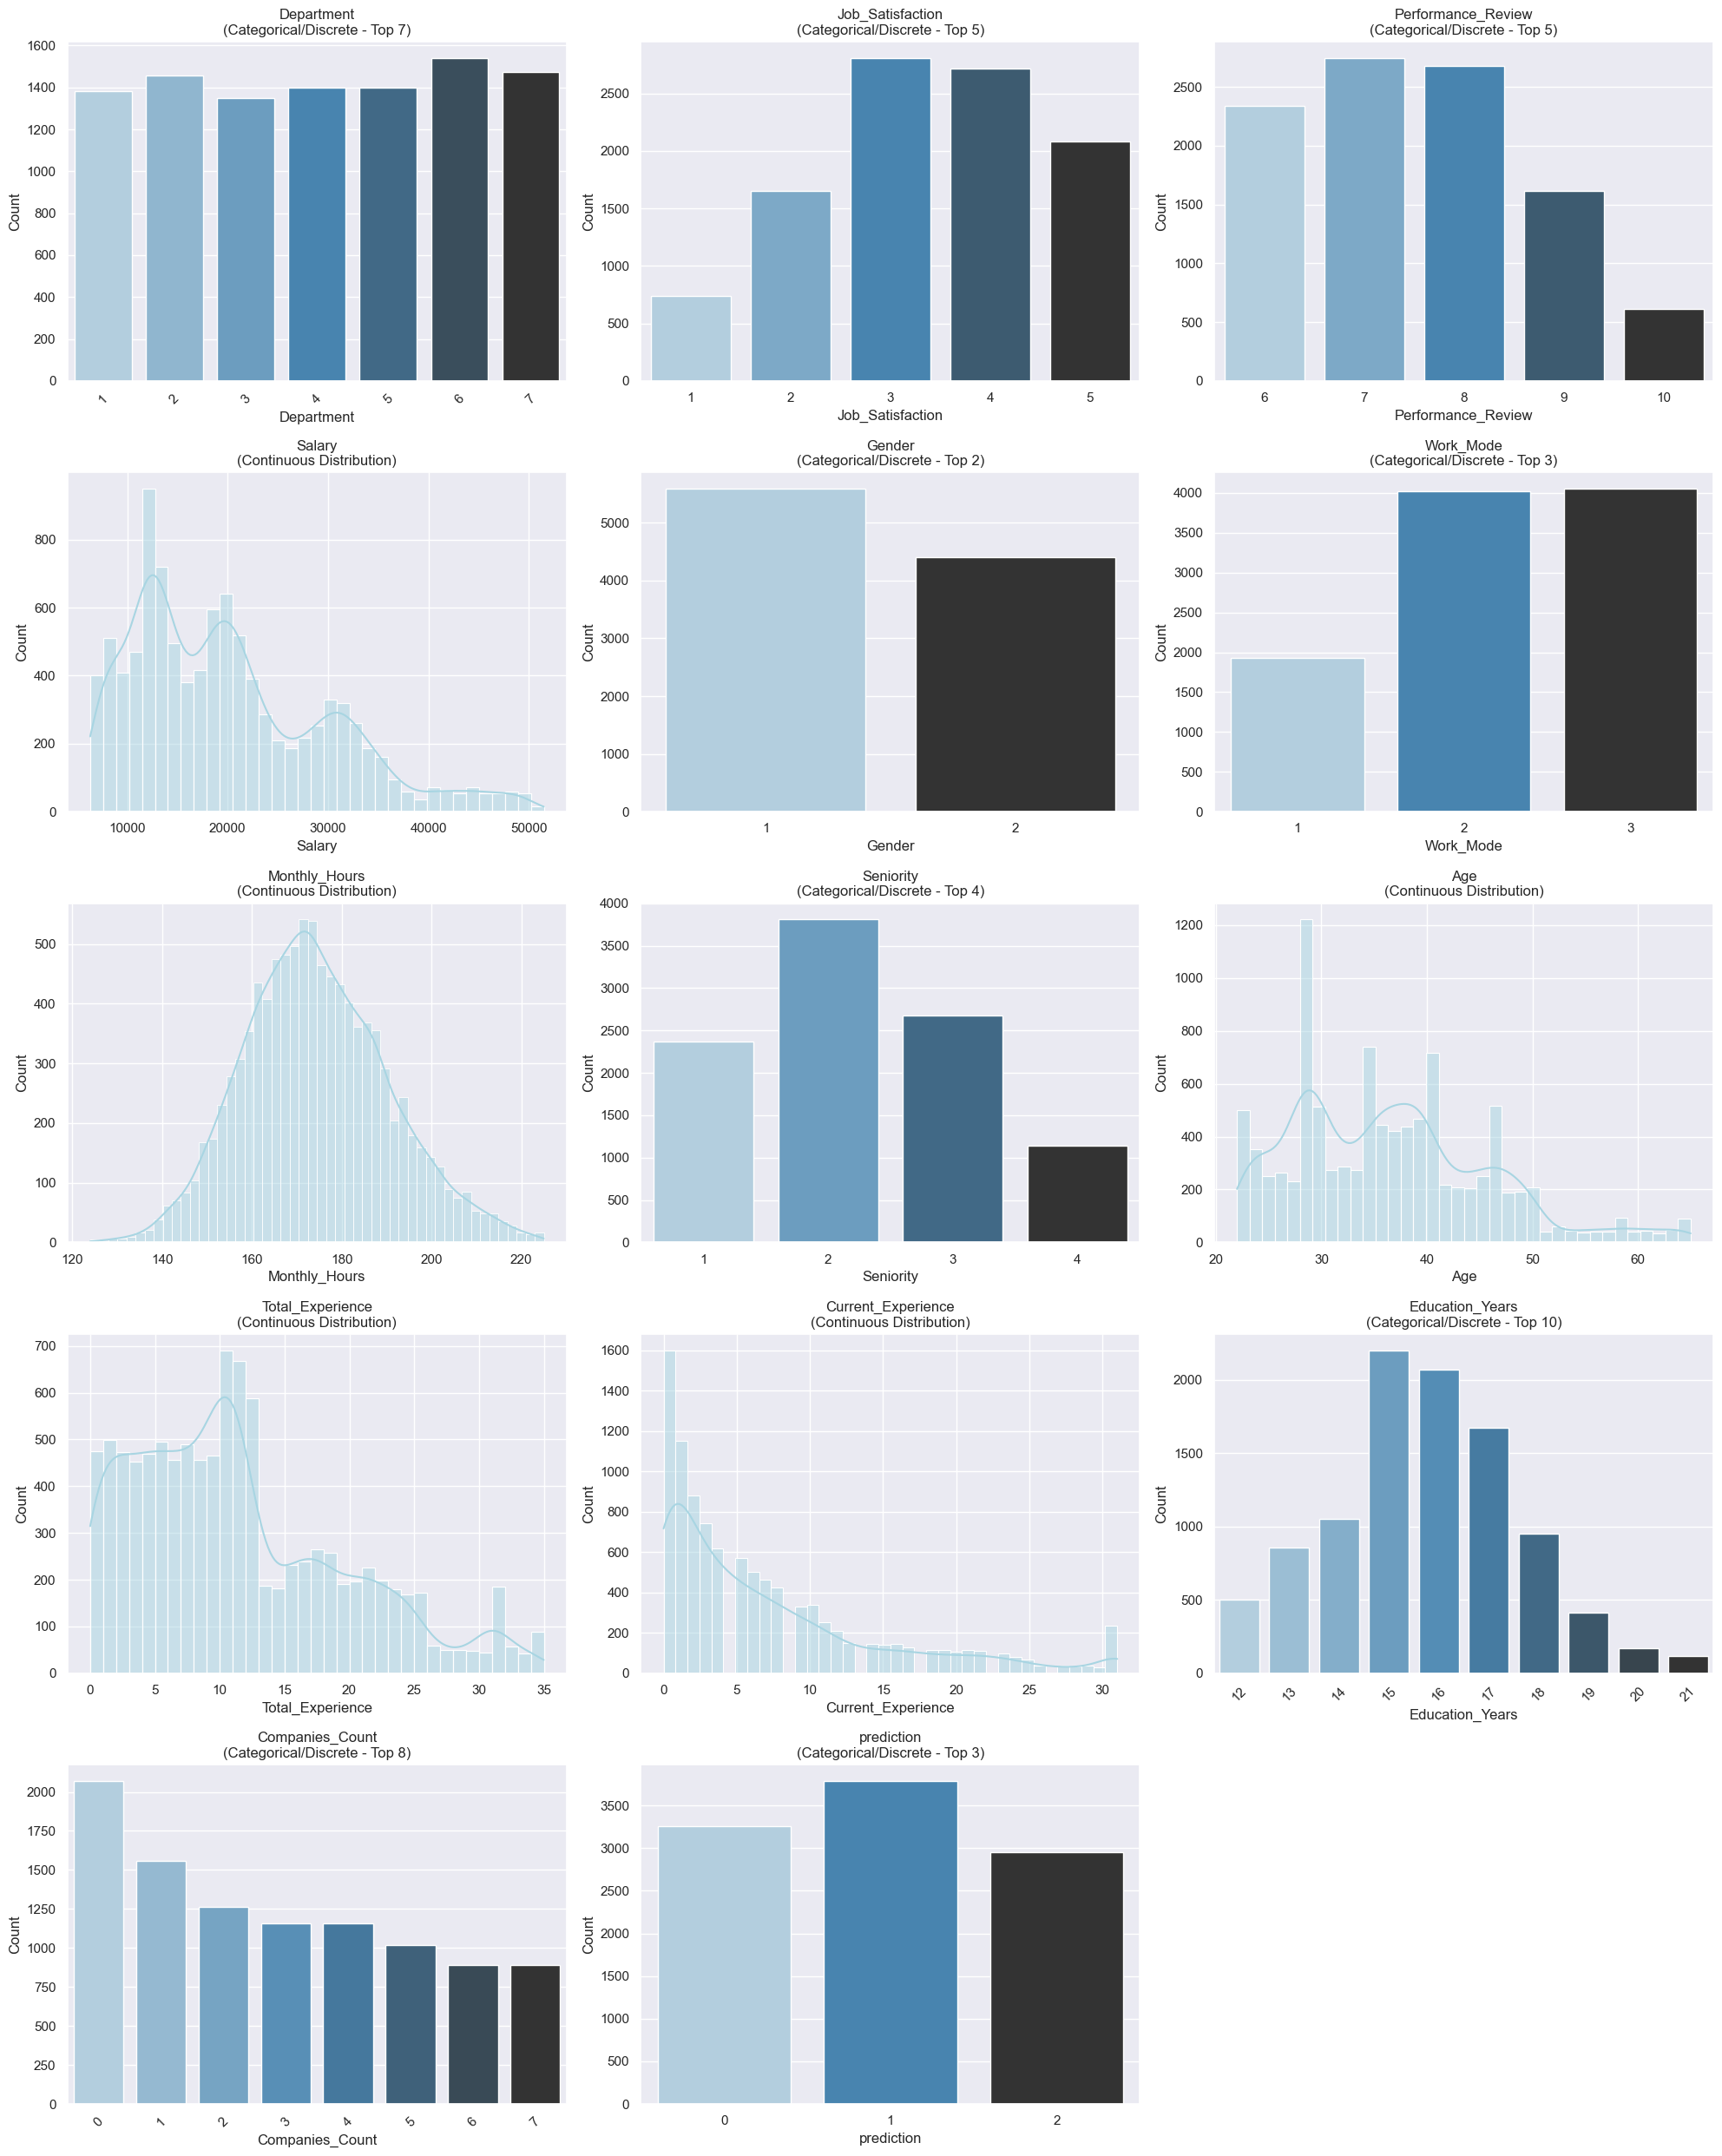

In [127]:
graph_stats(df_3k_num)

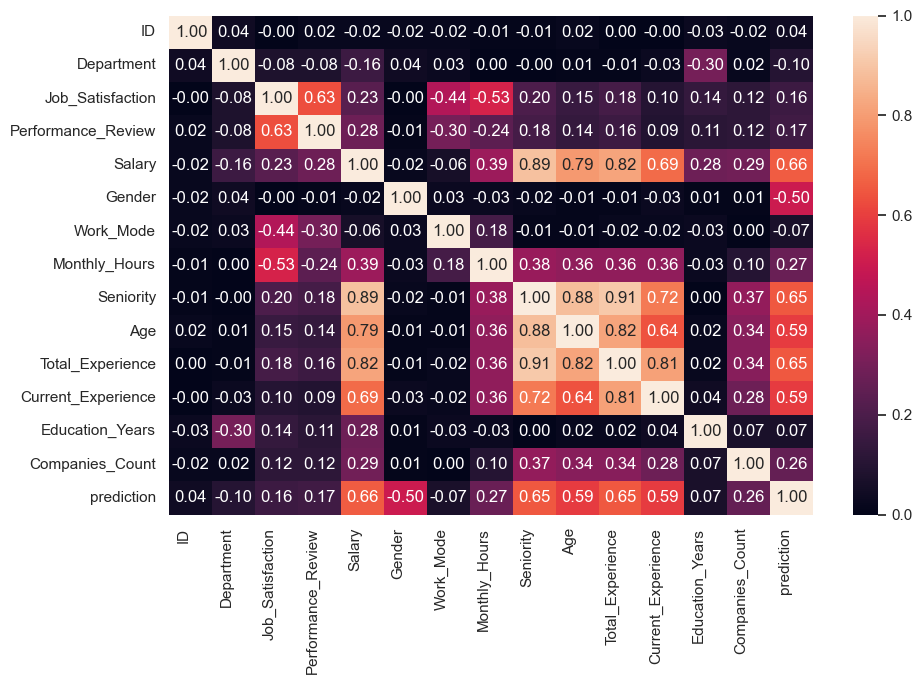

ID  Department  Job_Satisfaction  Performance_Review  \
ID                  1.00        0.04             -0.00                0.02   
Department          0.04        1.00             -0.08               -0.08   
Job_Satisfaction   -0.00       -0.08              1.00                0.63   
Performance_Review  0.02       -0.08              0.63                1.00   
Salary             -0.02       -0.16              0.23                0.28   
Gender             -0.02        0.04             -0.00               -0.01   
Work_Mode          -0.02        0.03             -0.44               -0.30   
Monthly_Hours      -0.01        0.00             -0.53               -0.24   
Seniority          -0.01       -0.00              0.20                0.18   
Age                 0.02        0.01              0.15                0.14   
Total_Experience    0.00       -0.01              0.18                0.16   
Current_Experience -0.00       -0.03              0.10                0.09   
Education_Years    -0.03       -0.30              0.14                0.11   
Companies_Count    -0.02        0.02              0.12                0.12   
prediction          0.04       -0.10              0.16                0.17   

                    Salary  Gender  Work_Mode  Monthly_Hours  Seniority   Age  \
ID                   -0.02   -0.02      -0.02          -0.01      -0.01  0.02   
Department           -0.16    0.04       0.03           0.00      -0.00  0.01   
Job_Satisfaction      0.23   -0.00      -0.44          -0.53       0.20  0.15   
Performance_Review    0.28   -0.01      -0.30          -0.24       0.18  0.14   
Salary                1.00   -0.02      -0.06           0.39       0.89  0.79   
Gender               -0.02    1.00       0.03          -0.03      -0.02 -0.01   
Work_Mode            -0.06    0.03       1.00           0.18      -0.01 -0.01   
Monthly_Hours         0.39   -0.03       0.18           1.00       0.38  0.36   
Seniority             0.89   -0.02      -0.01           0.38       1.00  0.88   
Age                   0.79   -0.01      -0.01           0.36       0.88  1.00   
Total_Experience      0.82   -0.01      -0.02           0.36       0.91  0.82   
Current_Experience    0.69   -0.03      -0.02           0.36       0.72  0.64   
Education_Years       0.28    0.01      -0.03          -0.03       0.00  0.02   
Companies_Count       0.29    0.01       0.00           0.10       0.37  0.34   
prediction            0.66   -0.50      -0.07           0.27       0.65  0.59   

                    Total_Experience  Current_Experience  Education_Years  \
ID                              0.00               -0.00            -0.03   
Department                     -0.01               -0.03            -0.30   
Job_Satisfaction                0.18                0.10             0.14   
Performance_Review              0.16                0.09             0.11   
Salary                          0.82                0.69             0.28   
Gender                         -0.01               -0.03             0.01   
Work_Mode                      -0.02               -0.02            -0.03   
Monthly_Hours                   0.36                0.36            -0.03   
Seniority                       0.91                0.72             0.00   
Age                             0.82                0.64             0.02   
Total_Experience                1.00                0.81             0.02   
Current_Experience              0.81                1.00             0.04   
Education_Years                 0.02                0.04             1.00   
Companies_Count                 0.34                0.28             0.07   
prediction                      0.65                0.59             0.07   

                    Companies_Count  prediction  
ID                            -0.02        0.04  
Department                     0.02       -0.10  
Job_Satisfaction               0.12        0.16  
Performance_Review             0.12        

In [128]:
correlation_matrix(df_3k_num, figsize=(10, 7))

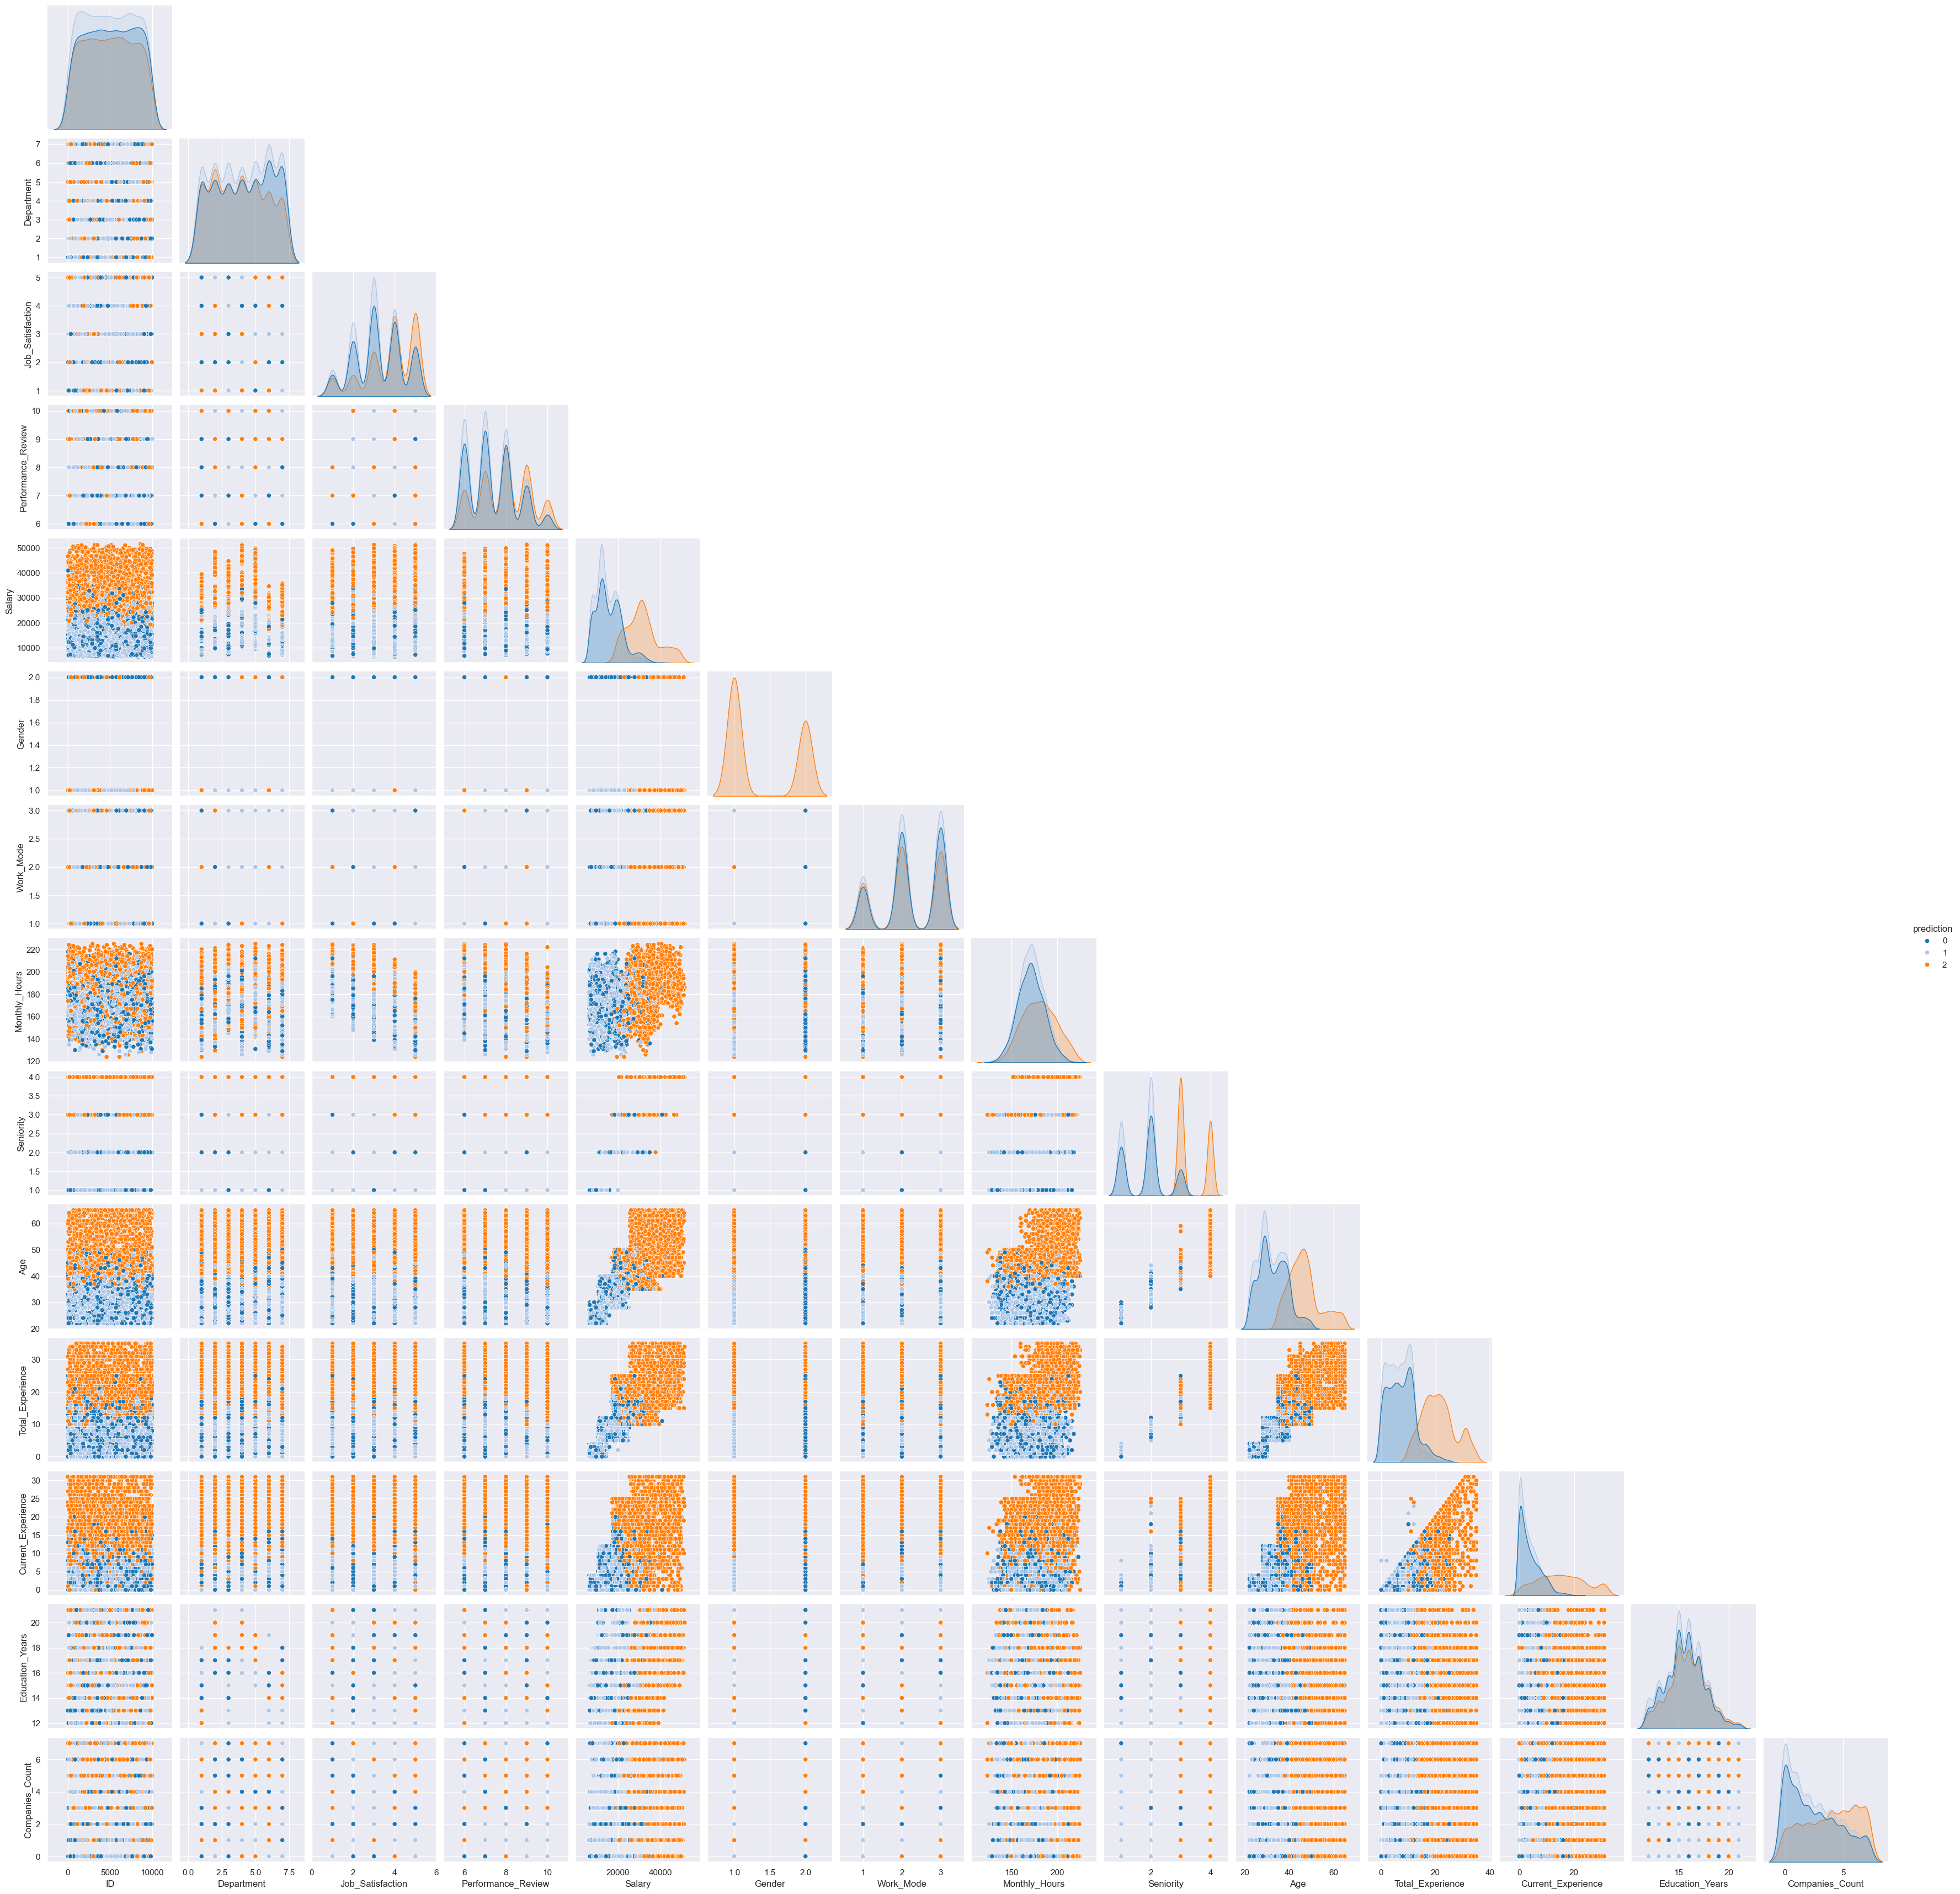

In [129]:
sns.pairplot(df_3k_num.toPandas(), hue='prediction', palette='tab20', corner=True)

<h3 dir="rtl" align="right">
החזרת ערכי השדות הקטגוריאליים
</h3>

In [131]:
dff = df_3k_num.withColumns({
    "Gender": F.when(F.col("Gender") == 1, "Male")
               .when(F.col("Gender") == 2, "Female")
               .otherwise(None),
    
    "Seniority": F.when(F.col("Seniority") == 1, "Junior")
                  .when(F.col("Seniority") == 2, "Mid")
                  .when(F.col("Seniority") == 3, "Senior")
                  .when(F.col("Seniority") == 4, "Manager")
                  .otherwise(None),
    
    "Work_Mode": F.when(F.col("Work_Mode") == 1, "Remote")
                  .when(F.col("Work_Mode") == 2, "Hybrid")
                  .when(F.col("Work_Mode") == 3, "Office")
                  .otherwise(None),
    
    "Department": F.when(F.col("Department") == 1, "Marketing")
                   .when(F.col("Department") == 2, "Legal")
                   .when(F.col("Department") == 3, "Sales")
                   .when(F.col("Department") == 4, "R&D")
                   .when(F.col("Department") == 5, "Finance")
                   .when(F.col("Department") == 6, "Support")
                   .when(F.col("Department") == 7, "HR")
                   .otherwise(None)})

dff.toPandas().head()

ID Department  Job_Satisfaction  Performance_Review  Salary  Gender  \
0  7167      Sales                 4                  10   10900  Female   
1  3877        R&D                 5                   8   34700  Female   
2  4493        R&D                 3                   7   47600    Male   
3  1784         HR                 4                   6    7800    Male   
4   707      Legal                 3                   6   17000  Female   

  Work_Mode  Monthly_Hours Seniority  Age  Total_Experience  \
0    Remote            184    Junior   30                 4   
1    Remote            169    Senior   50                12   
2    Office            197   Manager   42                17   
3    Remote            165    Junior   28                 1   
4    Office            179       Mid   35                 9   

   Current_Experience  Education_Years  Companies_Count  prediction  
0                   1               16                1           0  
1                   6               17                5           2  
2                  14               18                5           2  
3                   1               15                0           1  
4                   5               18                7           0

<h3 dir="rtl" align="right">
בדיקה סופית של הנתונים
</h3>

In [133]:
check_df(dff)

Dataset Shape: (10000, 15)
Total rows with at least one NULL: 0 (0.00%)
----------------------------------------------------------------------------------------------------
Column                         Dtype           Non-Null     Null         Null %     Unique    
ID                             int             10000        0            0.0        10000     
Department                     string          10000        0            0.0        7         
Job_Satisfaction               int             10000        0            0.0        5         
Performance_Review             int             10000        0            0.0        5         
Salary                         int             10000        0            0.0        446       
Gender                         string          10000        0            0.0        2         
Work_Mode                      string          10000        0            0.0        3         
Monthly_Hours                  int             10000        0      

Generating graphs for 14 columns (Total rows: 10000)...


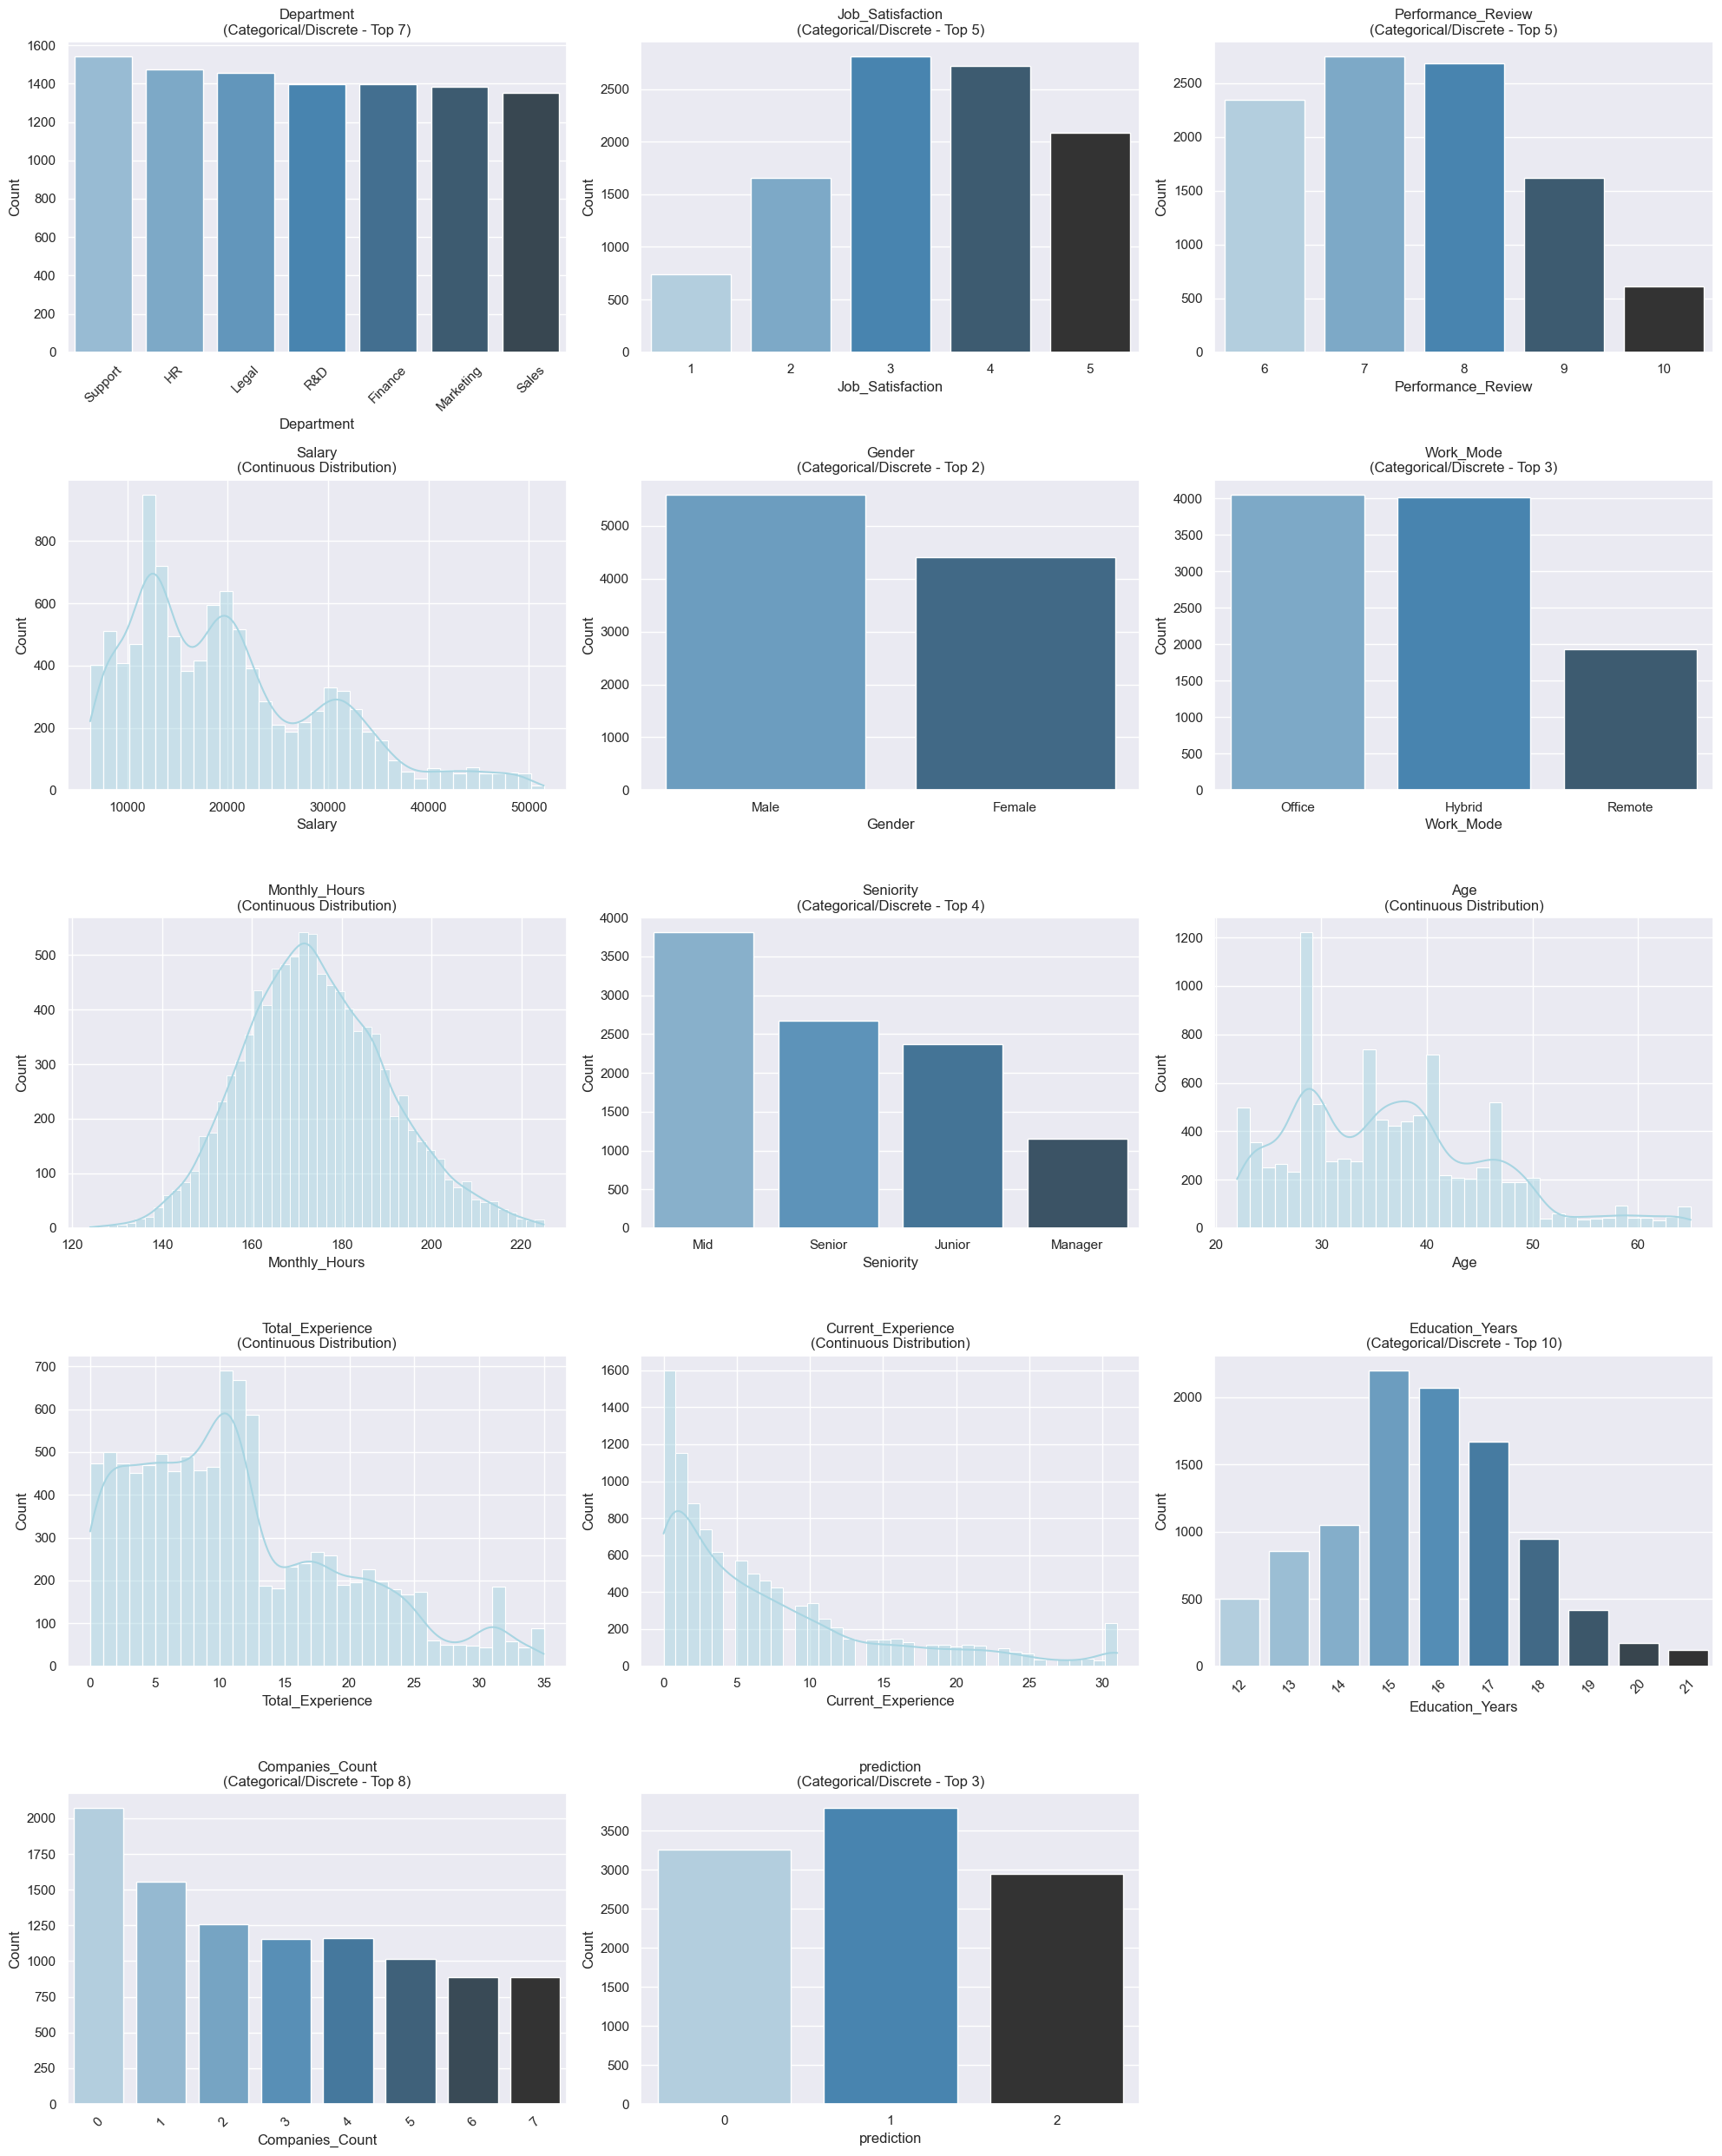

In [134]:
graph_stats(dff)

<h3 dir="rtl" align="right">
ניתוח מתאם עמודת שכר מול עמודות נבחרות
</h3>

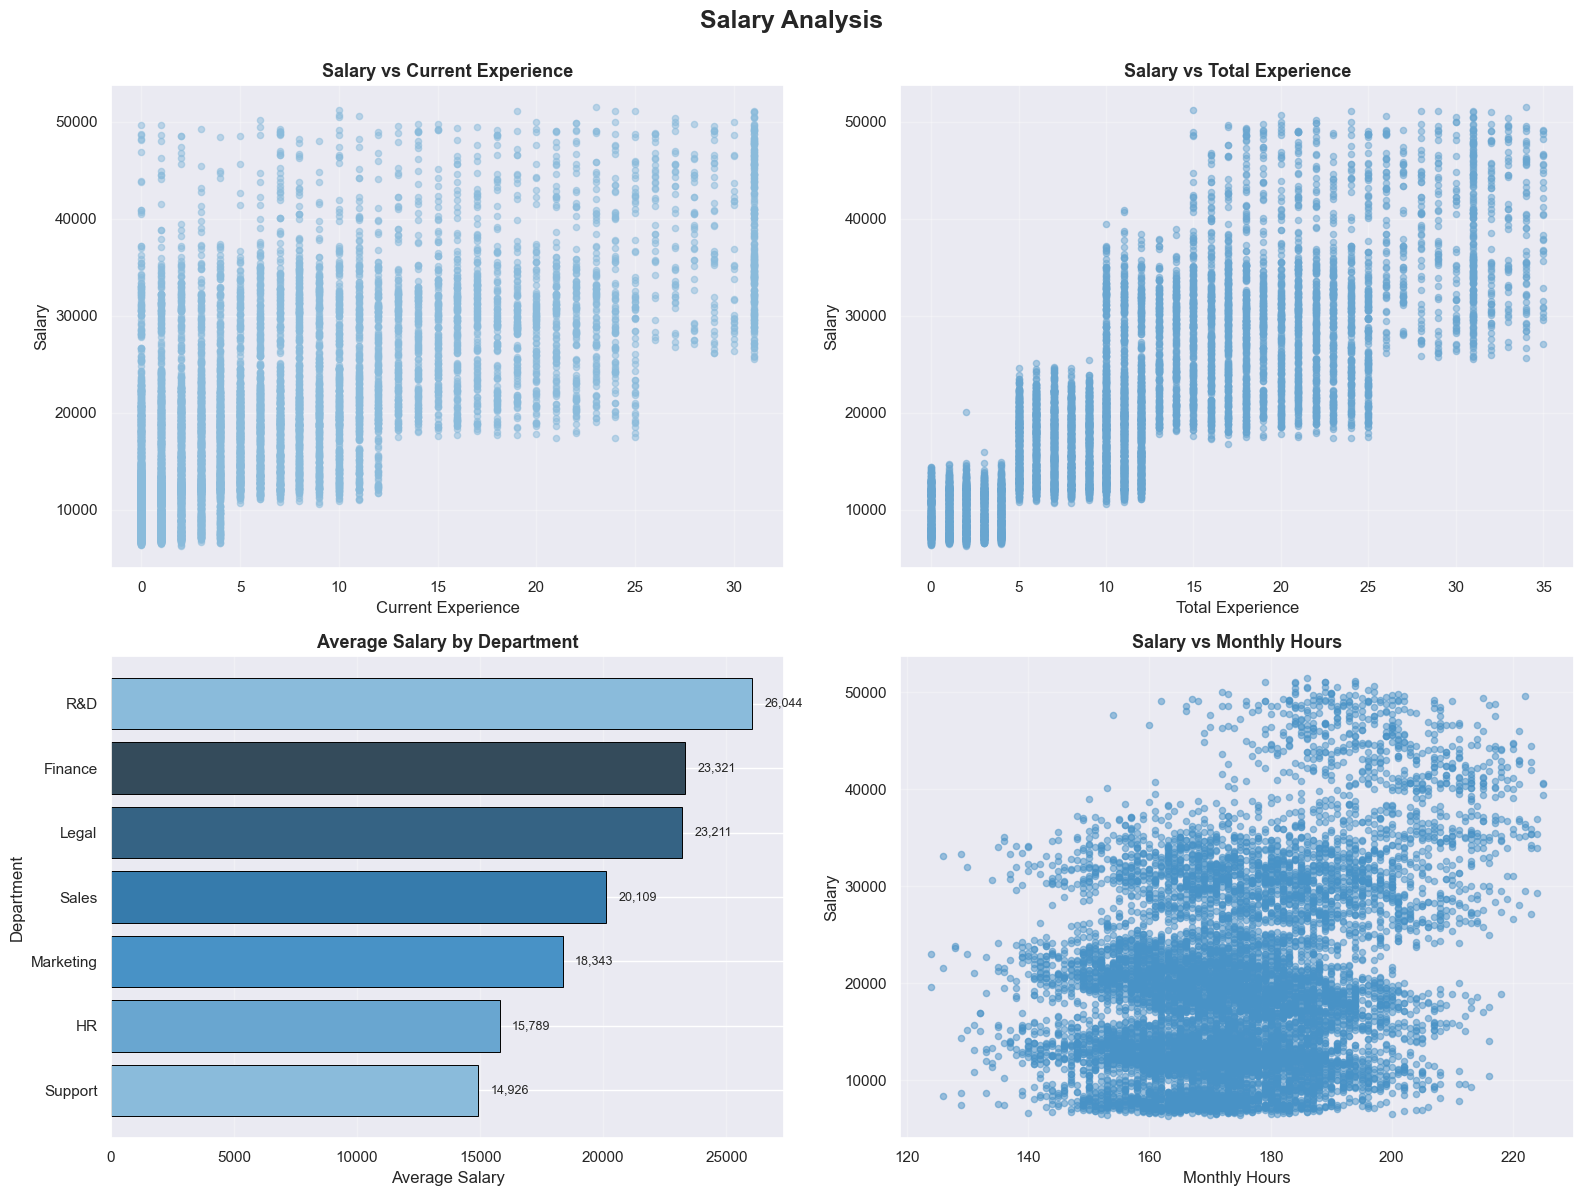

In [136]:
df_pandas = dff.select('Salary', 'Current_Experience', 'Total_Experience', 
                          'Department', 'Monthly_Hours').toPandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
palette = sns.color_palette()

scatter_cols = ['Current_Experience', 'Total_Experience', 'Monthly_Hours']
positions = [(0, 0), (0, 1), (1, 1)]

for idx, (col_name, (row, col)) in enumerate(zip(scatter_cols, positions)):
    axes[row, col].scatter(df_pandas[col_name], df_pandas['Salary'], 
                          alpha=0.5, s=20, color=palette[idx])
    axes[row, col].set(xlabel=col_name.replace('_', ' ').title(), 
                       ylabel='Salary',
                       title=f"Salary vs {col_name.replace('_', ' ').title()}")
    axes[row, col].title.set(fontweight='bold', fontsize=13)
    axes[row, col].grid(True, alpha=0.3)

dept_salary = df_pandas.groupby('Department')['Salary'].mean().sort_values()

axes[1, 0].barh(dept_salary.index, dept_salary.values, 
                color=palette[:len(dept_salary)], 
                edgecolor='black', linewidth=0.7)
axes[1, 0].set(xlabel='Average Salary', ylabel='Department',
               title='Average Salary by Department')
axes[1, 0].title.set(fontweight='bold', fontsize=13)
axes[1, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(dept_salary.values):
    axes[1, 0].text(v + 500, i, f'{int(v):,}', va='center', fontsize=9)

fig.suptitle('Salary Analysis', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

<h3 dir="rtl" align="right">
ניתוח עמודת שביעות רצון מעבודה
</h3>

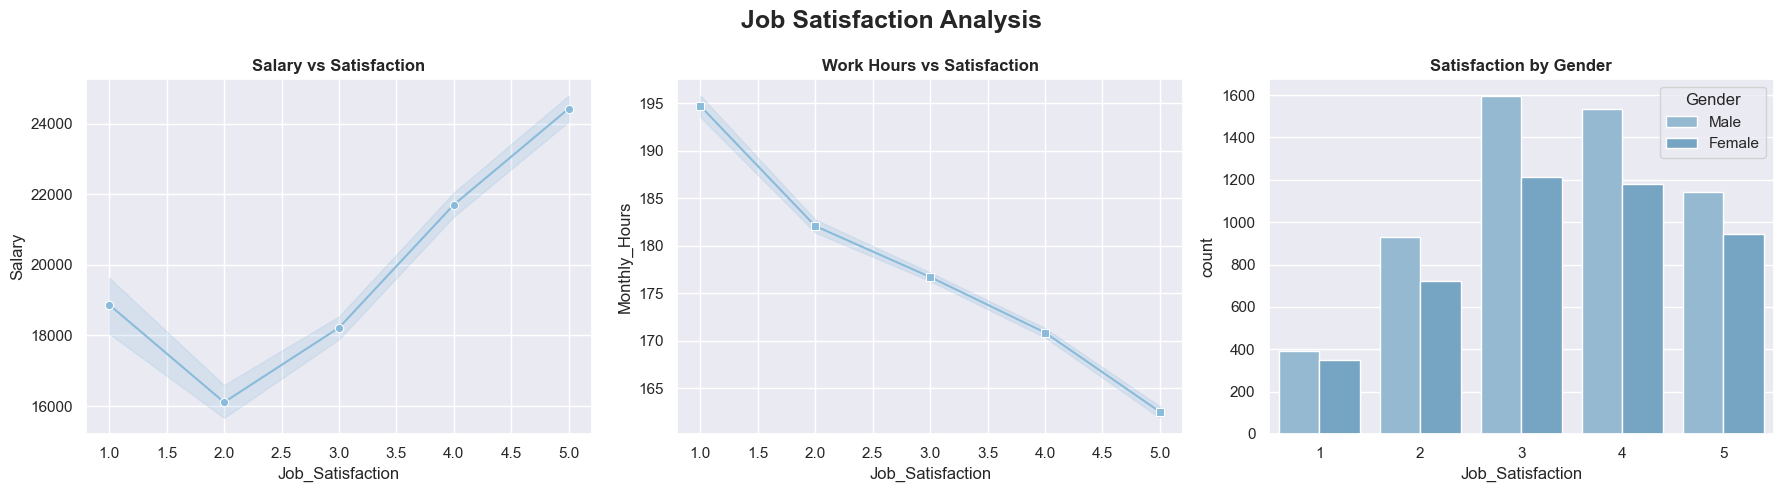

In [138]:
df_pandas = dff.select('Job_Satisfaction', 'Salary', 'Monthly_Hours', 'Gender').toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Job Satisfaction Analysis', fontsize=18, fontweight='bold')

sns.lineplot(data=df_pandas, x='Job_Satisfaction', y='Salary', 
             marker='o', ax=axes[0])
axes[0].set_title('Salary vs Satisfaction', fontweight='bold')

sns.lineplot(data=df_pandas, x='Job_Satisfaction', y='Monthly_Hours',
             marker='s', ax=axes[1])
axes[1].set_title('Work Hours vs Satisfaction', fontweight='bold')

sns.countplot(data=df_pandas, x='Job_Satisfaction', hue='Gender', ax=axes[2])
axes[2].set_title('Satisfaction by Gender', fontweight='bold')

plt.tight_layout()
plt.show()

<h3 dir="rtl" align="right">
ניתוח עמודת שכר לפי מחלקה, מגדר ומודל עבודה 
</h3>

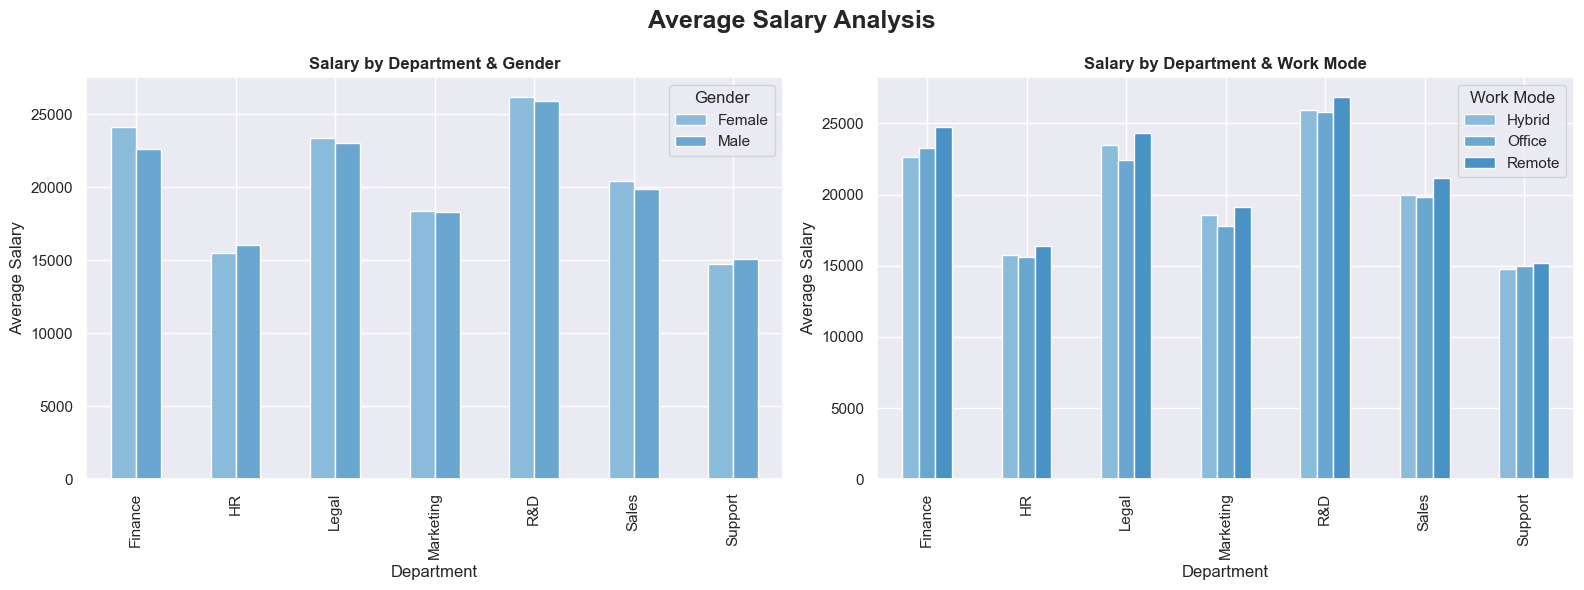

In [140]:
df_salary = (dff.groupBy('Department', 'Gender', 'Work_Mode').agg(F.avg('Salary').alias('Avg_Salary')).toPandas())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Average Salary Analysis', fontsize=18, fontweight='bold')

dept_gender = dff.groupBy('Department', 'Gender').agg(F.avg('Salary').alias('Avg_Salary')).toPandas()
dept_gender_pivot = dept_gender.pivot(index='Department', columns='Gender', values='Avg_Salary')
dept_gender_pivot.plot(kind='bar', ax=axes[0])
axes[0].set_title('Salary by Department & Gender', fontweight='bold')
axes[0].set_ylabel('Average Salary')
axes[0].legend(title='Gender')

dept_mode = dff.groupBy('Department', 'Work_Mode').agg(F.avg('Salary').alias('Avg_Salary')).toPandas()
dept_mode_pivot = dept_mode.pivot(index='Department', columns='Work_Mode', values='Avg_Salary')
dept_mode_pivot.plot(kind='bar', ax=axes[1])
axes[1].set_title('Salary by Department & Work Mode', fontweight='bold')
axes[1].set_ylabel('Average Salary')
axes[1].legend(title='Work Mode')

plt.tight_layout()
plt.show()

<h3 dir="rtl" align="right">
התפלגות העובדים לפי מחלקות
</h3>

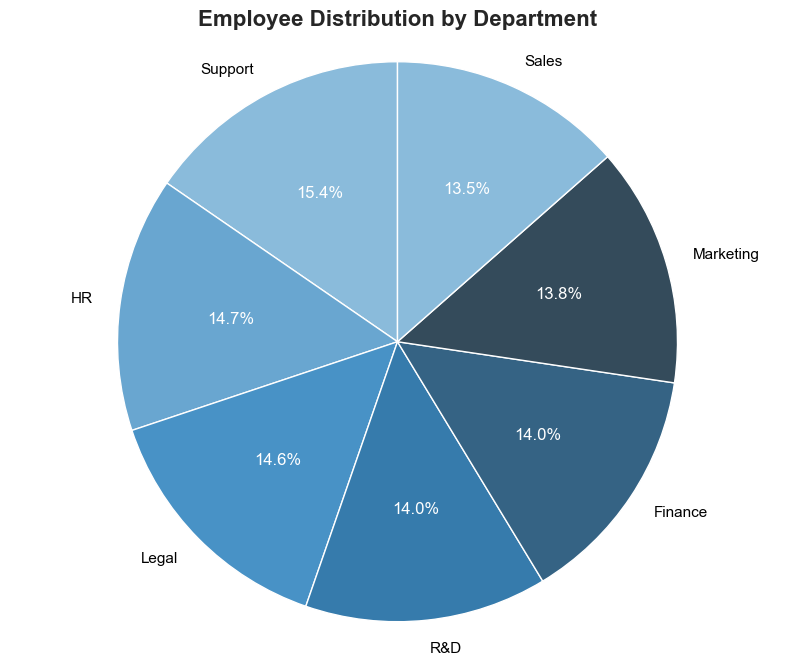

In [142]:
dept_count = dff.groupBy('Department').count().toPandas().sort_values('count', ascending=False)
dept_count['Percentage'] = (dept_count['count'] / dept_count['count'].sum() * 100).round(2)
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(dept_count['count'], labels=dept_count['Department'], 
                                     autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
plt.title('Employee Distribution by Department', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

<h3 dir="rtl" align="right">
מודל LLM ליצירת מאתר עובדים לפיטורים
</h3>

In [144]:
def get_layoff_recommendation(df, layoff_percent):
    
    df_scored = df.withColumn("raw_score", 
        F.when(F.col("Performance_Review") < 8, (8 - F.col("Performance_Review")) * 2.0).otherwise(0) +
        F.when((F.col("Age") > 60) | (F.col("Age") < 24), 5.0).otherwise(0) +
        F.when(F.col("Seniority") == "Junior", 4.0).otherwise(0) + 
        F.when(F.col("Education_Years") >= 15, -3.0).otherwise(0) +
        F.when(F.col("Job_Satisfaction") >= 4, -10.0).otherwise(0))

    stats = df_scored.select(F.min("raw_score").alias("min"),
                             F.max("raw_score").alias("max")).collect()[0]
    min_val, max_val = stats["min"], stats["max"]
    
    denominator = max_val - min_val
    denominator = 1 if denominator == 0 else denominator

    df_scored = df_scored.withColumn("Layoff_Score", 
        F.round(1 + (F.col("raw_score") - min_val) * (9 / denominator), 2))

    dept_counts = df_scored.groupBy("Department").count().withColumnRenamed("count", "dept_total")
    df_with_counts = df_scored.join(dept_counts, "Department")
    
    df_with_counts = df_with_counts.withColumn("dept_layoff_target", 
                                               F.round(F.col("dept_total") * layoff_percent).cast("int"))

    window_dept = Window.partitionBy("Department").orderBy(F.col("Layoff_Score").desc(), F.col("Performance_Review").asc())
    df_ranked = df_with_counts.withColumn("dept_rank", F.row_number().over(window_dept))

    final_df = df_ranked.withColumn("Recommendation", 
                                    F.when(F.col("dept_rank") <= F.col("dept_layoff_target"), "Layoff")
                                    .otherwise("Keep"))

    return final_df.select(*df.columns, "Layoff_Score", "Recommendation")

In [145]:
dff = get_layoff_recommendation(dff, 0.15)
dff.toPandas()

ID Department  Job_Satisfaction  Performance_Review  Salary  Gender  \
0     7687    Finance                 1                   6   12600    Male   
1     9523    Finance                 2                   6   11400    Male   
2     8105    Finance                 3                   6   11100    Male   
3     6444    Finance                 2                   6   10700    Male   
4     2362    Finance                 3                   6   10100    Male   
...    ...        ...               ...                 ...     ...     ...   
9995  8460    Support                 5                  10   14400    Male   
9996  4581    Support                 5                  10   21500  Female   
9997  6888    Support                 5                  10   13900    Male   
9998  3271    Support                 4                  10   14500    Male   
9999  6091    Support                 5                  10   31700    Male   

     Work_Mode  Monthly_Hours Seniority  Age  Total_Experience  \
0       Hybrid            203    Junior   23                 2   
1       Hybrid            179    Junior   22                 0   
2       Office            159    Junior   23                 1   
3       Hybrid            201    Junior   23                 1   
4       Hybrid            180    Junior   22                 3   
...        ...            ...       ...  ...               ...   
9995    Office            155       Mid   39                 8   
9996    Office            167    Senior   47                14   
9997    Office            154       Mid   29                 9   
9998    Office            171       Mid   31                10   
9999    Hybrid            197   Manager   50                29   

      Current_Experience  Education_Years  Companies_Count  prediction  \
0                      1               16                0           1   
1                      0               15                0           1   
2                      1               16                1           1   
3                      1               16                0           1   
4                      1               15                0           1   
...                  ...              ...              ...         ...   
9995                   4               15                7           1   
9996                   6               15                2           0   
9997                   8               15                5           1   
9998                   6               15                1           1   
9999                  23               15                6           2   

      Layoff_Score Recommendation  
0             8.96         Layoff  
1             8.96         Layoff  
2             8.96         Layoff  
3             8.96         Layoff  
4             8.96         Layoff  
...            ...            ...  
9995          1.00           Keep  
9996          1.00           Keep  
9997          1.00           Keep  
9998          1.00           Keep  
9999          1.00           Keep  

[10000 rows x 17 columns]

<h3 dir="rtl" align="right">
מאתר עובדים לפיטורים – ניתוח ציוני התאמה
</h3>

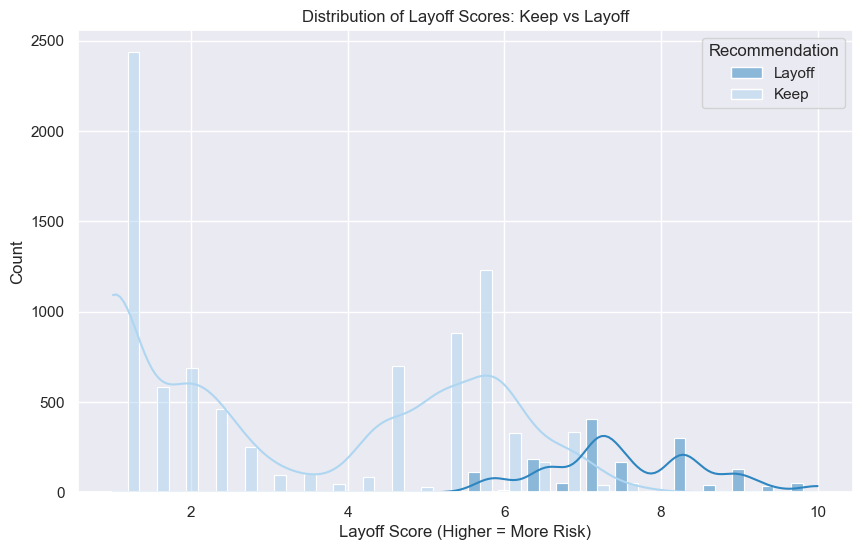

In [147]:
pdf = dff.select("Layoff_Score", "Recommendation").toPandas()
plt.figure(figsize=(10, 6))
my_colors = {"Keep": "#AED6F1", "Layoff": "#2E86C1"}
sns.histplot(data=pdf, x="Layoff_Score", hue="Recommendation", multiple="dodge", kde=True, palette=my_colors, shrink=0.8)
plt.title("Distribution of Layoff Scores: Keep vs Layoff")
plt.xlabel("Layoff Score (Higher = More Risk)")
plt.show()

In [148]:
df_kept = dff.filter(F.col("Recommendation") == "Keep")
df_kept.toPandas()

ID Department  Job_Satisfaction  Performance_Review  Salary  Gender  \
0     9806    Finance                 3                   6   28000    Male   
1     8649    Finance                 2                   6   18800    Male   
2     6143    Finance                 3                   6   17300    Male   
3     6653    Finance                 1                   6   39900    Male   
4     2241    Finance                 2                   6   40600  Female   
...    ...        ...               ...                 ...     ...     ...   
8494  8460    Support                 5                  10   14400    Male   
8495  4581    Support                 5                  10   21500  Female   
8496  6888    Support                 5                  10   13900    Male   
8497  3271    Support                 4                  10   14500    Male   
8498  6091    Support                 5                  10   31700    Male   

     Work_Mode  Monthly_Hours Seniority  Age  Total_Experience  \
0       Hybrid            176    Senior   35                13   
1       Office            188       Mid   39                12   
2       Hybrid            188       Mid   39                 9   
3       Office            205   Manager   51                26   
4       Hybrid            194   Manager   51                31   
...        ...            ...       ...  ...               ...   
8494    Office            155       Mid   39                 8   
8495    Office            167    Senior   47                14   
8496    Office            154       Mid   29                 9   
8497    Office            171       Mid   31                10   
8498    Hybrid            197   Manager   50                29   

      Current_Experience  Education_Years  Companies_Count  prediction  \
0                     12               15                6           2   
1                      1               17                7           1   
2                      5               15                6           1   
3                     14               15                0           2   
4                     31               15                7           2   
...                  ...              ...              ...         ...   
8494                   4               15                7           1   
8495                   6               15                2           0   
8496                   8               15                5           1   
8497                   6               15                1           1   
8498                  23               15                6           2   

      Layoff_Score Recommendation  
0             5.85           Keep  
1             5.85           Keep  
2             5.85           Keep  
3             5.85           Keep  
4             5.85           Keep  
...            ...            ...  
8494          1.00           Keep  
8495          1.00           Keep  
8496          1.00           Keep  
8497          1.00           Keep  
8498          1.00           Keep  

[8499 rows x 17 columns]

In [149]:
df_layoff = dff.filter(F.col("Recommendation") == "Layoff")
df_layoff.toPandas()

ID Department  Job_Satisfaction  Performance_Review  Salary Gender  \
0     7687    Finance                 1                   6   12600   Male   
1     9523    Finance                 2                   6   11400   Male   
2     8105    Finance                 3                   6   11100   Male   
3     6444    Finance                 2                   6   10700   Male   
4     2362    Finance                 3                   6   10100   Male   
...    ...        ...               ...                 ...     ...    ...   
1496  3195    Support                 2                   7    7200   Male   
1497  6120    Support                 3                   7    7900   Male   
1498  6222    Support                 2                   7    6900   Male   
1499  9073    Support                 3                   7    7600   Male   
1500   401    Support                 2                   7    7600   Male   

     Work_Mode  Monthly_Hours Seniority  Age  Total_Experience  \
0       Hybrid            203    Junior   23                 2   
1       Hybrid            179    Junior   22                 0   
2       Office            159    Junior   23                 1   
3       Hybrid            201    Junior   23                 1   
4       Hybrid            180    Junior   22                 3   
...        ...            ...       ...  ...               ...   
1496    Office            171    Junior   27                 4   
1497    Office            167    Junior   29                 0   
1498    Office            172    Junior   27                 0   
1499    Office            163    Junior   28                 4   
1500    Remote            163    Junior   26                 4   

      Current_Experience  Education_Years  Companies_Count  prediction  \
0                      1               16                0           1   
1                      0               15                0           1   
2                      1               16                1           1   
3                      1               16                0           1   
4                      1               15                0           1   
...                  ...              ...              ...         ...   
1496                   2               13                4           1   
1497                   0               13                0           1   
1498                   0               13                0           1   
1499                   1               13                3           1   
1500                   1               13                3           1   

      Layoff_Score Recommendation  
0             8.96         Layoff  
1             8.96         Layoff  
2             8.96         Layoff  
3             8.96         Layoff  
4             8.96         Layoff  
...            ...            ...  
1496          7.58         Layoff  
1497          7.58         Layoff  
1498          7.58         Layoff  
1499          7.58         Layoff  
1500          7.58         Layoff  

[1501 rows x 17 columns]

<h3 dir="rtl" align="right">
מאתר עובדים לפיטורים – ניתוח התאמה לקריטריונים
</h3>

Generating graphs for 5 columns (Total rows: 1501)...


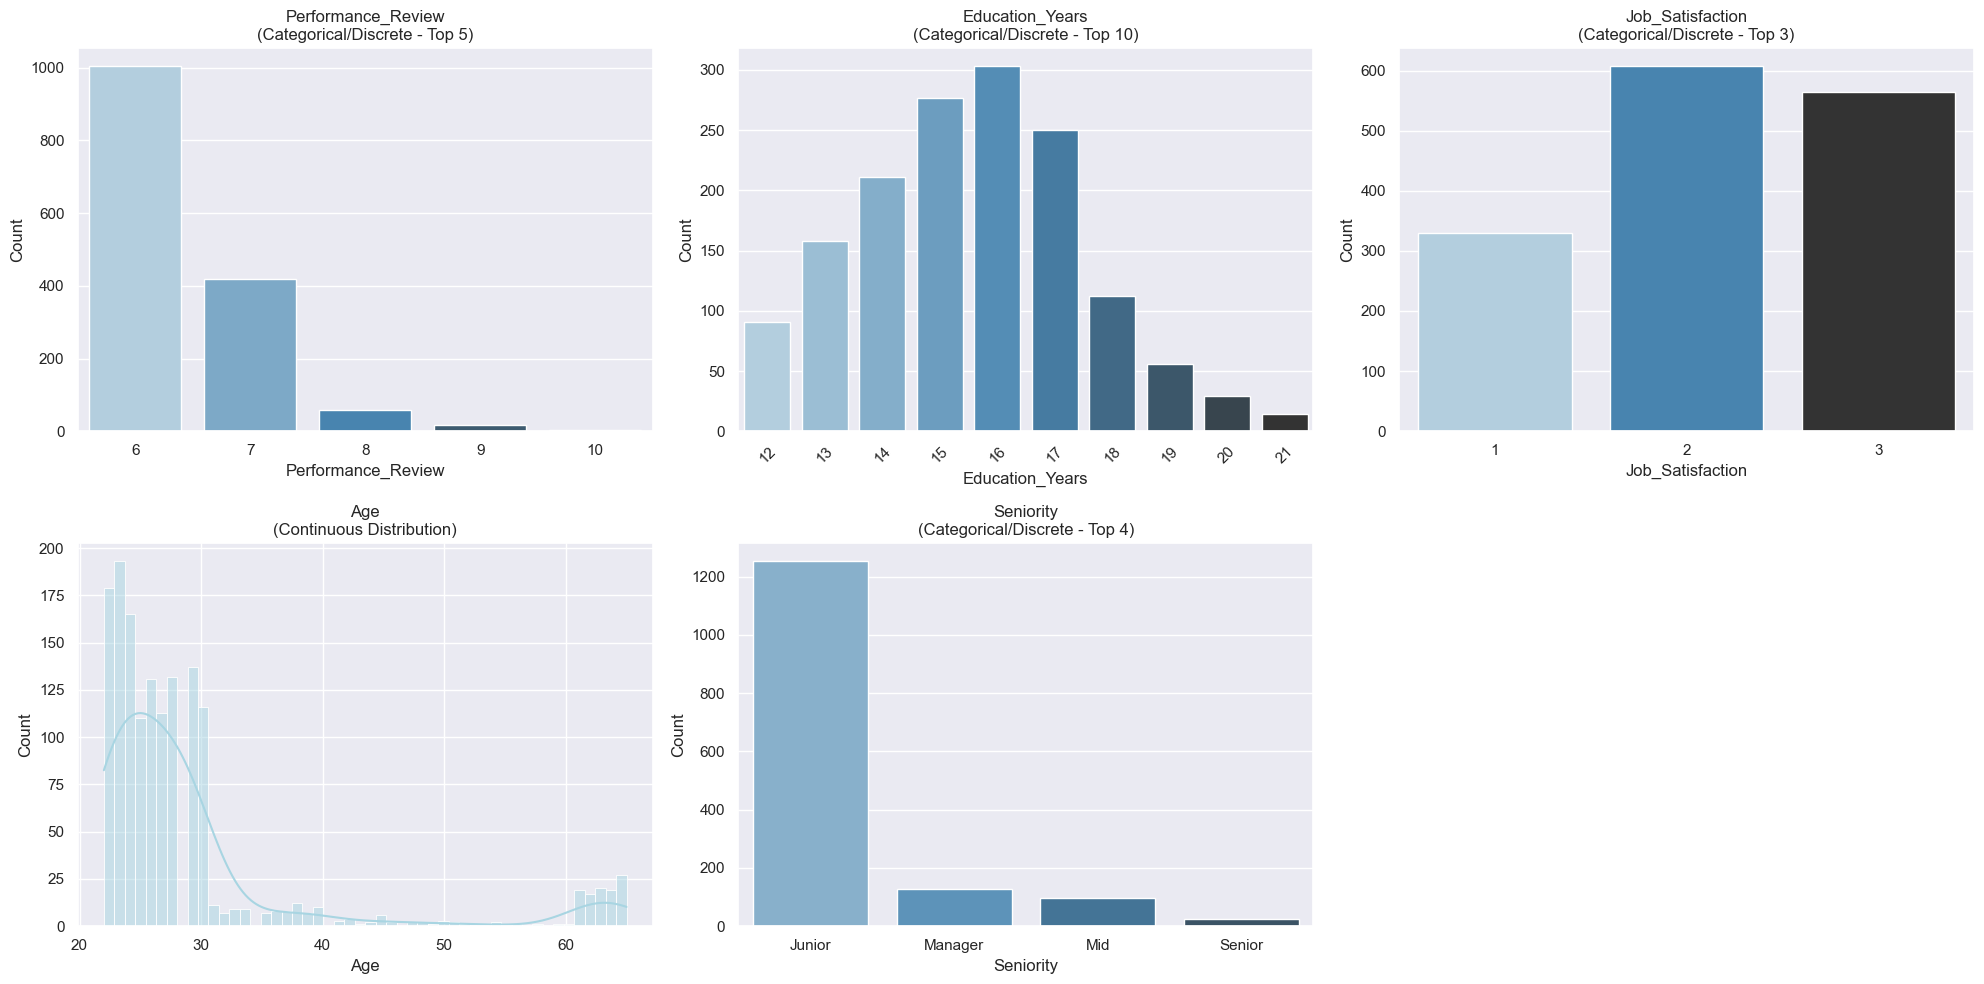

In [151]:
my_columns = ["Performance_Review", "Education_Years", "Job_Satisfaction", "Age", "Seniority"]
graph_stats(df_layoff.select(my_columns))